<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Porsche/Porsche_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "PAH3DEEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 17:08:58,000 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 17:08:58,001 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for PAH3DEEUR
2019-08-28 17:09:43,071 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 17:11:34,026 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 17:12:32,105 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 17:13:35,128 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 17:14:43,863 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 17:15:48,037 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 17:16:49,172 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 17:17:52,024 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 17:20:51,828 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_PAH3DEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-PAH3DEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-PAH3DEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  0.69938  0.69938  0.68137  0.68167  94.557800
2018-01-02 09:00:00  0.68167  0.68488  0.67728  0.68268  67.993202
2018-01-02 10:00:00  0.68217  0.68977  0.68217  0.68868  73.173996
2018-01-02 11:00:00  0.68828  0.69268  0.68828  0.69227  55.171200
2018-01-02 12:00:00  0.69228  0.69508  0.69227  0.69508  47.098488
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  0.51437  0.52058  0.51137  0.51957  52.778885
2018-12-28 09:00:00  0.51978  0.52098  0.51697  0.51997  23.639423
2018-12-28 10:00:00  0.51998  0.52138  0.51777  0.51798  16.126303
2018-12-28 11:00:00  0.51797  0.51858  0.51358  0.51397  22.328636
2018-12-28 12:00:00  0.51398  0.51718  0.51398  0.51718  26.004957

[2244 rows x 5 columns]

Open         High          Low        Close       Volume
count  2244.000000  2244.000000  2244.000000  2244.000000  2244.000000
mean      0.621203     0.623550     0.618697     0.621087    27.507345
std       0.075812     0.075863     0.075764     0.075823    22.889933
min       0.505580     0.507180     0.500020     0.505570     1.903633
25%       0.557580     0.559780     0.554970     0.557770    14.091109
50%       0.586830     0.589070     0.584370     0.586475    20.700091
75%       0.692022     0.694973     0.688970     0.691980    32.613558
max       0.799770     0.802780     0.793180     0.799780   235.099289

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close      Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2018-01-09 13:00:00  0.75487  0.76048  0.75437  0.75937  102.686996    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.750880  0.740159  0.742318  0.755133  0.750700  0.750228    0.752370    0.751775  0.742944  0.749513  0.756344  0.748582  0.751517  0.749513  0.754307  0.743047                0.758821                 0.749513                0.740204                0.763475                 0.749513                0.735550                0.768129                 0.749513                0.730896                0.772783                 0.749513                0.726242  0.750700  0.755342  0.744010                0.760009                 0.750700                0.741392                0.764663                 0.750700                0.736738                0.769317                 0.750700                0.732084                0.773971                 0.750700   
2018-01-09 14:00:00  0.75937  0.75938  0.75497  0.75508  111.224297    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.751090  0.740432  0.743408  0.755878  0.751674  0.750762    0.752620    0.751825  0.744347  0.750726  0.756643  0.750172  0.752754  0.750726  0.757225  0.744030                0.760090                 0.750726                0.741363                0.764771                 0.750726                0.736681                0.769453                 0.750726                0.732000                0.774134                 0.750726                0.727318  0.751674  0.755759  0.745009                0.761037                 0.751674                0.742310                0.765718                 0.751674                0.737629                0.770400                 0.751674                0.732947                0.775082                 0.751674   
2018-01-09 15:00:00  0.75508  0.75567  0.75307  0.75527  105.891899    9          1          9             31   

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000    2194.000000  2194.000000   2194.000000     2194.000000       2194.000000  2194.000000  2194.000000  2194.000000  2194.000000   2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000   
mean      0.618865     0.621199     0.616346     0.618728    26.339642    15.958979     2.032817   184.346855      30.416135    11.380128      0.032361        0.024157          0.004102     6.562899     2.522789    26.902005     2.032817      1.989973    26.902005     0.619257     0.620189    -0.038313     0.618737     0.619096     0.619398     0.619066     0.618983     0.619499     0.619099     0.618726     0.619099     0.618976     0.619099     0.618821     0.619805                0.626770                 0.619099                0.611429                0.630605                 0.619099                0.607594                0.634440                 0.619099                0.603758                0.638275                 0.619099                0.599923     0.619096     0.618812     0.619703                0.626767                 0.619096                0.611426                0.630602                 0.619096                0.607590                0.634437   
std       0.074996     0.075033     0.074926     0.074976    21.419096     8.554813     1.407691   101.476202       0.856048     2.621509      0.176997        0.153571          0.063931     3.340928     1.100379    14.496189     1.407691      1.399918    14.496189     0.074865     0.074677     0.622698     0.075030     0.074849     0.074684     0.074886     0.074784     0.075082     0.074913     0.075009     0.074943     0.074913     0.074913     0.074947     0.074806                0.075103                 0.074913                0.074994                0.075300                 0.074913                0.075137                0.075563                 0.074913                0.075347                0.075894                 0.074913                0.075625     0.074849     0.074936     0.074821                0.075046                 0.074849                0.074925                0.075246                 0.074849                0.075065                0.075513   
min       0.505580     0.507180     0.500020     0.505570     1.903633     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.847378  0.856901  0.867615  0.862649  0.432184    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.864209  0.838627  0.972134  0.865135  0.860542  0.860033    0.858973    0.853969  0.802365  0.853412  0.865524  0.846855  0.858802  0.853412  0.853905  0.842312                0.854727                 0.853412                0.854673                0.851638                 0.853412                0.858254                0.848265                 0.853412                0.858400                0.844462                 0.853412                0.852941  0.860542  0.862349  0.844456                0.855875                 0.860542                0.860077                0.851665                 0.860542                0.863440                0.847436                 0.860542                0.859689                0.843966                 0.860542   
2018-01-09 14:00:00  0.862674  0.853180  0.869662  0.848068  0.468794    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.864960  0.839649  0.972820  0.867731  0.864018  0.861962    0.859854    0.854144  0.806999  0.857712  0.866557  0.852458  0.863174  0.857712  0.863967  0.845921                0.859141                 0.857712                0.858707                0.856087                 0.857712                0.862078                0.852748                 0.857712                0.862001                0.848959                 0.857712                0.856302  0.864018  0.863798  0.848109                0.859456                 0.864018                0.863336                0.855288                 0.864018                0.866511                0.851096                 0.864018                0.862545                0.847647                 0.864018   
2018-01-09 15:00:00  0.848091  0.840629  0.863181  0.848713  0.445927    9          1          9         

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1z8jxpk8
  JVM stdout: /tmp/tmp1z8jxpk8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1z8jxpk8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_w9mjth
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.710685  2.181150              0.353999  0.554563  0.307540
1  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.710265  1.246732              0.365255  0.569143  0.323924
2  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.703461  0.672378              0.374664  0.487991  0.238135
3  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.701025  0.663720              0.366431  0.483425  0.233700
4  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.700521  0.613792              0.378528  0.464442  0.215706
5  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.700353  0.771568              0.337870  0.495941  0.245957
6  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.687668  0.608796              0.362399  0.462037  0.213478
7  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.686492  0.599696              0.353159  0.458902  0.210591
8  DeepLearning_grid_1_AutoML_20190828_173129_mod...  0.674815  0.627850              0.413138  0.469805  0.220717
9              DeepLearning_1_AutoML_20190828_173129  0.604923  0.698936              0.467238  0.495499  0.245520

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.001468
1           CDLCLOSINGMARUBOZU             0.813491           0.813491    0.001194
2               is_month_start             0.791810           0.791810    0.001162
3                       TRANGE             0.777050           0.777050    0.001141
4             CDLDRAGONFLYDOJI             0.776073           0.776073    0.001139
...                        ...                  ...                ...         ...
1028             MINMAX_min_20             0.602885           0.602885    0.000885
1029   BBANDS_lowerband_12_1_4             0.602120           0.602120    0.000884
1030                 MAVP_30_0             0.599905           0.599905    0.000881
1031   BBANDS_upperband_14_1_5             0.598894           0.598894    0.000879
1032  BBANDS_middleband_12_7_2             0.586251           0.586251    0.000861

[1033 rows x 4 columns]

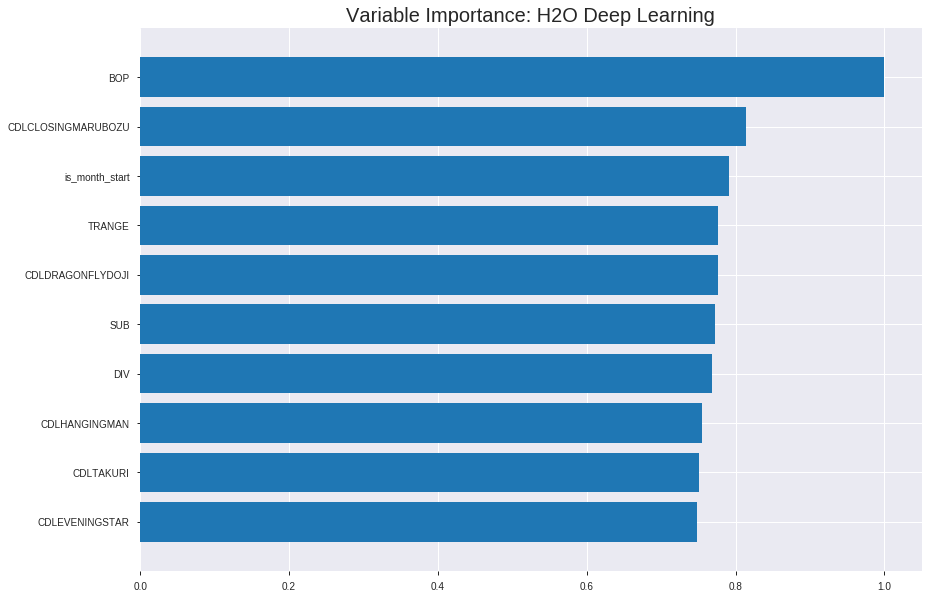

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_173129_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.29296826032527645
RMSE: 0.5412654250229516
LogLoss: 2.328714361397921
Mean Per-Class Error: 0.2836826347305389
AUC: 0.7728528656971771
pr_auc: 0.3158479959541831
Gini: 0.5457057313943543
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8910340371349499: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      509  326  0.3904   (326.0/835.0)
1      129  571  0.1843   (129.0/700.0)
Total  638  897  0.2964   (455.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.891034     0.715091  101
max f2                       0.0201365    0.829596  364
max f0point5                 0.999381     0.685587  4
max accuracy                 0.989613     0.714007  27
max precision                0.999993     0.740125  0
max recall                   1.60015e-05  1         399
max specificity              0.999993     0.850299  0
max absolute_mcc             0.961799     0.431598  61
max min_per_class_accuracy   0.993363     0.708982  21
max mean_per_class_accuracy  0.984106     0.716317  38

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 65.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   1                  2.19286   2.19286            1                1            1                           1                   0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   1                  1.90048   2.05138            0.866667         1            0.935484                    1                   0.0185714       0.0414286                  90.0476   105.138
    3        0.0306189                   1                  1.64464   1.91292            0.75             1            0.87234                     1                   0.0171429       0.0585714                  64.4643   91.2918
    4        0.0403909                   1                  1.90048   1.90991            0.866667         1            0.870968                    1                   0.0185714       0.0771429                  90.0476   90.9908
    5        0.0501629                   1                  1.4619    1.82263            0.666667         1            0.831169                    1                   0.0142857       0.0914286                  46.1905   82.2635
    6        0.100326                    1                  1.87959   1.85111            0.857143         1            0.844156                    1                   0.0942857       0.185714                   87.9592   85.1113
    7        0.150489                    1                  1.76568   1.82263            0.805195         1            0.831169                    1                   0.0885714       0.274286                   76.5677   82.2635
    8        0.2                         0.999998           1.50038   1.74286            0.684211         0.999999     0.794788                    1                   0.0742857       0.348571                   50.0376   74.2857
    9        0.300326                    0.999953           1.40969   1.63156            0.642857         0.999985     0.744035                    0.999995            0.141429        0.49                       40.9694   63.1562
    10       0.4                         0.999258           1.27558   1.54286            0.581699         0.999749     0.703583                    0.999933            0.127143        0.617143                   27.5584   54.2857
    11       0.500326                    0.988256           1.15339   1.46476            0.525974         0.995897     0.667969                    0.999124            0.115714        0.732857                   15.3386   46.476
    12       0.6                         0.841834           0.902941  1.37143            0.411765         0.942379     0.625407                    0.989697            0.09            0.822857                   -9.70588  37.1429
    13       0.699674                    0.226024           0.702288  1.2761             0.320261         0.554        0.581937                    0.927629            0.07            0.892857                   -29.7712  27.6104
    14       0.8                         0.0159142          0.583813  1.18929            0.266234         0.0851615    0.542345                    0.821977            0.0585714       0.951429                   -41.6187  18.9286
    15       0.899674                    9.08381e-05        0.315313  1.09246            0.143791         0.00337384   0.49819                     0.731285            0.0314286       0.982857                   -68.4687  9.24589
    16       1                           5.24142e-16        0.170872  1                  0.0779221        1.276



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2743877607299172
RMSE: 0.5238203515804987
LogLoss: 1.9331984010698302
Mean Per-Class Error: 0.2959943282523927
AUC: 0.7393602602331255
pr_auc: 0.6652026359053628
Gini: 0.478720520466251
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.003953521704876711: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      95   126  0.5701   (126.0/221.0)
1      21   196  0.0968   (21.0/217.0)
Total  116  322  0.3356   (147.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00395352   0.727273  293
max f2                       5.95292e-07  0.84441   382
max f0point5                 0.328364     0.690763  228
max accuracy                 0.328364     0.703196  228
max precision                1            0.8125    7
max recall                   8.13585e-11  1         399
max specificity              1            0.977376  0
max absolute_mcc             0.328364     0.414278  228
max min_per_class_accuracy   0.707217     0.683258  190
max mean_per_class_accuracy  0.328364     0.704006  228

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 54.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   1                  2.01843   2.01843            1                1            1                           1                   0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   1                  0         1.12135            0                1            0.555556                    1                   0               0.0230415                  -100      12.1352
    3        0.0319635                   1                  1.61475   1.29756            0.8              1            0.642857                    1                   0.0184332       0.0414747                  61.4747   29.7564
    4        0.0410959                   1                  2.01843   1.45776            1                1            0.722222                    1                   0.0184332       0.0599078                  101.843   45.7757
    5        0.0502283                   1                  1.51382   1.46795            0.75             1            0.727273                    1                   0.0138249       0.0737327                  51.3825   46.7951
    6        0.100457                    0.999996           1.74319   1.60557            0.863636         0.999999     0.795455                    0.999999            0.0875576       0.16129                    74.3192   60.5572
    7        0.150685                    0.999952           1.28446   1.49853            0.636364         0.999984     0.742424                    0.999994            0.0645161       0.225806                   28.4457   49.8534
    8        0.200913                    0.999763           1.65145   1.53676            0.818182         0.99988      0.761364                    0.999966            0.0829493       0.308756                   65.1445   53.6762
    9        0.30137                     0.996244           1.05509   1.3762             0.522727         0.998608     0.681818                    0.999513            0.105991        0.414747                   5.50901   37.6204
    10       0.399543                    0.974588           1.45515   1.3956             0.72093          0.988026     0.691429                    0.996691            0.142857        0.557604                   45.515    39.5602
    11       0.5                         0.704371           1.28446   1.37327            0.636364         0.8747       0.680365                    0.972181            0.129032        0.686636                   28.4457   37.3272
    12       0.600457                    0.219517           1.10096   1.32771            0.545455         0.501707     0.657795                    0.893471            0.110599        0.797235                   10.0964   32.7715
    13       0.69863                     0.00876199         0.751045  1.24668            0.372093         0.0761766    0.617647                    0.778622            0.0737327       0.870968                   -24.8955  24.6679
    14       0.799087                    0.000493675        0.550482  1.15916            0.272727         0.00297652   0.574286                    0.681112            0.0552995       0.926267                   -44.9518  15.9157
    15       0.899543                    1.1165e-05         0.458735  1.08094            0.227273         0.000117948  0.535533                    0.605062            0.0460829       0.97235                    -54.1265  8.09376
    16       1                           3.26049e-18        0.275241  1                  0.136364         1.36


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:31:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:31:43  5.984 sec         191 obs/sec       0.492508  1             756        0.57247          2.06433             -0.321105      0.67771         0.505053           1.23348          0.464495                         0.655189           3.6056                -0.717233        0.640803          0.615223             1.61475            0.452055
    2019-08-28 17:31:58  20.073 sec        217 obs/sec       2.40391   5             3690       0.531532         2.15584             -0.138914      0.747843        0.61514            1.91875          0.341368                         0.663325           4.93182               -0.76015         0.671539          0.642662             2.01843            0.378995
    2019-08-28 17:32:11  33.442 sec        221 obs/sec       4.22866   9             6491       0.566274         3.59933             -0.292662      0.701721        0.328275           1.91172          0.355049                         0.614043           2.86319               -0.50832         0.675167          0.646145             2.01843            0.374429
    2019-08-28 17:32:22  44.192 sec        222 obs/sec       5.65537   12            8681       0.493946         1.78048             0.0164629      0.792062        0.65047            2.0558           0.267752                         0.632649           3.94099               -0.601115        0.658507          0.629871             2.01843            0.381279
    2019-08-28 17:32:32  54.697 sec        224 obs/sec       7.04886   15            10820      0.510329         1.80523             -0.0498642     0.793316        0.672286           2.0558           0.299023                         0.616876           3.26674               -0.522269        0.705007          0.674003             2.01843            0.349315
    2019-08-28 17:32:46  1 min  8.147 sec  226 obs/sec       8.95179   19            13741      0.474133         1.32875             0.0937821      0.80922         0.583168           2.19286          0.287948                         0.589641           2.63117               -0.390823        0.70606           0.662014             1.61475            0.392694
    2019-08-28 17:32:59  1 min 21.171 sec  228 obs/sec       10.8417   23            16642      0.541265         2.32871             -0.181008      0.772853        0.315848           2.19286          0.296417                         0.52382            1.9332                -0.0976426       0.73936           0.665203             2.01843            0.335616
    2019-08-28 17:33:09  1 min 30.811 sec  230 obs/sec       12.2476   26            18800      0.542881         2.4568              -0.188071      0.723321        0.435554           2.19286          0.381759                         0.673271           6.91605               -0.813328        0.658611          0.629915             2.01843            0.424658
    2019-08-28 17:33:21

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0014679045577909648
CDLCLOSINGMARUBOZU        0.8134911060333252     0.8134911060333252   0.0011941273022687312
is_month_start            0.7918102145195007     0.7918102145195007   0.0011623018227986167
TRANGE                    0.777049720287323      0.777049720287323    0.0011406348260399558
CDLDRAGONFLYDOJI          0.7760727405548096     0.7760727405548096   0.00113920071303773
---                       ---                    ---                  ---
MINMAX_min_20             0.6028846502304077     0.6028846502304077   0.0008849771258954271
BBANDS_lowerband_12_1_4   0.6021201014518738     0.6021201014518738   0.0008838548412587637
MAVP_30_0                 0.5999045968055725     0.5999045968055725   0.000880602691890651
BBANDS_upperband_14_1_5   0.5988944172859192     0.5988944172859192   0.0008791198447695648
BBANDS_middleband_12_7_2  0.5862511992454529     0.5862511992454529   0.0008605608073828194


See the whole table with table.as_data_frame()


('accuracy', 0.6727272727272727)

('F1', 0.664)

('auc', 0.7106854838709677)

('logloss', 2.18114950310128)

('mean_per_class_error', 0.323252688172043)

('rmse', 0.5545626122301931)

('mse', 0.3075396908835755)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


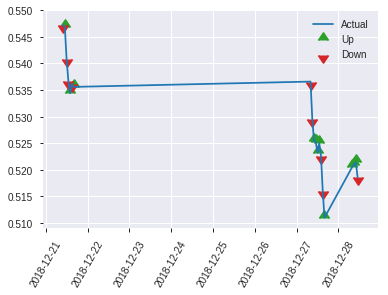


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3075396908835755
RMSE: 0.5545626122301931
LogLoss: 2.18114950310128
Mean Per-Class Error: 0.323252688172043
AUC: 0.7106854838709677
pr_auc: 0.5828583549408197
Gini: 0.4213709677419355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.01311501037173931: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   71   0.5726   (71.0/124.0)
1      13   83   0.1354   (13.0/96.0)
Total  66   154  0.3818   (84.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.013115     0.664     145
max f2                       2.21324e-05  0.815972  183
max f0point5                 0.849083     0.625     93
max accuracy                 0.849083     0.672727  93
max precision                1            0.8       1
max recall                   6.10619e-08  1         199
max specificity              1            0.983871  0
max absolute_mcc             0.645978     0.350678  103
max min_per_class_accuracy   0.791084     0.666667  96
max mean_per_class_accuracy  0.645978     0.676747  103

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 53.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   1                  1.52778   1.52778            0.666667         1            0.666667                    1                   0.0208333       0.0208333                  52.7778   52.7778
    2        0.0227273                   1                  2.29167   1.83333            1                1            0.8                         1                   0.0208333       0.0416667                  129.167   83.3333
    3        0.0318182                   1                  1.14583   1.6369             0.5              1            0.714286                    1                   0.0104167       0.0520833                  14.5833   63.6905
    4        0.0409091                   1                  2.29167   1.78241            1                1            0.777778                    1                   0.0208333       0.0729167                  129.167   78.2407
    5        0.05                        1                  1.14583   1.66667            0.5              1            0.727273                    1                   0.0104167       0.0833333                  14.5833   66.6667
    6        0.1                         0.999992           1.66667   1.66667            0.727273         0.999997     0.727273                    0.999999            0.0833333       0.166667                   66.6667   66.6667
    7        0.15                        0.999968           1.66667   1.66667            0.727273         0.999982     0.727273                    0.999993            0.0833333       0.25                       66.6667   66.6667
    8        0.2                         0.99961            1.875     1.71875            0.818182         0.99984      0.75                        0.999955            0.09375         0.34375                    87.5      71.875
    9        0.3                         0.996218           0.625     1.35417            0.272727         0.998463     0.590909                    0.999458            0.0625          0.40625                    -37.5     35.4167
    10       0.4                         0.917097           1.66667   1.43229            0.727273         0.971128     0.625                       0.992375            0.166667        0.572917                   66.6667   43.2292
    11       0.5                         0.694388           1.14583   1.375              0.5              0.839075     0.6                         0.961715            0.114583        0.6875                     14.5833   37.5
    12       0.6                         0.253788           0.729167  1.26736            0.318182         0.486859     0.55303                     0.882572            0.0729167       0.760417                   -27.0833  26.7361
    13       0.7                         0.0130318          1.04167   1.23512            0.454545         0.0809847    0.538961                    0.76806             0.104167        0.864583                   4.16667   23.5119
    14       0.8                         0.000539738        0.416667  1.13281            0.181818         0.00489642   0.494318                    0.672664            0.0416667       0.90625                    -58.3333  13.2812
    15       0.9                         5.78427e-06        0.729167  1.08796            0.318182         0.000132254  0.474747                    0.597939            0.0729167       0.979167                   -27.0833  8.7963
    16       1                           2.77207e-15        0.208333  1                  0.0909091        4.98684e-

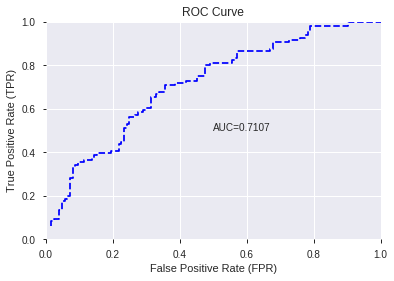

This function is available for GLM models only


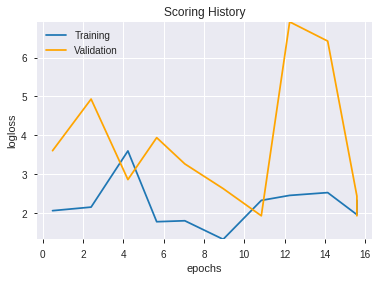

--2019-08-28 18:04:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  36.8MB/s    in 10s     

2019-08-28 18:04:35 (34.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_173129_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_173129_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_180530_model_7  0.735803  0.667515              0.329301  0.482426  0.232734
1  DeepLearning_grid_1_AutoML_20190828_180530_model_9  0.719926  0.609914              0.377352  0.459516  0.211155
2  DeepLearning_grid_1_AutoML_20190828_180530_model_8  0.718582  0.635442              0.383737  0.472166  0.222941
3               DeepLearning_1_AutoML_20190828_180530  0.710938  0.628310              0.398690  0.464160  0.215445
4  DeepLearning_grid_1_AutoML_20190828_180530_model_4  0.710769  0.788733              0.353831  0.508247  0.258315
5  DeepLearning_grid_1_AutoML_20190828_180530_model_5  0.708837  0.626502              0.375672  0.468596  0.219583
6  DeepLearning_grid_1_AutoML_20190828_180530_model_3  0.704553  0.853342              0.382056  0.495023  0.245047
7  DeepLearning_grid_1_AutoML_20190828_180530_model_6  0.694808  0.612395              0.378528  0.464521  0.215780
8  DeepLearning_grid_1_AutoML_20190828_180530_model_1  0.668599  1.093461              0.375840  0.535848  0.287133
9  DeepLearning_grid_1_AutoML_20190828_180530_model_2  0.645749  1.013322              0.451109  0.554203  0.307141

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.024187
1        CDLCLOSINGMARUBOZU             0.908752           0.908752    0.021980
2            CDLHARAMICROSS             0.874310           0.874310    0.021147
3                 CORREL_12             0.874274           0.874274    0.021146
4               CDLMARUBOZU             0.866191           0.866191    0.020951
5            CDLMORNINGSTAR             0.860107           0.860107    0.020804
6               CDLPIERCING             0.852931           0.852931    0.020630
7              STOCHF_fastk             0.849201           0.849201    0.020540
8                       DIV             0.846287           0.846287    0.020469
9            is_month_start             0.844110           0.844110    0.020417
10           CDLEVENINGSTAR             0.841805           0.841805    0.020361
11             is_month_end             0.841143           0.841143    0.020345
12        CDLSTALLEDPATTERN             0.837370           0.837370    0.020254
13                   TRANGE             0.836508           0.836508    0.020233
14            CDLHANGINGMAN             0.836252           0.836252    0.020227
15                CORREL_24             0.834672           0.834672    0.020188
16                     hour             0.834243           0.834243    0.020178
17                      SUB             0.834207           0.834207    0.020177
18            days_in_month             0.834172           0.834172    0.020176
19      CDLGAPSIDESIDEWHITE             0.833133           0.833133    0.020151
20       CDLMORNINGDOJISTAR             0.832298           0.832298    0.020131
21             CDLTASUKIGAP             0.828571           0.828571    0.020041
22             aroondown_24             0.827408           0.827408    0.020013
23               aroonup_30             0.826842           0.826842    0.019999
24                   ADX_24             0.823594           0.823594    0.019920
25  BBANDS_lowerband_14_7_4             0.821152           0.821152    0.019861
26        CDLGRAVESTONEDOJI             0.820869           0.820869    0.019855
27  BBANDS_lowerband_12_4_5             0.820629           0.820629    0.019849
28                    ADOSC             0.816139           0.816139    0.019740
29  BBANDS_lowerband_14_6_3             0.815988           0.815988    0.019736
30          CDLHOMINGPIGEON             0.815949           0.815949    0.019736
31   LINEARREG_INTERCEPT_30             0.815902           0.815902    0.019734
32  BBANDS_upperband_30_5_3             0.815020           0.815020    0.019713
33                CDLTAKURI             0.812916           0.812916    0.019662
34                CDLHAMMER             0.812895           0.812895    0.019662
35                   ROC_20             0.807089           0.807089    0.019521
36               CDL3INSIDE             0.806042           0.806042    0.019496
37                   MFI_12             0.805955           0.805955    0.019494
38               ROCR100_14             0.803494           0.803494    0.019434
39                   MFI_14             0.803026           0.803026    0.019423
40          CDLADVANCEBLOCK             0.802191           0.802191    0.019403
41  BBANDS_upperband_20_3_5             0.799361           0.799361    0.019334
42                  MA_12_6             0.798659           0.798659    0.019317
43             HT_TRENDMODE             0.794759           0.794759    0.019223
44              CDLDOJISTAR             0.792412           0.792412    0.019166
45  BBANDS_lowerband_14_5_5             0.788039           0.788039    0.019060
46         CDLDRAGONFLYDOJI             0.785464           0.785464    0.018998
47      CDLRISEFALL3METHODS             0.781267           0.781267    0.018897
48                MAVP_14_4             0.765331           0.765331    0.018511
49                C

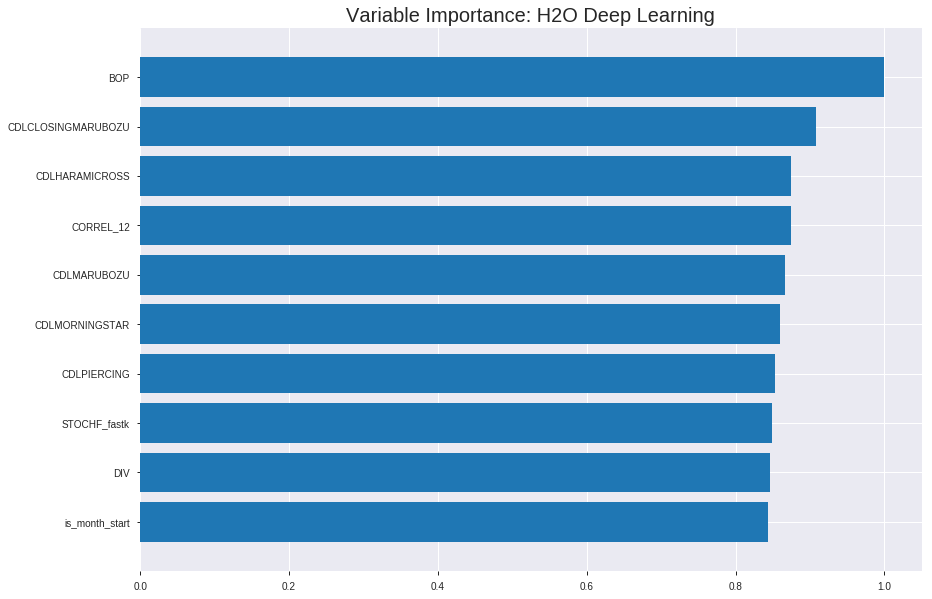

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_180530_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21564739827854745
RMSE: 0.46437850755450283
LogLoss: 0.6302359571530927
Mean Per-Class Error: 0.2647177074422583
AUC: 0.8044200171086399
pr_auc: 0.7472879143565307
Gini: 0.6088400342172797
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6207565711832503: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      500  335  0.4012   (335.0/835.0)
1      113  587  0.1614   (113.0/700.0)
Total  613  922  0.2919   (448.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.620757     0.723798  194
max f2                       0.0961812    0.830134  361
max f0point5                 0.758427     0.720158  128
max accuracy                 0.758427     0.739414  128
max precision                0.999218     1         0
max recall                   0.0160573    1         389
max specificity              0.999218     1         0
max absolute_mcc             0.753076     0.472932  130
max min_per_class_accuracy   0.716918     0.727143  148
max mean_per_class_accuracy  0.744431     0.735282  134

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 61.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.999021           2.19286   2.19286            1                0.999363   1                           0.999363            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.9979             2.04667   2.12212            0.933333         0.99853    0.967742                    0.99896             0.02            0.0428571                  104.667   112.212
    3        0.0306189                   0.994874           2.19286   2.1462             1                0.996564   0.978723                    0.998145            0.0228571       0.0657143                  119.286   114.62
    4        0.0403909                   0.991679           2.19286   2.15749            1                0.993185   0.983871                    0.996945            0.0214286       0.0871429                  119.286   115.749
    5        0.0501629                   0.986627           1.90048   2.10742            0.866667         0.989161   0.961039                    0.995428            0.0185714       0.105714                   90.0476   110.742
    6        0.100326                    0.956144           1.85111   1.97927            0.844156         0.972144   0.902597                    0.983786            0.0928571       0.198571                   85.1113   97.9267
    7        0.150489                    0.9257             1.68024   1.87959            0.766234         0.941557   0.857143                    0.96971             0.0842857       0.282857                   68.0241   87.9592
    8        0.2                         0.896358           1.6735    1.82857            0.763158         0.910295   0.833876                    0.955001            0.0828571       0.365714                   67.3496   82.8571
    9        0.300326                    0.834558           1.48089   1.71243            0.675325         0.865378   0.780911                    0.925062            0.148571        0.514286                   48.0891   71.2426
    10       0.4                         0.772038           1.30425   1.61071            0.594771         0.803486   0.734528                    0.894767            0.13            0.644286                   30.4248   61.0714
    11       0.500326                    0.698466           1.08219   1.50473            0.493506         0.735752   0.686198                    0.862881            0.108571        0.752857                   8.21892   50.4734
    12       0.6                         0.620436           0.845612  1.39524            0.385621         0.659156   0.636265                    0.829037            0.0842857       0.837143                   -15.4388  39.5238
    13       0.699674                    0.49972            0.558964  1.2761             0.254902         0.560662   0.581937                    0.790805            0.0557143       0.892857                   -44.1036  27.6104
    14       0.8                         0.303566           0.569573  1.1875             0.25974          0.413599   0.541531                    0.743501            0.0571429       0.95                       -43.0427  18.75
    15       0.899674                    0.0811737          0.386975  1.09881            0.176471         0.1925     0.501086                    0.682456            0.0385714       0.988571                   -61.3025  9.88104
    16       1                           0.000118686        0.113915  1                  0.0519481        0.0281446  0.456026                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21321513946834308
RMSE: 0.46175224901276124
LogLoss: 0.6326630004121878
Mean Per-Class Error: 0.30755676960610545
AUC: 0.7528202347936693
pr_auc: 0.7362682666426292
Gini: 0.5056404695873387
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26652219843705316: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      80   141  0.638    (141.0/221.0)
1      11   206  0.0507   (11.0/217.0)
Total  91   347  0.347    (152.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.266522     0.730496  315
max f2                       0.266522     0.847737  315
max f0point5                 0.808466     0.682819  105
max accuracy                 0.584245     0.691781  227
max precision                0.999412     1         0
max recall                   0.00902494   1         389
max specificity              0.999412     1         0
max absolute_mcc             0.479563     0.392073  275
max min_per_class_accuracy   0.636493     0.682028  198
max mean_per_class_accuracy  0.584245     0.692443  227

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 57.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.994338           2.01843   2.01843            1                0.997866   1                           0.997866            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.986126           2.01843   2.01843            1                0.990009   1                           0.994374            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.972753           2.01843   2.01843            1                0.977648   1                           0.988401            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.969405           1.51382   1.9063             0.75             0.9705     0.944444                    0.984423            0.0138249       0.078341                   51.3825   90.6298
    5        0.0502283                   0.955595           1.51382   1.83494            0.75             0.96351    0.909091                    0.98062             0.0138249       0.0921659                  51.3825   83.4939
    6        0.100457                    0.921795           1.3762    1.60557            0.681818         0.93811    0.795455                    0.959365            0.0691244       0.16129                    37.6204   60.5572
    7        0.150685                    0.880008           1.65145   1.62086            0.818182         0.901032   0.80303                     0.939921            0.0829493       0.24424                    65.1445   62.0863
    8        0.200913                    0.85439            1.5597    1.60557            0.772727         0.866483   0.795455                    0.921561            0.078341        0.322581                   55.9698   60.5572
    9        0.30137                     0.769014           1.28446   1.49853            0.636364         0.813949   0.742424                    0.885691            0.129032        0.451613                   28.4457   49.8534
    10       0.399543                    0.709639           1.12657   1.40714            0.55814          0.740371   0.697143                    0.849983            0.110599        0.562212                   12.6567   40.7136
    11       0.5                         0.633104           1.19271   1.36406            0.590909         0.671449   0.675799                    0.814113            0.119816        0.682028                   19.2711   36.4055
    12       0.600457                    0.570262           1.00922   1.30469            0.5              0.59803    0.646388                    0.777963            0.101382        0.78341                    0.921659  30.4691
    13       0.69863                     0.477505           0.985746  1.25987            0.488372         0.52656    0.624183                    0.742635            0.0967742       0.880184                   -1.42536  25.9872
    14       0.799087                    0.257289           0.688102  1.18799            0.340909         0.376842   0.588571                    0.696649            0.0691244       0.949309                   -31.1898  18.7992
    15       0.899543                    0.0792939          0.183494  1.07581            0.0909091        0.17014    0.532995                    0.637851            0.0184332       0.967742                   -81.6506  7.58146
    16       1                           0.000725461        0.321114  1                  0.159091         0.0274509  0.495434                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:10:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:10:35  5.412 sec         209 obs/sec       0.608469  1             934        0.558018         1.17035             -0.255247      0.753653        0.711443           2.19286          0.355049                         0.596437           1.3635                -0.423068        0.74866           0.733467             2.01843            0.333333
    2019-08-28 18:10:46  15.663 sec        401 obs/sec       3.62345   6             5562       0.464379         0.630236            0.130686       0.80442         0.747288           2.19286          0.291857                         0.461752           0.632663              0.147068         0.75282           0.736268             2.01843            0.347032
    2019-08-28 18:10:56  26.033 sec        433 obs/sec       6.59153   11            10118      0.414156         0.514818            0.308553       0.824034        0.795239           2.19286          0.260586                         0.478122           0.697443              0.0855213        0.726161          0.713605             2.01843            0.356164
    2019-08-28 18:11:06  36.132 sec        479 obs/sec       10.1629   17            15600      0.400995         0.489752            0.351799       0.847234        0.79505            2.19286          0.22671                          0.472416           0.707674              0.107216         0.759149          0.731126             2.01843            0.287671
    2019-08-28 18:11:16  46.039 sec        505 obs/sec       13.6984   23            21027      0.394083         0.483745            0.373952       0.864459        0.763811           2.19286          0.22215                          0.48201            0.835774              0.0705881        0.753832          0.721869             2.01843            0.344749
    2019-08-28 18:11:26  55.910 sec        524 obs/sec       17.2847   29            26532      0.416655         0.569069            0.300182       0.876871        0.845822           2.19286          0.19544                          0.534402           1.09382               -0.142438        0.740799          0.707645             1.61475            0.310502
    2019-08-28 18:11:36  1 min  6.024 sec  536 obs/sec       20.8971   35            32077      0.418925         0.577173            0.292534       0.878417        0.679052           2.19286          0.208469                         0.49569            0.994417              0.0170838        0.736608          0.687569             2.01843            0.310502
    2019-08-28 18:11:37  1 min  6.949 sec  535 obs/sec       20.8971   35            32077      0.464379         0.630236            0.130686       0.80442         0.747288           2.19286          0.291857                         0.461752           0.632663              0.147068         0.75282           0.736268             2.01843            0.347032

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.024187250057337836
CDLCLOSINGMARUBOZU       0.90875244140625       0.90875244140625     0.021980222540509218
CDLHARAMICROSS           0.8743100166320801     0.8743100166320801   0.021147154999915322
CORREL_12                0.8742735385894775     0.8742735385894775   0.021146272696377293
CDLMARUBOZU              0.8661905527114868     0.8661905527114868   0.020950767495736402
---                      ---                    ---                  ---
BBANDS_lowerband_14_5_5  0.7880386710166931     0.7880386710166931   0.019060488390732943
CDLDRAGONFLYDOJI         0.785464346408844      0.785464346408844    0.018998222557714137
CDLRISEFALL3METHODS      0.7812672257423401     0.7812672257423401   0.018896705750632587
MAVP_14_4                0.7653307318687439     0.7653307318687439   0.018511245788274684
CORREL_20                0.7651699185371399     0.7651699185371399   0.018507356156010624


See the whole table with table.as_data_frame()


('accuracy', 0.6772727272727272)

('F1', 0.6751054852320676)

('auc', 0.7358030913978494)

('logloss', 0.667514784789816)

('mean_per_class_error', 0.31619623655913975)

('rmse', 0.4824256391592135)

('mse', 0.23273449731817566)

deeplearning prediction progress: |███████████████████████████████████████| 100%


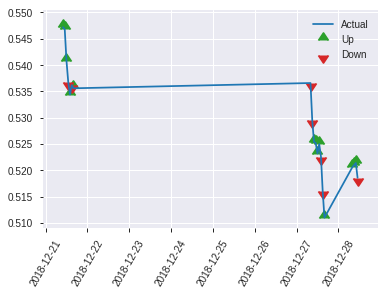


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23273449731817566
RMSE: 0.4824256391592135
LogLoss: 0.667514784789816
Mean Per-Class Error: 0.31619623655913975
AUC: 0.7358030913978494
pr_auc: 0.6839686008084893
Gini: 0.47160618279569877
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5200666480898734: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   61   0.4919   (61.0/124.0)
1      16   80   0.1667   (16.0/96.0)
Total  79   141  0.35     (77.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520067     0.675105  140
max f2                       0.245465     0.823009  180
max f0point5                 0.709785     0.630952  80
max accuracy                 0.709785     0.677273  80
max precision                0.997877     1         0
max recall                   0.0556172    1         200
max specificity              0.997877     1         0
max absolute_mcc             0.57489      0.367608  123
max min_per_class_accuracy   0.631932     0.66129   105
max mean_per_class_accuracy  0.57489      0.683804  123

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 57.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.997431           2.29167   2.29167            1                0.997759   1                           0.997759            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.995687           2.29167   2.29167            1                0.996415   1                           0.997222            0.0208333       0.0520833                  129.167   129.167
    3        0.0318182                   0.991653           2.29167   2.29167            1                0.994342   1                           0.996399            0.0208333       0.0729167                  129.167   129.167
    4        0.0409091                   0.982662           1.14583   2.03704            0.5              0.988601   0.888889                    0.994666            0.0104167       0.0833333                  14.5833   103.704
    5        0.05                        0.975604           2.29167   2.08333            1                0.979094   0.909091                    0.991835            0.0208333       0.104167                   129.167   108.333
    6        0.1                         0.926599           2.08333   2.08333            0.909091         0.952566   0.909091                    0.9722              0.104167        0.208333                   108.333   108.333
    7        0.15                        0.890823           1.45833   1.875              0.636364         0.913345   0.818182                    0.952582            0.0729167       0.28125                    45.8333   87.5
    8        0.2                         0.850611           1.04167   1.66667            0.454545         0.872866   0.727273                    0.932653            0.0520833       0.333333                   4.16667   66.6667
    9        0.3                         0.762394           1.14583   1.49306            0.5              0.80251    0.651515                    0.889272            0.114583        0.447917                   14.5833   49.3056
    10       0.4                         0.686362           1.25      1.43229            0.545455         0.725694   0.625                       0.848377            0.125           0.572917                   25        43.2292
    11       0.5                         0.621582           1.04167   1.35417            0.454545         0.653848   0.590909                    0.809471            0.104167        0.677083                   4.16667   35.4167
    12       0.6                         0.529944           1.14583   1.31944            0.5              0.583521   0.575758                    0.771813            0.114583        0.791667                   14.5833   31.9444
    13       0.7                         0.463441           0.833333  1.25               0.363636         0.507714   0.545455                    0.734085            0.0833333       0.875                      -16.6667  25
    14       0.8                         0.310768           0.520833  1.15885            0.227273         0.398546   0.505682                    0.692142            0.0520833       0.927083                   -47.9167  15.8854
    15       0.9                         0.0937989          0.625     1.09954            0.272727         0.183822   0.479798                    0.635662            0.0625          0.989583                   -37.5     9.9537
    16       1                           5.68794e-05        0.104167  1                  0.0454545        0.0206778  0.436364                    0.574164

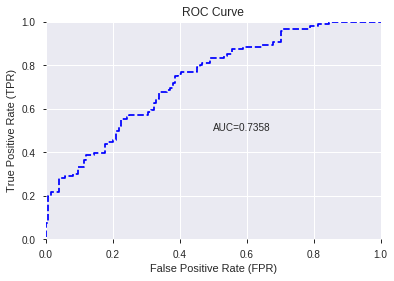

This function is available for GLM models only


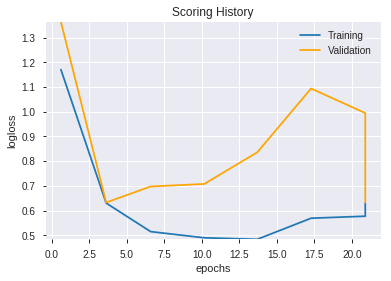

--2019-08-28 18:13:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_180530_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_180530_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLHARAMICROSS',
 'CORREL_12',
 'CDLMARUBOZU',
 'CDLMORNINGSTAR',
 'CDLPIERCING',
 'STOCHF_fastk',
 'DIV',
 'is_month_start',
 'CDLEVENINGSTAR',
 'is_month_end',
 'CDLSTALLEDPATTERN',
 'TRANGE',
 'CDLHANGINGMAN',
 'CORREL_24',
 'hour',
 'SUB',
 'days_in_month',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'aroondown_24',
 'aroonup_30',
 'ADX_24',
 'BBANDS_lowerband_14_7_4',
 'CDLGRAVESTONEDOJI',
 'BBANDS_lowerband_12_4_5',
 'ADOSC',
 'BBANDS_lowerband_14_6_3',
 'CDLHOMINGPIGEON',
 'LINEARREG_INTERCEPT_30',
 'BBANDS_upperband_30_5_3',
 'CDLTAKURI',
 'CDLHAMMER',
 'ROC_20',
 'CDL3INSIDE',
 'MFI_12',
 'ROCR100_14',
 'MFI_14',
 'CDLADVANCEBLOCK',
 'BBANDS_upperband_20_3_5',
 'MA_12_6',
 'HT_TRENDMODE',
 'CDLDOJISTAR',
 'BBANDS_lowerband_14_5_5',
 'CDLDRAGONFLYDOJI',
 'CDLRISEFALL3METHODS',
 'MAVP_14_4',
 'CORREL_20']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_181452_model_1  0.734375  0.590214              0.317876  0.451603  0.203946

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.605985           1.000000    0.172929
1        CDLCLOSINGMARUBOZU             0.236791           0.390753    0.067572
2                       SUB             0.212186           0.350150    0.060551
3                       DIV             0.185406           0.305958    0.052909
4                      hour             0.154030           0.254181    0.043955
5              STOCHF_fastk             0.152948           0.252396    0.043646
6            is_month_start             0.130235           0.214914    0.037165
7                    MFI_12             0.128544           0.212123    0.036682
8              aroondown_24             0.112170           0.185104    0.032010
9                 CDLTAKURI             0.099217           0.163728    0.028313
10                CDLHAMMER             0.096922           0.159941    0.027658
11                CORREL_12             0.096393           0.159067    0.027507
12      CDLGAPSIDESIDEWHITE             0.093528           0.154340    0.026690
13            days_in_month             0.090509           0.149359    0.025828
14                    ADOSC             0.089088           0.147014    0.025423
15           CDLEVENINGSTAR             0.074141           0.122347    0.021157
16              CDLMARUBOZU             0.068529           0.113087    0.019556
17        CDLSTALLEDPATTERN             0.065771           0.108536    0.018769
18            CDLHANGINGMAN             0.062821           0.103667    0.017927
19              CDLPIERCING             0.052521           0.086670    0.014988
20                   ROC_20             0.051031           0.084212    0.014563
21       CDLMORNINGDOJISTAR             0.048990           0.080844    0.013980
22              CDLDOJISTAR             0.045590           0.075233    0.013010
23               aroonup_30             0.040839           0.067392    0.011654
24  BBANDS_upperband_20_3_5             0.040311           0.066522    0.011504
25                   TRANGE             0.038985           0.064333    0.011125
26                   MFI_14             0.037576           0.062008    0.010723
27           CDLHARAMICROSS             0.036306           0.059912    0.010360
28      CDLRISEFALL3METHODS             0.033991           0.056092    0.009700
29                CORREL_24             0.033862           0.055879    0.009663
30  BBANDS_upperband_30_5_3             0.027303           0.045055    0.007791
31             is_month_end             0.026383           0.043538    0.007529
32  BBANDS_lowerband_12_4_5             0.025111           0.041439    0.007166
33         CDLDRAGONFLYDOJI             0.024243           0.040006    0.006918
34           CDLMORNINGSTAR             0.022034           0.036361    0.006288
35        CDLGRAVESTONEDOJI             0.021790           0.035958    0.006218
36                CORREL_20             0.020166           0.033277    0.005755
37  BBANDS_lowerband_14_7_4             0.017390           0.028697    0.004963
38  BBANDS_lowerband_14_6_3             0.015965           0.026345    0.004556
39               ROCR100_14             0.013923           0.022976    0.003973
40  BBANDS_lowerband_14_5_5             0.011293           0.018636    0.003223
41                MAVP_14_4             0.010996           0.018146    0.003138
42          CDLHOMINGPIGEON             0.010446           0.017237    0.002981
43          CDLADVANCEBLOCK             0.009497           0.015672    0.002710
44   LINEARREG_INTERCEPT_30             0.008876           0.014647    0.002533
45               CDL3INSIDE             0.007933           0.013091    0.002264
46                   ADX_24             0.005643           0.009312    0.001610
47             HT_TRENDMODE             0.004944           0.008158    0.001411
48             CDLTASUKIGAP             0.002874           0.004743    0.000820
49                 

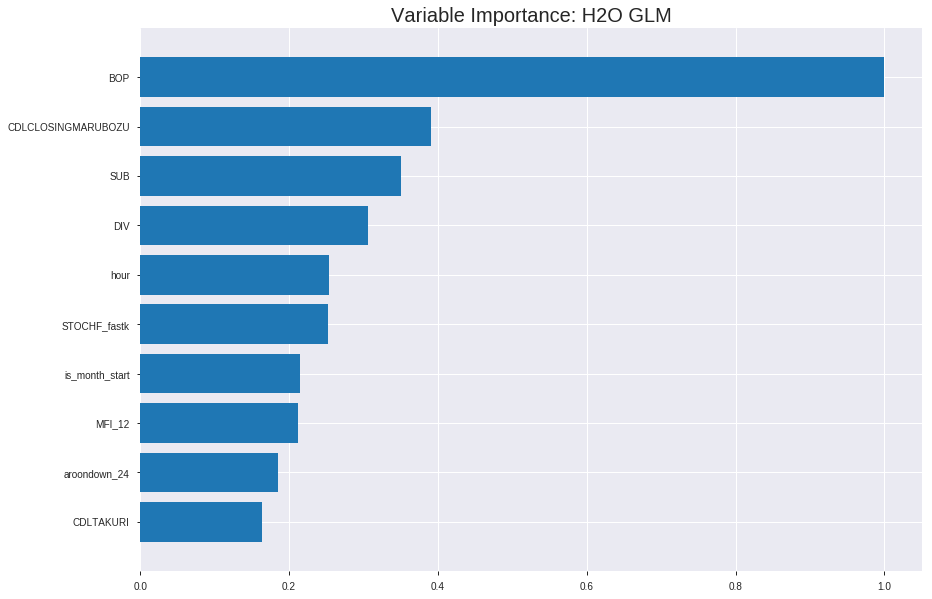

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_181452_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.185297763643473
RMSE: 0.4304622673864377
LogLoss: 0.5507093847706402
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2116.073526703686
Residual deviance: 1690.6778112458655
AIC: 1792.6778112458655
AUC: 0.7944867408041061
pr_auc: 0.7602656376665261
Gini: 0.5889734816082122
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40837446578223435: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      528  307  0.3677   (307.0/835.0)
1      131  569  0.1871   (131.0/700.0)
Total  659  876  0.2853   (438.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408374     0.722081  230
max f2                       0.200334     0.826628  328
max f0point5                 0.569708     0.703919  151
max accuracy                 0.435664     0.723127  216
max precision                0.944174     1         0
max recall                   0.0154651    1         398
max specificity              0.944174     1         0
max absolute_mcc             0.435664     0.454325  216
max min_per_class_accuracy   0.4699       0.721429  200
max mean_per_class_accuracy  0.435664     0.727609  216

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.906127           2.19286   2.19286            1                0.921723   1                           0.921723            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.882937           2.04667   2.12212            0.933333         0.893404   0.967742                    0.90802             0.02            0.0428571                  104.667   112.212
    3        0.0306189                   0.857159           2.0558    2.09954            0.9375           0.870395   0.957447                    0.895212            0.0214286       0.0642857                  105.58    109.954
    4        0.0403909                   0.836701           1.90048   2.05138            0.866667         0.843827   0.935484                    0.88278             0.0185714       0.0828571                  90.0476   105.138
    5        0.0501629                   0.820583           1.75429   1.99351            0.8              0.828813   0.909091                    0.872267            0.0171429       0.1                        75.4286   99.3506
    6        0.100326                    0.758581           1.87959   1.93655            0.857143         0.787665   0.883117                    0.829966            0.0942857       0.194286                   87.9592   93.6549
    7        0.150489                    0.707435           1.70872   1.86061            0.779221         0.728771   0.848485                    0.796234            0.0857143       0.28                       70.872    86.0606
    8        0.2                         0.659794           1.81776   1.85               0.828947         0.683144   0.843648                    0.768238            0.09            0.37                       81.7763   85
    9        0.300326                    0.593124           1.32426   1.67437            0.603896         0.626543   0.763557                    0.720904            0.132857        0.502857                   32.4258   67.4372
    10       0.4                         0.525979           1.26125   1.57143            0.575163         0.559475   0.716612                    0.680678            0.125714        0.628571                   26.1251   57.1429
    11       0.500326                    0.459173           1.09643   1.47618            0.5              0.490642   0.673177                    0.642572            0.11            0.738571                   9.64286   47.6181
    12       0.6                         0.387443           0.945938  1.3881             0.431373         0.42242    0.633008                    0.606               0.0942857       0.832857                   -5.40616  38.8095
    13       0.699674                    0.320128           0.573296  1.27202            0.261438         0.35496    0.580074                    0.570237            0.0571429       0.89                       -42.6704  27.202
    14       0.8                         0.249203           0.526855  1.17857            0.24026          0.284681   0.537459                    0.534426            0.0528571       0.942857                   -47.3145  17.8571
    15       0.899674                    0.143491           0.372642  1.08928            0.169935         0.197029   0.496741                    0.497046            0.0371429       0.98                       -62.7358  8.92831
    16       1                           0.0086863          0.199351  1                  0.0909091        0.0881775  0.456026                    0.456



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19817226079253544
RMSE: 0.4451654308148101
LogLoss: 0.5882128859437529
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 609.8925503857407
Residual deviance: 515.2744880867276
AIC: 617.2744880867276
AUC: 0.7729841316179077
pr_auc: 0.7704960227976118
Gini: 0.5459682632358154
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3115552685298979: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  115  0.5204   (115.0/221.0)
1      25   192  0.1152   (25.0/217.0)
Total  131  307  0.3196   (140.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311555     0.732824  280
max f2                       0.0984453    0.8405    375
max f0point5                 0.563938     0.717131  123
max accuracy                 0.453501     0.710046  205
max precision                0.939445     1         0
max recall                   0.00421642   1         399
max specificity              0.939445     1         0
max absolute_mcc             0.450179     0.42084   207
max min_per_class_accuracy   0.461277     0.692308  199
max mean_per_class_accuracy  0.450179     0.710251  207

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 44.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.899005           2.01843   2.01843            1                0.922085   1                           0.922085            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.829735           2.01843   2.01843            1                0.858103   1                           0.893648            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.803696           2.01843   2.01843            1                0.816202   1                           0.865989            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.785311           1.00922   1.79416            0.5              0.788769   0.888889                    0.848829            0.00921659      0.0737327                  0.921659  79.4163
    5        0.0502283                   0.770465           2.01843   1.83494            1                0.779575   0.909091                    0.836237            0.0184332       0.0921659                  101.843   83.4939
    6        0.100457                    0.71585            1.74319   1.78907            0.863636         0.742563   0.886364                    0.7894              0.0875576       0.179724                   74.3192   78.9066
    7        0.150685                    0.672086           1.74319   1.77377            0.863636         0.690408   0.878788                    0.756403            0.0875576       0.267281                   74.3192   77.3775
    8        0.200913                    0.63154            1.74319   1.76613            0.863636         0.647223   0.875                       0.729108            0.0875576       0.354839                   74.3192   76.6129
    9        0.30137                     0.565448           1.33033   1.62086            0.659091         0.601251   0.80303                     0.686489            0.133641        0.488479                   33.0331   62.0863
    10       0.399543                    0.508772           1.03269   1.47634            0.511628         0.537225   0.731429                    0.649813            0.101382        0.589862                   3.26867   47.634
    11       0.5                         0.461211           1.05509   1.39171            0.522727         0.485833   0.689498                    0.616867            0.105991        0.695853                   5.50901   39.1705
    12       0.600457                    0.382462           1.00922   1.32771            0.5              0.423396   0.657795                    0.584499            0.101382        0.797235                   0.921659  32.7715
    13       0.69863                     0.311673           0.844926  1.25987            0.418605         0.347844   0.624183                    0.551244            0.0829493       0.880184                   -15.5074  25.9872
    14       0.799087                    0.239884           0.504608  1.16492            0.25             0.276622   0.577143                    0.51672             0.0506912       0.930876                   -49.5392  16.4924
    15       0.899543                    0.135863           0.321114  1.07069            0.159091         0.194143   0.530457                    0.480696            0.0322581       0.963134                   -67.8886  7.06917
    16       1                           0.00421642         0.366988  1                  0.181818         0.0847852  0.495434                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 18:14:53  0.000 sec   2            20        51            1.3653            1.38046
    2019-08-28 18:14:53  0.079 sec   4            13        51            1.35784           1.37375
    2019-08-28 18:14:53  0.129 sec   6            7.9       51            1.34669           1.36379
    2019-08-28 18:14:53  0.161 sec   8            4.9       51            1.33068           1.34958
    2019-08-28 18:14:53  0.180 sec   10           3         51            1.30891           1.33047
    2019-08-28 18:14:53  0.202 sec   12           1.9       51            1.2814            1.30666
    2019-08-28 18:14:53  0.230 sec   14           1.2       51            1.24962           1.27968
    2019-08-28 18:14:53  0.262 sec   16           0.73      51            1.21631           1.2521
    2019-08-28 18:14:53  0.289 sec   18           0.45      51            1.18469           1.2268
    2019-08-28 18:14:53  0.319 sec   20           0.28      51            1.15738           1.20604
    2019-08-28 18:14:53  0.343 sec   22           0.17      51            1.13575           1.19093
    2019-08-28 18:14:53  0.376 sec   24           0.11      51            1.11983           1.18151
    2019-08-28 18:14:53  0.405 sec   26           0.067     51            1.1088            1.17704
    2019-08-28 18:14:53  0.438 sec   28           0.042     51            1.10142           1.17643
    2019-08-28 18:14:53  0.463 sec   30           0.026     51            1.09652           1.17855
    2019-08-28 18:14:53  0.491 sec   32           0.016     51            1.09321           1.18226
    2019-08-28 18:14:53  0.515 sec   34           0.01      51            1.09088           1.1865
    2019-08-28 18:14:53  0.543 sec   36           0.0062    51            1.08918           1.19034
    2019-08-28 18:14:53  0.576 sec   38           0.0039    51            1.0879            1.19309

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6863636363636364)

('F1', 0.6755555555555556)

('auc', 0.734375)

('logloss', 0.5902142260894145)

('mean_per_class_error', 0.3178763440860215)

('rmse', 0.451603427710026)

('mse', 0.20394565591944466)

glm prediction progress: |████████████████████████████████████████████████| 100%


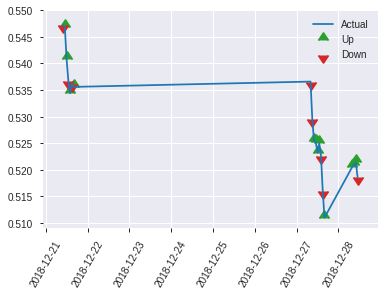


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20394565591944466
RMSE: 0.451603427710026
LogLoss: 0.5902142260894145
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 301.7551983180251
Residual deviance: 259.6942594793424
AIC: 361.6942594793424
AUC: 0.734375
pr_auc: 0.6803315637954087
Gini: 0.46875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4062548130077479: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   53   0.4274   (53.0/124.0)
1      20   76   0.2083   (20.0/96.0)
Total  91   129  0.3318   (73.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406255     0.675556  128
max f2                       0.186187     0.817391  190
max f0point5                 0.648402     0.643939  41
max accuracy                 0.519403     0.686364  84
max precision                0.905287     1         0
max recall                   0.0594433    1         212
max specificity              0.905287     1         0
max absolute_mcc             0.406255     0.366798  128
max min_per_class_accuracy   0.461467     0.645833  103
max mean_per_class_accuracy  0.406255     0.682124  128

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 45.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.884018           2.29167   2.29167            1                0.892932   1                           0.892932            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.864554           2.29167   2.29167            1                0.870025   1                           0.883769            0.0208333       0.0520833                  129.167   129.167
    3        0.0318182                   0.858767           2.29167   2.29167            1                0.863132   1                           0.877873            0.0208333       0.0729167                  129.167   129.167
    4        0.0409091                   0.832784           2.29167   2.29167            1                0.845185   1                           0.870609            0.0208333       0.09375                    129.167   129.167
    5        0.05                        0.810721           1.14583   2.08333            0.5              0.82507    0.909091                    0.862329            0.0104167       0.104167                   14.5833   108.333
    6        0.1                         0.735569           1.66667   1.875              0.727273         0.77587    0.818182                    0.8191              0.0833333       0.1875                     66.6667   87.5
    7        0.15                        0.685752           1.66667   1.80556            0.727273         0.708294   0.787879                    0.782164            0.0833333       0.270833                   66.6667   80.5556
    8        0.2                         0.640027           1.875     1.82292            0.818182         0.664483   0.795455                    0.752744            0.09375         0.364583                   87.5      82.2917
    9        0.3                         0.571613           0.9375    1.52778            0.409091         0.601343   0.666667                    0.702277            0.09375         0.458333                   -6.25     52.7778
    10       0.4                         0.506514           1.35417   1.48438            0.590909         0.543285   0.647727                    0.662529            0.135417        0.59375                    35.4167   48.4375
    11       0.5                         0.453831           0.625     1.3125             0.272727         0.476487   0.572727                    0.625321            0.0625          0.65625                    -37.5     31.25
    12       0.6                         0.399568           1.35417   1.31944            0.590909         0.424749   0.575758                    0.591892            0.135417        0.791667                   35.4167   31.9444
    13       0.7                         0.342934           0.520833  1.20536            0.227273         0.366783   0.525974                    0.559734            0.0520833       0.84375                    -47.9167  20.5357
    14       0.8                         0.274685           0.9375    1.17188            0.409091         0.310989   0.511364                    0.528641            0.09375         0.9375                     -6.25     17.1875
    15       0.9                         0.143693           0.416667  1.08796            0.181818         0.197426   0.474747                    0.491839            0.0416667       0.979167                   -58.3333  8.7963
    16       1                           0.00863098         0.208333  1                  0.0909091        0.0838509  0.436364                    0.451

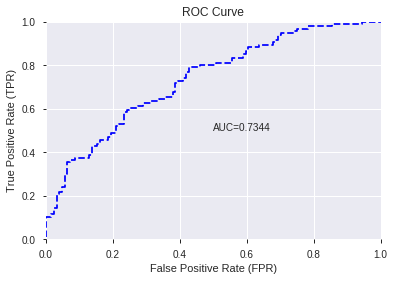

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


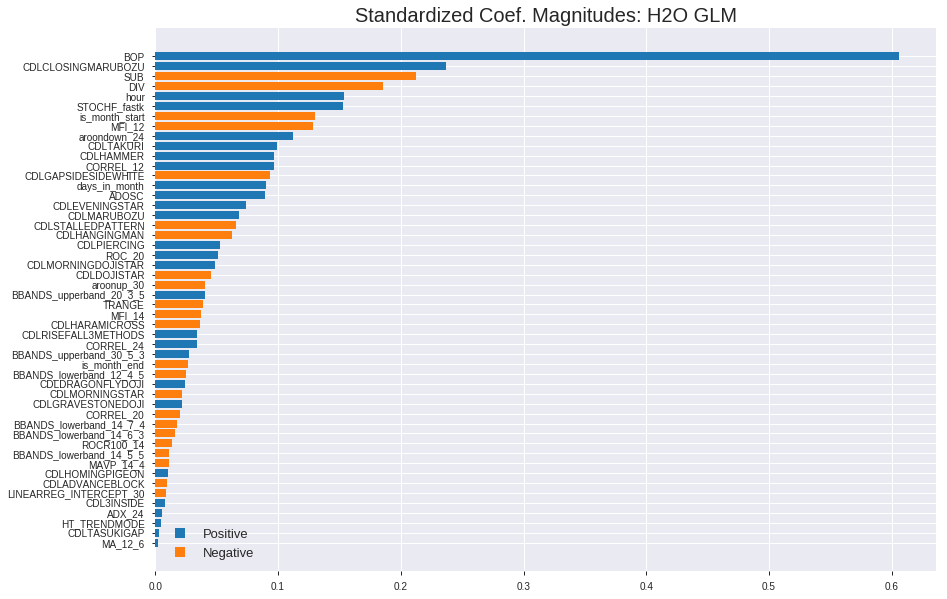

'log_likelihood'
--2019-08-28 18:15:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_181452_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_181452_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'DIV',
 'hour',
 'STOCHF_fastk',
 'is_month_start',
 'MFI_12',
 'aroondown_24',
 'CDLTAKURI',
 'CDLHAMMER',
 'CORREL_12',
 'CDLGAPSIDESIDEWHITE',
 'days_in_month',
 'ADOSC',
 'CDLEVENINGSTAR',
 'CDLMARUBOZU',
 'CDLSTALLEDPATTERN',
 'CDLHANGINGMAN',
 'CDLPIERCING',
 'ROC_20',
 'CDLMORNINGDOJISTAR',
 'CDLDOJISTAR',
 'aroonup_30',
 'BBANDS_upperband_20_3_5',
 'TRANGE',
 'MFI_14',
 'CDLHARAMICROSS',
 'CDLRISEFALL3METHODS',
 'CORREL_24',
 'BBANDS_upperband_30_5_3',
 'is_month_end',
 'BBANDS_lowerband_12_4_5',
 'CDLDRAGONFLYDOJI',
 'CDLMORNINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CORREL_20',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lowerband_14_6_3',
 'ROCR100_14',
 'BBANDS_lowerband_14_5_5',
 'MAVP_14_4',
 'CDLHOMINGPIGEON',
 'CDLADVANCEBLOCK',
 'LINEARREG_INTERCEPT_30',
 'CDL3INSIDE',
 'ADX_24',
 'HT_TRENDMODE',
 'CDLTASUKIGAP',
 'MA_12_6']

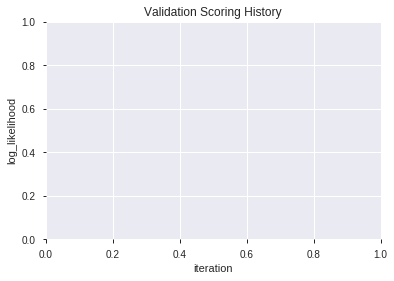

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_181602_model_6  0.733535  0.597135              0.331653  0.456235  0.208150
1               XGBoost_2_AutoML_20190828_181602  0.732779  0.596625              0.366431  0.455836  0.207787
2  XGBoost_grid_1_AutoML_20190828_181602_model_3  0.731015  0.596512              0.374496  0.455523  0.207501
3               XGBoost_3_AutoML_20190828_181602  0.730847  0.594229              0.341230  0.454667  0.206723
4  XGBoost_grid_1_AutoML_20190828_181602_model_2  0.730259  0.596654              0.291835  0.454490  0.206561
5  XGBoost_grid_1_AutoML_20190828_181602_model_4  0.729503  0.599834              0.321741  0.456327  0.208234
6  XGBoost_grid_1_AutoML_20190828_181602_model_1  0.722194  0.605234              0.363071  0.459590  0.211223
7  XGBoost_grid_1_AutoML_20190828_181602_model_7  0.717574  0.608572              0.338374  0.461871  0.213324
8  XGBoost_grid_1_AutoML_20190828_181602_model_5  0.714634  0.624993              0.382560  0.466423  0.217550
9               XGBoost_1_AutoML_20190828_181602  0.707241  0.617915              0.391129  0.466079  0.217230

variable  relative_importance  scaled_importance  percentage
0                       BOP          2235.073975           1.000000    0.235623
1              STOCHF_fastk           734.729004           0.328727    0.077456
2                       DIV           714.278076           0.319577    0.075300
3                    TRANGE           575.022278           0.257272    0.060619
4                    ROC_20           481.653534           0.215498    0.050776
5                    MFI_14           388.750702           0.173932    0.040982
6                       SUB           359.931396           0.161038    0.037944
7                    MFI_12           350.113831           0.156645    0.036909
8                      hour           339.298737           0.151806    0.035769
9                     ADOSC           309.401154           0.138430    0.032617
10               ROCR100_14           286.340881           0.128112    0.030186
11                CORREL_20           275.413025           0.123223    0.029034
12                CORREL_24           255.463562           0.114298    0.026931
13             aroondown_24           244.994965           0.109614    0.025828
14                   ADX_24           239.890274           0.107330    0.025289
15                CORREL_12           217.678879           0.097392    0.022948
16       CDLCLOSINGMARUBOZU           176.282501           0.078871    0.018584
17               aroonup_30           169.429291           0.075805    0.017861
18  BBANDS_upperband_20_3_5           169.349915           0.075769    0.017853
19  BBANDS_lowerband_14_5_5           130.235840           0.058269    0.013730
20  BBANDS_lowerband_12_4_5           129.385452           0.057889    0.013640
21   LINEARREG_INTERCEPT_30           125.199974           0.056016    0.013199
22                MAVP_14_4            90.971367           0.040702    0.009590
23            days_in_month            83.601921           0.037405    0.008813
24  BBANDS_upperband_30_5_3            82.172241           0.036765    0.008663
25                  MA_12_6            57.312523           0.025642    0.006042
26  BBANDS_lowerband_14_7_4            57.283947           0.025630    0.006039
27  BBANDS_lowerband_14_6_3            55.130165           0.024666    0.005812
28           is_month_start            46.113907           0.020632    0.004861
29                CDLHAMMER            34.496765           0.015434    0.003637
30                CDLTAKURI            29.923134           0.013388    0.003155
31         CDLDRAGONFLYDOJI            14.212467           0.006359    0.001498
32              CDLDOJISTAR             9.201274           0.004117    0.000970
33             HT_TRENDMODE             8.570591           0.003835    0.000904
34             is_month_end             5.453728           0.002440    0.000575
35        CDLGRAVESTONEDOJI             3.453319           0.001545    0.000364

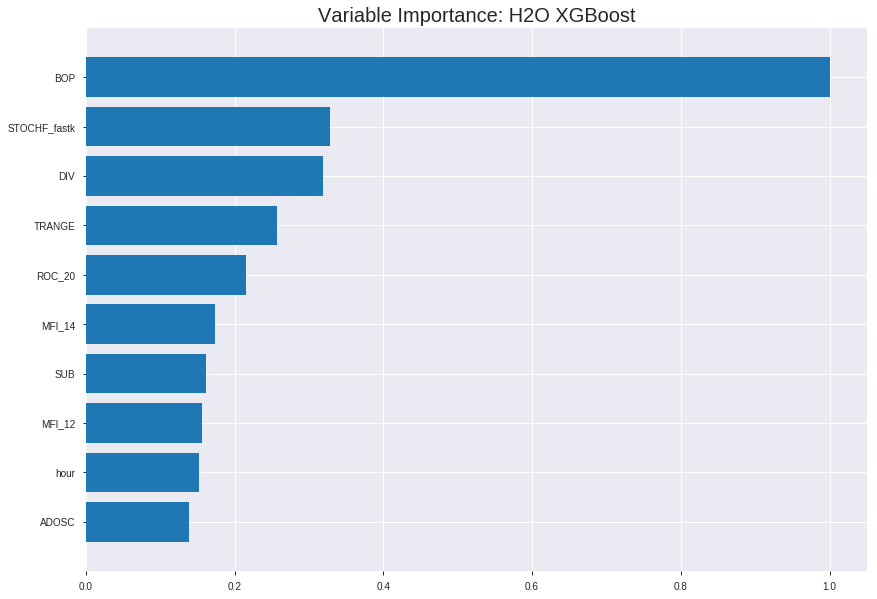

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_181602_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12823919823492855
RMSE: 0.3581050100667799
LogLoss: 0.4148473254804728
Mean Per-Class Error: 0.15376817792985453
AUC: 0.9226218990590248
pr_auc: 0.9161308051573122
Gini: 0.8452437981180496
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5005754033724467: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      713  122  0.1461   (122.0/835.0)
1      113  587  0.1614   (113.0/700.0)
Total  826  709  0.1531   (235.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500575     0.833215  191
max f2                       0.279048     0.879149  285
max f0point5                 0.591624     0.853147  148
max accuracy                 0.500575     0.846906  191
max precision                0.952864     1         0
max recall                   0.140535     1         350
max specificity              0.952864     1         0
max absolute_mcc             0.500575     0.691793  191
max min_per_class_accuracy   0.492565     0.843114  194
max mean_per_class_accuracy  0.500575     0.846232  191

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.921113           2.19286   2.19286            1                0.933649   1                           0.933649            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.904027           2.19286   2.19286            1                0.912258   1                           0.923299            0.0214286       0.0442857                  119.286   119.286
    3        0.0306189                   0.885647           2.19286   2.19286            1                0.895229   1                           0.913743            0.0228571       0.0671429                  119.286   119.286
    4        0.0403909                   0.866585           2.19286   2.19286            1                0.874125   1                           0.904158            0.0214286       0.0885714                  119.286   119.286
    5        0.0501629                   0.853639           2.19286   2.19286            1                0.860073   1                           0.89557             0.0214286       0.11                       119.286   119.286
    6        0.100326                    0.795044           2.19286   2.19286            1                0.82268    1                           0.859125            0.11            0.22                       119.286   119.286
    7        0.150489                    0.750585           2.16438   2.18336            0.987013         0.773035   0.995671                    0.830428            0.108571        0.328571                   116.438   118.336
    8        0.2                         0.71565            2.07744   2.15714            0.947368         0.731806   0.983713                    0.806014            0.102857        0.431429                   107.744   115.714
    9        0.300326                    0.626636           1.83687   2.05015            0.837662         0.675889   0.934924                    0.762545            0.184286        0.615714                   83.6874   105.015
    10       0.4                         0.547992           1.39024   1.88571            0.633987         0.590635   0.859935                    0.719707            0.138571        0.754286                   39.0243   88.5714
    11       0.500326                    0.461648           1.13915   1.73601            0.519481         0.506968   0.791667                    0.677048            0.114286        0.868571                   13.9147   73.6012
    12       0.6                         0.370662           0.616293  1.55               0.281046         0.416708   0.70684                     0.6338              0.0614286       0.93                       -38.3707  55
    13       0.699674                    0.268842           0.401307  1.38636            0.183007         0.320189   0.632216                    0.589123            0.04            0.97                       -59.8693  38.6359
    14       0.8                         0.182605           0.199351  1.2375             0.0909091        0.221759   0.564332                    0.543053            0.02            0.99                       -80.0649  23.75
    15       0.899674                    0.109795           0.100327  1.11151            0.0457516        0.144455   0.506879                    0.498893            0.01            1                          -89.9673  11.1513
    16       1                           0.0372105          0         1                  0                0.0785294  0.456026                    0.4567



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.186680613483585
RMSE: 0.4320655198966761
LogLoss: 0.5504486904228125
Mean Per-Class Error: 0.2824613716454323
AUC: 0.7963905165043685
pr_auc: 0.7838840409157041
Gini: 0.5927810330087371
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3056667149066925: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  107  0.4842   (107.0/221.0)
1      23   194  0.106    (23.0/217.0)
Total  137  301  0.2968   (130.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305667     0.749035  271
max f2                       0.159749     0.856798  340
max f0point5                 0.613649     0.730918  120
max accuracy                 0.4215       0.716895  217
max precision                0.916159     1         0
max recall                   0.0867873    1         383
max specificity              0.916159     1         0
max absolute_mcc             0.305667     0.441981  271
max min_per_class_accuracy   0.469342     0.710407  195
max mean_per_class_accuracy  0.416103     0.717539  221

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 45.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.899598           2.01843   2.01843            1                0.906958   1                           0.906958            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.881724           2.01843   2.01843            1                0.88988    1                           0.899367            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.85416            2.01843   2.01843            1                0.873631   1                           0.890176            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.813363           1.51382   1.9063             0.75             0.826241   0.944444                    0.875968            0.0138249       0.078341                   51.3825   90.6298
    5        0.0502283                   0.7793             2.01843   1.92669            1                0.789831   0.954545                    0.860307            0.0184332       0.0967742                  101.843   92.6686
    6        0.100457                    0.746756           1.65145   1.78907            0.818182         0.761143   0.886364                    0.810725            0.0829493       0.179724                   65.1445   78.9066
    7        0.150685                    0.705134           1.5597    1.71261            0.772727         0.722733   0.848485                    0.781394            0.078341        0.258065                   55.9698   71.261
    8        0.200913                    0.676711           1.65145   1.69732            0.818182         0.690582   0.840909                    0.758691            0.0829493       0.341014                   65.1445   69.7319
    9        0.30137                     0.616327           1.5597    1.65145            0.772727         0.643475   0.818182                    0.720286            0.156682        0.497696                   55.9698   65.1445
    10       0.399543                    0.562957           1.12657   1.52248            0.55814          0.592956   0.754286                    0.688999            0.110599        0.608295                   12.6567   52.2475
    11       0.5                         0.468801           1.05509   1.42857            0.522727         0.51026    0.707763                    0.653088            0.105991        0.714286                   5.50901   42.8571
    12       0.600457                    0.387339           0.91747   1.34306            0.454545         0.430308   0.665399                    0.615817            0.0921659       0.806452                   -8.25304  34.3064
    13       0.69863                     0.299676           0.938806  1.28626            0.465116         0.343811   0.637255                    0.577594            0.0921659       0.898618                   -6.11939  28.6256
    14       0.799087                    0.201536           0.550482  1.19376            0.272727         0.253747   0.591429                    0.536882            0.0552995       0.953917                   -44.9518  19.3759
    15       0.899543                    0.124551           0.366988  1.10143            0.181818         0.163888   0.545685                    0.495228            0.0368664       0.990783                   -63.3012  10.1429
    16       1                           0.0487069          0.091747  1                  0.0454545        0.0906613  0.495434                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:16:22  12.402 sec  0                  0.5              0.693147            0.5             0                  1                0.543974                         0.5                0.693147              0.5               0                    1                  0.504566
    2019-08-28 18:16:22  12.533 sec  5                  0.468553         0.631755            0.852019        0.82755            2.19286          0.244951                         0.475526           0.645029              0.787883          0.76236              2.01843            0.305936
    2019-08-28 18:16:22  12.604 sec  10                 0.446119         0.588834            0.866157        0.843867           2.19286          0.237785                         0.461229           0.616897              0.796422          0.771037             2.01843            0.287671
    2019-08-28 18:16:22  12.677 sec  15                 0.430621         0.558959            0.873435        0.856314           2.19286          0.22671                          0.45241            0.599026              0.796568          0.781623             2.01843            0.299087
    2019-08-28 18:16:23  12.752 sec  20                 0.417642         0.533327            0.877544        0.85855            2.19286          0.22671                          0.445714           0.584766              0.796568          0.784015             2.01843            0.30137
    2019-08-28 18:16:23  12.830 sec  25                 0.407533         0.512975            0.882375        0.865675           2.19286          0.218893                         0.441058           0.574456              0.797902          0.783477             2.01843            0.294521
    2019-08-28 18:16:23  12.913 sec  30                 0.398996         0.49534             0.886737        0.872526           2.19286          0.215635                         0.437935           0.567063              0.798465          0.78457              2.01843            0.299087
    2019-08-28 18:16:23  13.000 sec  35                 0.392452         0.48201             0.891866        0.876709           2.19286          0.194788                         0.434653           0.56003               0.801885          0.787966             2.01843            0.280822
    2019-08-28 18:16:23  13.074 sec  40                 0.385481         0.468251            0.898748        0.88578            2.19286          0.196743                         0.433362           0.55658               0.801228          0.785284             2.01843            0.276256
    2019-08-28 18:16:23  13.156 sec  45                 0.378865         0.455326            0.905035        0.895066           2.19286          0.181759                         0.432486           0.554569              0.800488          0.779942             2.01843            0.271689
    2019-08-28 18:16:23  13.233 sec  50                 0.373968         0.4454              0.908457        0.898992           2.19286          0.177199                         0.43171            0.552221              0.799122          0.779439             2.01843            0.276256
    2019-08-28 18:16:23  13.313 sec  55                 0.369501         0.436365            0.912226        0.902247           2.19286          0.177199                         0.431354           0.550889              0.799091          0.

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                2235.073974609375      1.0                    0.23562277679775237
STOCHF_fastk       734.72900390625        0.32872692906491335    0.07745555183447267
DIV                714.278076171875       0.3195769286771413     0.07529960333540531
TRANGE             575.0222778320312      0.2572721459622061     0.060619177424331656
ROC_20             481.6535339355469      0.21549780428172438    0.05077619103867847
---                ---                    ---                    ---
CDLDRAGONFLYDOJI   14.212467193603516     0.006358835257829636   0.0014982864206492706
CDLDOJISTAR        9.201273918151855      0.0041167648241978065  0.0009700035593007979
HT_TRENDMODE       8.57059097290039       0.0038345894007370727  0.0009035166024808983
is_month_end       5.453727722167969      0.0024400658699097956  0.0005749350958375693
CDLGRAVESTONEDOJI  3.4533193111419678     0.0015450581727369924  0.0003640508969743515


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6818181818181818)

('F1', 0.6695278969957081)

('auc', 0.7335349462365591)

('logloss', 0.5971348304886475)

('mean_per_class_error', 0.3237567204301075)

('rmse', 0.45623454990979867)

('mse', 0.20814996453139656)

xgboost prediction progress: |████████████████████████████████████████████| 100%


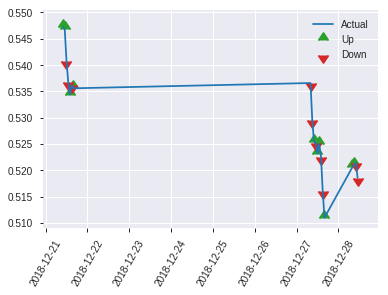


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20814996453139656
RMSE: 0.45623454990979867
LogLoss: 0.5971348304886475
Mean Per-Class Error: 0.3237567204301075
AUC: 0.7335349462365591
pr_auc: 0.6742875848386177
Gini: 0.46706989247311825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3088470995426178: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   59   0.4758   (59.0/124.0)
1      18   78   0.1875   (18.0/96.0)
Total  83   137  0.35     (77.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308847     0.669528  136
max f2                       0.141842     0.834783  190
max f0point5                 0.603205     0.639535  61
max accuracy                 0.603205     0.681818  61
max precision                0.907757     1         0
max recall                   0.141842     1         190
max specificity              0.907757     1         0
max absolute_mcc             0.383165     0.350796  118
max min_per_class_accuracy   0.426328     0.65625   104
max mean_per_class_accuracy  0.383165     0.676243  118

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 42.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.873151           2.29167   2.29167            1                0.893246   1                           0.893246            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.851725           2.29167   2.29167            1                0.857976   1                           0.879138            0.0208333       0.0520833                  129.167   129.167
    3        0.0318182                   0.843326           2.29167   2.29167            1                0.848161   1                           0.870287            0.0208333       0.0729167                  129.167   129.167
    4        0.0409091                   0.833789           2.29167   2.29167            1                0.839528   1                           0.863452            0.0208333       0.09375                    129.167   129.167
    5        0.05                        0.805756           1.14583   2.08333            0.5              0.819522   0.909091                    0.855465            0.0104167       0.104167                   14.5833   108.333
    6        0.1                         0.728027           1.45833   1.77083            0.636364         0.766664   0.772727                    0.811065            0.0729167       0.177083                   45.8333   77.0833
    7        0.15                        0.691652           1.66667   1.73611            0.727273         0.708015   0.757576                    0.776715            0.0833333       0.260417                   66.6667   73.6111
    8        0.2                         0.641934           1.66667   1.71875            0.727273         0.674302   0.75                        0.751111            0.0833333       0.34375                    66.6667   71.875
    9        0.3                         0.589202           1.14583   1.52778            0.5              0.618249   0.666667                    0.706824            0.114583        0.458333                   14.5833   52.7778
    10       0.4                         0.491516           0.833333  1.35417            0.363636         0.544743   0.590909                    0.666304            0.0833333       0.541667                   -16.6667  35.4167
    11       0.5                         0.409701           1.45833   1.375              0.636364         0.452573   0.6                         0.623558            0.145833        0.6875                     45.8333   37.5
    12       0.6                         0.315577           0.9375    1.30208            0.409091         0.369864   0.568182                    0.581275            0.09375         0.78125                    -6.25     30.2083
    13       0.7                         0.242196           0.833333  1.23512            0.363636         0.286343   0.538961                    0.539142            0.0833333       0.864583                   -16.6667  23.5119
    14       0.8                         0.194059           0.625     1.15885            0.272727         0.21307    0.505682                    0.498383            0.0625          0.927083                   -37.5     15.8854
    15       0.9                         0.129723           0.729167  1.11111            0.318182         0.156562   0.484848                    0.460403            0.0729167       1                          -27.0833  11.1111
    16       1                           0.0477669          0         1                  0                0.0905838  0.436364                    0.4

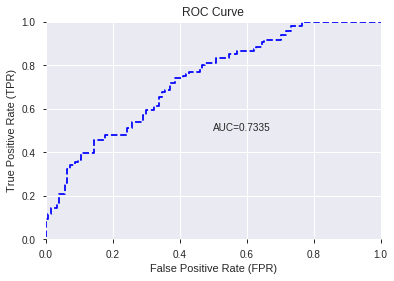

This function is available for GLM models only


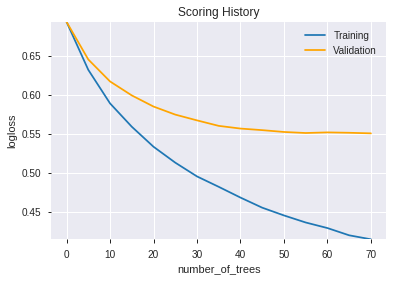

--2019-08-28 18:16:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_181602_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_181602_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'TRANGE',
 'ROC_20',
 'MFI_14',
 'SUB',
 'MFI_12',
 'hour',
 'ADOSC',
 'ROCR100_14',
 'CORREL_20',
 'CORREL_24',
 'aroondown_24',
 'ADX_24',
 'CORREL_12',
 'CDLCLOSINGMARUBOZU',
 'aroonup_30',
 'BBANDS_upperband_20_3_5',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_12_4_5',
 'LINEARREG_INTERCEPT_30',
 'MAVP_14_4',
 'days_in_month',
 'BBANDS_upperband_30_5_3',
 'MA_12_6',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lowerband_14_6_3',
 'is_month_start',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLDOJISTAR',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLGRAVESTONEDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_181733_model_1  0.725302  0.596607              0.366431  0.455941  0.207883

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.291602           1.000000  3.913028e-02
1           CDLCLOSINGMARUBOZU             0.147355           0.505328  1.977363e-02
2                          SUB             0.136041           0.466531  1.825551e-02
3                  CDLLONGLINE             0.133090           0.456408  1.785938e-02
4                          DIV             0.129133           0.442839  1.732841e-02
...                        ...                  ...                ...           ...
1028  BBANDS_middleband_24_1_3             0.000009           0.000032  1.260816e-06
1029                  MAVP_8_1             0.000007           0.000025  9.772791e-07
1030   BBANDS_upperband_14_3_3             0.000006           0.000022  8.475582e-07
1031  BBANDS_middleband_30_1_4             0.000005           0.000018  7.187559e-07
1032  BBANDS_middleband_14_0_5             0.000002           0.000008  3.125056e-07

[1033 rows x 4 columns]

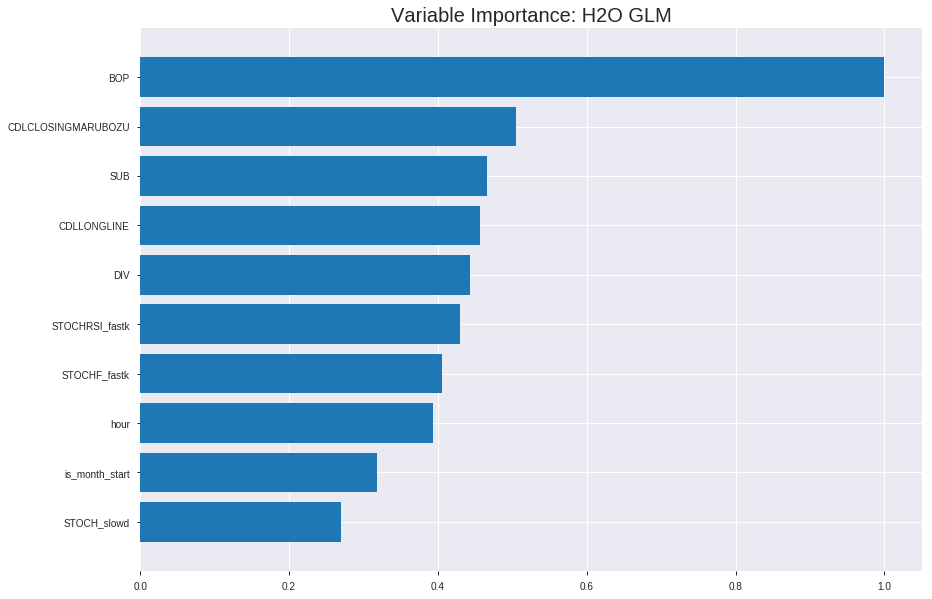

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_181733_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18094867695763472
RMSE: 0.4253806259782346
LogLoss: 0.5404968624178002
Null degrees of freedom: 1534
Residual degrees of freedom: 501
Null deviance: 2116.073526703686
Residual deviance: 1659.3253676226466
AIC: 3727.325367622647
AUC: 0.8076424294268606
pr_auc: 0.7751783772792228
Gini: 0.6152848588537212
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40759749641574167: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      536  299  0.3581   (299.0/835.0)
1      120  580  0.1714   (120.0/700.0)
Total  656  879  0.273    (419.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407597     0.734642  227
max f2                       0.259444     0.830846  305
max f0point5                 0.579907     0.725991  138
max accuracy                 0.490074     0.734202  184
max precision                0.925717     1         0
max recall                   0.0511713    1         393
max specificity              0.925717     1         0
max absolute_mcc             0.408709     0.473983  226
max min_per_class_accuracy   0.472969     0.728571  194
max mean_per_class_accuracy  0.420832     0.736369  220

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.872193           2.0558    2.0558             0.9375           0.897478  0.9375                      0.897478            0.0214286       0.0214286                  105.58    105.58
    2        0.0201954                   0.857997           2.19286   2.12212            1                0.864309  0.967742                    0.881428            0.0214286       0.0428571                  119.286   112.212
    3        0.0306189                   0.836423           2.19286   2.1462             1                0.846444  0.978723                    0.869519            0.0228571       0.0657143                  119.286   114.62
    4        0.0403909                   0.819289           2.04667   2.12212            0.933333         0.825754  0.967742                    0.858931            0.02            0.0857143                  104.667   112.212
    5        0.0501629                   0.806357           2.04667   2.10742            0.933333         0.812685  0.961039                    0.849922            0.02            0.105714                   104.667   110.742
    6        0.100326                    0.744108           1.76568   1.93655            0.805195         0.772896  0.883117                    0.811409            0.0885714       0.194286                   76.5677   93.6549
    7        0.150489                    0.703568           1.76568   1.87959            0.805195         0.725005  0.857143                    0.782608            0.0885714       0.282857                   76.5677   87.9592
    8        0.2                         0.658183           1.7312    1.84286            0.789474         0.678941  0.840391                    0.756944            0.0857143       0.368571                   73.1203   84.2857
    9        0.300326                    0.590252           1.55209   1.74572            0.707792         0.624768  0.796095                    0.71279             0.155714        0.524286                   55.2087   74.5724
    10       0.4                         0.520021           1.16092   1.6                0.529412         0.555581  0.729642                    0.673616            0.115714        0.64                       16.0924   60
    11       0.500326                    0.458175           1.03947   1.4876             0.474026         0.488273  0.678385                    0.636451            0.104286        0.744286                   3.94712   48.7602
    12       0.6                         0.388005           0.988936  1.40476            0.45098          0.422658  0.640608                    0.600935            0.0985714       0.842857                   -1.10644  40.4762
    13       0.699674                    0.316199           0.616293  1.29244            0.281046         0.351169  0.589385                    0.565354            0.0614286       0.904286                   -38.3707  29.2438
    14       0.8                         0.252967           0.498377  1.19286            0.227273         0.286141  0.543974                    0.530338            0.05            0.954286                   -50.1623  19.2857
    15       0.899674                    0.163906           0.315313  1.09563            0.143791         0.209978  0.499638                    0.494846            0.0314286       0.985714                   -68.4687  9.56346
    16       1                           0.0240793          0.142393  1                  0.0649351        0.10791   0.456026                    0.456026            0.01



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1989219566085268
RMSE: 0.44600667776225816
LogLoss: 0.5856347886995356
Null degrees of freedom: 437
Residual degrees of freedom: -596
Null deviance: 609.8925503857407
Residual deviance: 513.016074900793
AIC: 2581.016074900793
AUC: 0.7740475842942636
pr_auc: 0.7669446863410915
Gini: 0.5480951685885271
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28214311251063223: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  117  0.5294   (117.0/221.0)
1      22   195  0.1014   (22.0/217.0)
Total  126  312  0.3174   (139.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282143     0.73724   282
max f2                       0.153047     0.84127   356
max f0point5                 0.510976     0.719064  151
max accuracy                 0.435272     0.710046  195
max precision                0.914732     1         0
max recall                   0.0140849    1         399
max specificity              0.914732     1         0
max absolute_mcc             0.428232     0.420616  201
max min_per_class_accuracy   0.438592     0.705882  194
max mean_per_class_accuracy  0.428232     0.710209  201

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 43.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.845036           2.01843   2.01843            1                0.884761   1                           0.884761            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.811194           2.01843   2.01843            1                0.824436   1                           0.85795             0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.79063            2.01843   2.01843            1                0.799479   1                           0.837068            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.761417           2.01843   2.01843            1                0.775682   1                           0.823426            0.0184332       0.0829493                  101.843   101.843
    5        0.0502283                   0.751654           2.01843   2.01843            1                0.756921   1                           0.811334            0.0184332       0.101382                   101.843   101.843
    6        0.100457                    0.693035           1.5597    1.78907            0.772727         0.722      0.886364                    0.766667            0.078341        0.179724                   55.9698   78.9066
    7        0.150685                    0.66203            1.65145   1.74319            0.818182         0.677858   0.863636                    0.737064            0.0829493       0.262673                   65.1445   74.3192
    8        0.200913                    0.621161           1.46795   1.67438            0.727273         0.639834   0.829545                    0.712757            0.0737327       0.336406                   46.7951   67.4382
    9        0.30137                     0.560739           1.3762    1.57499            0.681818         0.586384   0.780303                    0.670633            0.138249        0.474654                   37.6204   57.499
    10       0.399543                    0.500366           1.26739   1.49941            0.627907         0.53123    0.742857                    0.636379            0.124424        0.599078                   26.7388   49.9408
    11       0.5                         0.436932           1.10096   1.41935            0.545455         0.470074   0.703196                    0.602966            0.110599        0.709677                   10.0964   41.9355
    12       0.600457                    0.377413           0.91747   1.33539            0.454545         0.40974    0.661597                    0.570639            0.0921659       0.801843                   -8.25304  33.5389
    13       0.69863                     0.290307           0.797985  1.25987            0.395349         0.337678   0.624183                    0.537903            0.078341        0.880184                   -20.2015  25.9872
    14       0.799087                    0.232083           0.504608  1.16492            0.25             0.259407   0.577143                    0.502892            0.0506912       0.930876                   -49.5392  16.4924
    15       0.899543                    0.15217            0.458735  1.08606            0.227273         0.191295   0.538071                    0.468094            0.0460829       0.976959                   -54.1265  8.60605
    16       1                           0.0140849          0.229367  1                  0.113636         0.0914058  0.495434                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 18:17:37  0.000 sec   2            .2E2      1010          1.3502384934502738  1.3642366735878007
     2019-08-28 18:17:39  2.183 sec   4            .15E2     1031          1.3415627457989292  1.3569561794396754
     2019-08-28 18:17:41  4.409 sec   6            .11E2     1031          1.3307821790630499  1.347823737454212
     2019-08-28 18:17:44  6.672 sec   8            .79E1     1032          1.3176949156537616  1.3368717351230517
     2019-08-28 18:17:46  8.964 sec   10           .57E1     1033          1.3022186652625916  1.323993418337194
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 18:18:15  38.218 sec  36           .92E-1    1034          1.069771106526009   1.17154273139314
     2019-08-28 18:18:17  40.372 sec  38           .67E-1    1034          1.0595676282871926  1.1744967153107413
     2019-08-28 18:18:20  42.534 sec  40           .49E-1    1034          1.0502388204101176  1.180060776895081
     2019-08-28 18:18:22  44.785 sec  42           .36E-1    1034          1.041651094725294   1.1880751158038598
     2019-08-28 18:18:24  47.419 sec  44           .26E-1    1034          1.0336800870328655  1.198980395929399


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772727272727272)

('F1', 0.673913043478261)

('auc', 0.7253024193548387)

('logloss', 0.5966071455086114)

('mean_per_class_error', 0.324260752688172)

('rmse', 0.45594134690241656)

('mse', 0.20788251181518974)

glm prediction progress: |████████████████████████████████████████████████| 100%


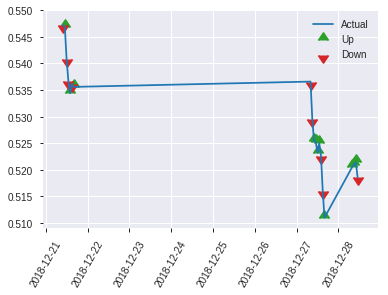


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20788251181518974
RMSE: 0.45594134690241656
LogLoss: 0.5966071455086114
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 301.7551983180251
Residual deviance: 262.50714402378907
AIC: 2330.507144023789
AUC: 0.7253024193548387
pr_auc: 0.6498736591998548
Gini: 0.4506048387096775
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21211143074187253: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      37   87   0.7016   (87.0/124.0)
1      3    93   0.0312   (3.0/96.0)
Total  40   180  0.4091   (90.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.212111     0.673913  179
max f2                       0.135941     0.826162  196
max f0point5                 0.599746     0.634921  38
max accuracy                 0.599746     0.677273  38
max precision                0.888563     1         0
max recall                   0.135941     1         196
max specificity              0.888563     1         0
max absolute_mcc             0.599746     0.359558  38
max min_per_class_accuracy   0.418282     0.635417  104
max mean_per_class_accuracy  0.37813      0.675739  125

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 41.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.835296           1.52778   1.52778            0.666667         0.859687   0.666667                    0.859687            0.0208333       0.0208333                  52.7778   52.7778
    2        0.0227273                   0.818439           2.29167   1.83333            1                0.826083   0.8                         0.846246            0.0208333       0.0416667                  129.167   83.3333
    3        0.0318182                   0.790795           2.29167   1.96429            1                0.806226   0.857143                    0.834811            0.0208333       0.0625                     129.167   96.4286
    4        0.0409091                   0.77807            2.29167   2.03704            1                0.784514   0.888889                    0.823634            0.0208333       0.0833333                  129.167   103.704
    5        0.05                        0.761452           2.29167   2.08333            1                0.773313   0.909091                    0.814485            0.0208333       0.104167                   129.167   108.333
    6        0.1                         0.706742           1.45833   1.77083            0.636364         0.740663   0.772727                    0.777574            0.0729167       0.177083                   45.8333   77.0833
    7        0.15                        0.629743           1.875     1.80556            0.818182         0.667548   0.787879                    0.740899            0.09375         0.270833                   87.5      80.5556
    8        0.2                         0.587358           1.45833   1.71875            0.636364         0.605046   0.75                        0.706935            0.0729167       0.34375                    45.8333   71.875
    9        0.3                         0.522826           0.9375    1.45833            0.409091         0.557852   0.636364                    0.657241            0.09375         0.4375                     -6.25     45.8333
    10       0.4                         0.44034            1.14583   1.38021            0.5              0.477896   0.602273                    0.612405            0.114583        0.552083                   14.5833   38.0208
    11       0.5                         0.403339           1.04167   1.3125             0.454545         0.424187   0.572727                    0.574761            0.104167        0.65625                    4.16667   31.25
    12       0.6                         0.353453           1.25      1.30208            0.545455         0.383015   0.568182                    0.542803            0.125           0.78125                    25        30.2083
    13       0.7                         0.305115           0.625     1.20536            0.272727         0.328828   0.525974                    0.512236            0.0625          0.84375                    -37.5     20.5357
    14       0.8                         0.232388           1.04167   1.1849             0.454545         0.264573   0.517045                    0.481278            0.104167        0.947917                   4.16667   18.4896
    15       0.9                         0.132867           0.520833  1.11111            0.227273         0.18435    0.484848                    0.448286            0.0520833       1                          -47.9167  11.1111
    16       1                           0.0213157          0         1                  0                0.0891468  0.436364                    0.

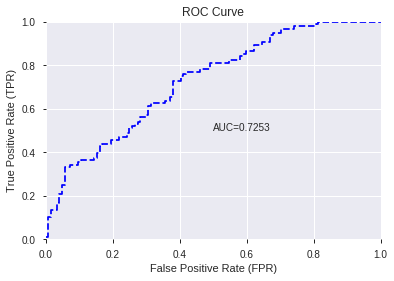

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


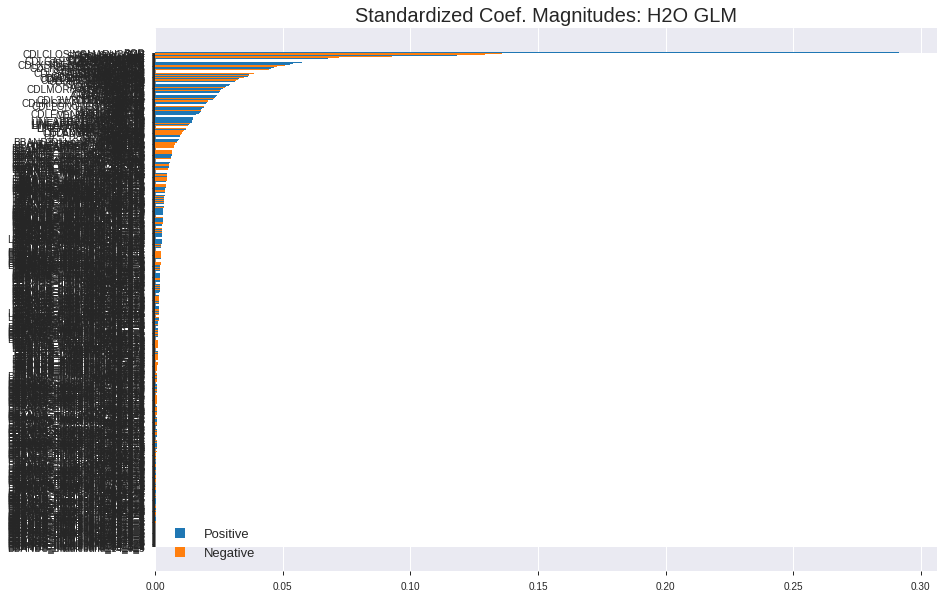

'log_likelihood'
--2019-08-28 18:18:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_181733_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_181733_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

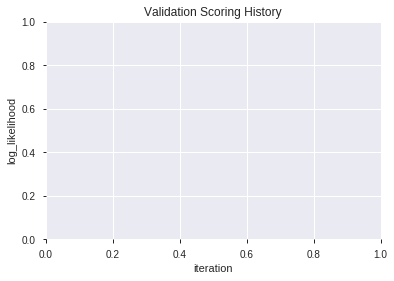

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_181953_model_2  0.736643  0.596746              0.309644  0.454240  0.206334
1  XGBoost_grid_1_AutoML_20190828_181953_model_6  0.734375  0.598642              0.306116  0.456493  0.208386
2  XGBoost_grid_1_AutoML_20190828_181953_model_5  0.732863  0.602925              0.304940  0.459778  0.211396
3  XGBoost_grid_1_AutoML_20190828_181953_model_4  0.731435  0.603966              0.311996  0.456808  0.208674
4               XGBoost_3_AutoML_20190828_181953  0.729251  0.600609              0.301579  0.457719  0.209506
5               XGBoost_2_AutoML_20190828_181953  0.720514  0.612653              0.322413  0.463042  0.214408
6  XGBoost_grid_1_AutoML_20190828_181953_model_1  0.713206  0.614298              0.342406  0.463145  0.214504
7               XGBoost_1_AutoML_20190828_181953  0.709761  0.621704              0.343414  0.467697  0.218741
8  XGBoost_grid_1_AutoML_20190828_181953_model_3  0.708417  0.621674              0.323421  0.467416  0.218478
9  XGBoost_grid_1_AutoML_20190828_181953_model_7  0.687500  0.643244              0.364415  0.475197  0.225812

variable  relative_importance  scaled_importance  percentage
0                        BOP          2453.098633           1.000000    0.244665
1                        DIV           601.327637           0.245130    0.059975
2                     TRANGE           331.046478           0.134950    0.033018
3                     Volume           254.407593           0.103709    0.025374
4               STOCHF_fastk           251.697861           0.102604    0.025104
..                       ...                  ...                ...         ...
322  BBANDS_upperband_30_7_2             0.403297           0.000164    0.000040
323   BBANDS_upperband_8_0_4             0.393322           0.000160    0.000039
324  BBANDS_upperband_30_0_4             0.300762           0.000123    0.000030
325                    Close             0.175304           0.000071    0.000017
326                   T3_8_1             0.155757           0.000063    0.000016

[327 rows x 4 columns]

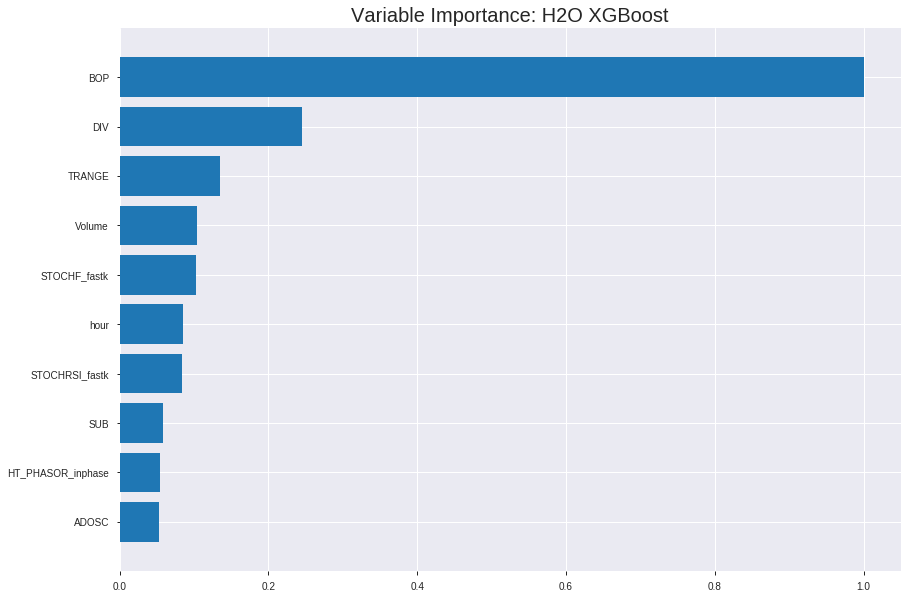

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_181953_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12028390915232372
RMSE: 0.34681970698379255
LogLoss: 0.40042025377837664
Mean Per-Class Error: 0.12875534644995723
AUC: 0.9426980325064157
pr_auc: 0.9381899176240905
Gini: 0.8853960650128314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5138674179712931: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      750  85   0.1018   (85.0/835.0)
1      109  591  0.1557   (109.0/700.0)
Total  859  676  0.1264   (194.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513867     0.859012  179
max f2                       0.306325     0.890285  275
max f0point5                 0.574331     0.888114  152
max accuracy                 0.519902     0.873616  177
max precision                0.894072     1         0
max recall                   0.178228     1         334
max specificity              0.894072     1         0
max absolute_mcc             0.519902     0.744958  177
max min_per_class_accuracy   0.493961     0.868571  190
max mean_per_class_accuracy  0.513867     0.871245  179

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.873253           2.19286    2.19286            1                0.881529   1                           0.881529            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.860237           2.19286    2.19286            1                0.866693   1                           0.87435             0.0214286       0.0442857                  119.286   119.286
    3        0.0306189                   0.847999           2.19286    2.19286            1                0.854315   1                           0.86753             0.0228571       0.0671429                  119.286   119.286
    4        0.0403909                   0.837577           2.19286    2.19286            1                0.84186    1                           0.861319            0.0214286       0.0885714                  119.286   119.286
    5        0.0501629                   0.829072           2.19286    2.19286            1                0.83331    1                           0.855863            0.0214286       0.11                       119.286   119.286
    6        0.100326                    0.787872           2.19286    2.19286            1                0.808713   1                           0.832288            0.11            0.22                       119.286   119.286
    7        0.150489                    0.749499           2.19286    2.19286            1                0.769051   1                           0.811209            0.11            0.33                       119.286   119.286
    8        0.2                         0.716428           2.164      2.18571            0.986842         0.734119   0.996743                    0.792125            0.107143        0.437143                   116.4     118.571
    9        0.300326                    0.636242           1.99351    2.12151            0.909091         0.676449   0.967462                    0.753482            0.2             0.637143                   99.3506   112.151
    10       0.4                         0.551141           1.51923    1.97143            0.69281          0.596422   0.899023                    0.714345            0.151429        0.788571                   51.9234   97.1429
    11       0.500326                    0.458254           0.982514   1.77313            0.448052         0.506635   0.808594                    0.672695            0.0985714       0.887143                   -1.74861  77.3131
    12       0.6                         0.363155           0.487302   1.55952            0.222222         0.413494   0.711183                    0.629636            0.0485714       0.935714                   -51.2698  55.9524
    13       0.699674                    0.270235           0.429972   1.39861            0.196078         0.317722   0.637803                    0.585201            0.0428571       0.978571                   -57.0028  39.861
    14       0.8                         0.178319           0.199351   1.24821            0.0909091        0.222682   0.569218                    0.539738            0.02            0.998571                   -80.0649  24.8214
    15       0.899674                    0.119005           0.0143324  1.11151            0.00653595       0.146405   0.506879                    0.496161            0.00142857      1                          -98.5668  11.1513
    16       1                           0.0660492          0          1                  0                0.0986024  0.456026  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1879376484381899
RMSE: 0.4335177602338685
LogLoss: 0.5558334058849548
Mean Per-Class Error: 0.24831619992910314
AUC: 0.7976937673332359
pr_auc: 0.7740274619851817
Gini: 0.5953875346664719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4326016902923584: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      153  68   0.3077   (68.0/221.0)
1      41   176  0.1889   (41.0/217.0)
Total  194  244  0.2489   (109.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432602     0.763557  220
max f2                       0.249873     0.859375  315
max f0point5                 0.432602     0.737636  220
max accuracy                 0.432602     0.751142  220
max precision                0.898102     1         0
max recall                   0.117009     1         378
max specificity              0.898102     1         0
max absolute_mcc             0.432602     0.506659  220
max min_per_class_accuracy   0.476431     0.732719  196
max mean_per_class_accuracy  0.432602     0.751684  220

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.840169           2.01843    2.01843            1                0.865145  1                           0.865145            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.82295            2.01843    2.01843            1                0.832968  1                           0.850844            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.804061           1.61475    1.87426            0.8              0.813745  0.928571                    0.837594            0.0184332       0.0599078                  61.4747   87.4259
    4        0.0410959                   0.786945           1.51382    1.79416            0.75             0.793429  0.888889                    0.82778             0.0138249       0.0737327                  51.3825   79.4163
    5        0.0502283                   0.774576           2.01843    1.83494            1                0.780615  0.909091                    0.819204            0.0184332       0.0921659                  101.843   83.4939
    6        0.100457                    0.707865           1.74319    1.78907            0.863636         0.736512  0.886364                    0.777858            0.0875576       0.179724                   74.3192   78.9066
    7        0.150685                    0.670013           1.65145    1.74319            0.818182         0.691271  0.863636                    0.748996            0.0829493       0.262673                   65.1445   74.3192
    8        0.200913                    0.635565           1.28446    1.62851            0.636364         0.654066  0.806818                    0.725263            0.0645161       0.327189                   28.4457   62.8509
    9        0.30137                     0.598499           1.51382    1.59028            0.75             0.618611  0.787879                    0.689712            0.152074        0.479263                   51.3825   59.0281
    10       0.399543                    0.547102           1.36127    1.53401            0.674419         0.57115   0.76                        0.66058             0.133641        0.612903                   36.1269   53.4009
    11       0.5                         0.47569            1.19271    1.46544            0.590909         0.512856  0.726027                    0.6309              0.119816        0.732719                   19.2711   46.5438
    12       0.600457                    0.395767           0.825723   1.35841            0.409091         0.436292  0.673004                    0.598342            0.0829493       0.815668                   -17.4277  35.8413
    13       0.69863                     0.311224           0.704105   1.26647            0.348837         0.351882  0.627451                    0.563709            0.0691244       0.884793                   -29.5895  26.6468
    14       0.799087                    0.239828           0.779849   1.20529            0.386364         0.278655  0.597143                    0.527874            0.078341        0.963134                   -22.0151  20.5293
    15       0.899543                    0.149425           0.321114   1.10655            0.159091         0.187811  0.548223                    0.489897            0.0322581       0.995392                   -67.8886  10.6552
    16       1                           0.0655163          0.0458735  1                  0.0227273        0.113486  0.495434                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:20:18  5.048 sec   0                  0.5              0.693147            0.5             0                  1                0.543974                         0.5                0.693147              0.5               0                    1                  0.504566
    2019-08-28 18:20:19  6.218 sec   5                  0.472838         0.640022            0.853183        0.74779            2.08321          0.230619                         0.482835           0.659231              0.763976          0.70469              1.79416            0.280822
    2019-08-28 18:20:19  6.481 sec   10                 0.451767         0.599903            0.869711        0.841782           2.19286          0.212378                         0.470898           0.635826              0.775643          0.747711             2.01843            0.267123
    2019-08-28 18:20:20  6.753 sec   15                 0.4348           0.567741            0.878441        0.862508           2.19286          0.20456                          0.461478           0.617187              0.782274          0.751454             2.01843            0.296804
    2019-08-28 18:20:20  7.011 sec   20                 0.421859         0.543188            0.888398        0.87801            2.19286          0.196091                         0.455084           0.604082              0.787435          0.763515             2.01843            0.315068
    2019-08-28 18:20:20  7.286 sec   25                 0.410622         0.521631            0.895192        0.887463           2.19286          0.198046                         0.449746           0.59307               0.789916          0.765023             2.01843            0.269406
    2019-08-28 18:20:21  7.558 sec   30                 0.400887         0.502727            0.901395        0.893629           2.19286          0.176547                         0.445612           0.58424               0.791407          0.765903             2.01843            0.269406
    2019-08-28 18:20:21  7.838 sec   35                 0.3925           0.486641            0.906944        0.899284           2.19286          0.175896                         0.442917           0.578354              0.792001          0.767435             2.01843            0.283105
    2019-08-28 18:20:21  8.114 sec   40                 0.385308         0.472594            0.910996        0.902988           2.19286          0.166124                         0.441428           0.574568              0.791449          0.763321             2.01843            0.305936
    2019-08-28 18:20:21  8.382 sec   45                 0.378501         0.459487            0.916273        0.910098           2.19286          0.159609                         0.439522           0.570324              0.792564          0.762971             2.01843            0.308219
    2019-08-28 18:20:22  8.646 sec   50                 0.371731         0.446648            0.922177        0.916645           2.19286          0.1557                           0.438432           0.56771               0.791595          0.762539             2.01843            0.310502
    2019-08-28 18:20:22  8.913 sec   55                 0.366664         0.436976            0.926453        0.920174           2.19286          0.149837                         0.437277           0.565032              0.794086          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      2453.0986328125        1.0                     0.24466477922137458
DIV                      601.32763671875        0.24512982424572238     0.05997463432965402
TRANGE                   331.0464782714844      0.13495033336345574     0.0330175935182208
Volume                   254.4075927734375      0.10370866844508281     0.02537385846845892
STOCHF_fastk             251.69786071777344     0.1026040524221399      0.0251035978330812
---                      ---                    ---                     ---
BBANDS_upperband_30_7_2  0.40329667925834656    0.00016440296116261875  4.022361419619233e-05
BBANDS_upperband_8_0_4   0.393322229385376      0.00016033689967632017  3.922879216034656e-05
BBANDS_upperband_30_0_4  0.3007619082927704     0.00012260489825798162  2.9997100363748166e-05
Close                    0.175304114818573      7.146231809586279e-05   1.7484312279571912e-05
T3_8_1                   0.1557566374540329     6.34938340312295e-05    1.553470488516937e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6909090909090909)

('F1', 0.6945606694560669)

('auc', 0.7366431451612904)

('logloss', 0.5967464070090724)

('mean_per_class_error', 0.3057795698924731)

('rmse', 0.4542404256514587)

('mse', 0.2063343642960184)

xgboost prediction progress: |████████████████████████████████████████████| 100%


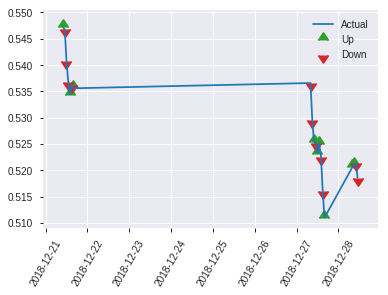


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2063343642960184
RMSE: 0.4542404256514587
LogLoss: 0.5967464070090724
Mean Per-Class Error: 0.3057795698924731
AUC: 0.7366431451612904
pr_auc: 0.6487920409392995
Gini: 0.47328629032258074
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31629064679145813: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   60   0.4839   (60.0/124.0)
1      13   83   0.1354   (13.0/96.0)
Total  77   143  0.3318   (73.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316291     0.694561  142
max f2                       0.152891     0.82038   194
max f0point5                 0.547415     0.652174  67
max accuracy                 0.547415     0.690909  67
max precision                0.847241     1         0
max recall                   0.121595     1         204
max specificity              0.847241     1         0
max absolute_mcc             0.316291     0.395849  142
max min_per_class_accuracy   0.425279     0.653226  105
max mean_per_class_accuracy  0.375974     0.69422   125

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 41.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.818827           2.29167   2.29167            1                0.832268  1                           0.832268            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.806127           1.14583   1.83333            0.5              0.810031  0.8                         0.823373            0.0104167       0.0416667                  14.5833   83.3333
    3        0.0318182                   0.791531           1.14583   1.6369             0.5              0.800752  0.714286                    0.81691             0.0104167       0.0520833                  14.5833   63.6905
    4        0.0409091                   0.774542           2.29167   1.78241            1                0.780997  0.777778                    0.808929            0.0208333       0.0729167                  129.167   78.2407
    5        0.05                        0.758612           1.14583   1.66667            0.5              0.772846  0.727273                    0.802369            0.0104167       0.0833333                  14.5833   66.6667
    6        0.1                         0.688259           1.66667   1.66667            0.727273         0.736658  0.727273                    0.769513            0.0833333       0.166667                   66.6667   66.6667
    7        0.15                        0.645563           1.66667   1.66667            0.727273         0.665767  0.727273                    0.734931            0.0833333       0.25                       66.6667   66.6667
    8        0.2                         0.615725           1.45833   1.61458            0.636364         0.630898  0.704545                    0.708923            0.0729167       0.322917                   45.8333   61.4583
    9        0.3                         0.549465           1.5625    1.59722            0.681818         0.582892  0.69697                     0.666913            0.15625         0.479167                   56.25     59.7222
    10       0.4                         0.470352           0.729167  1.38021            0.318182         0.514077  0.602273                    0.628704            0.0729167       0.552083                   -27.0833  38.0208
    11       0.5                         0.413973           1.25      1.35417            0.545455         0.440233  0.590909                    0.59101             0.125           0.677083                   25        35.4167
    12       0.6                         0.354902           1.35417   1.35417            0.590909         0.384323  0.590909                    0.556562            0.135417        0.8125                     35.4167   35.4167
    13       0.7                         0.287293           0.833333  1.27976            0.363636         0.317109  0.558442                    0.522354            0.0833333       0.895833                   -16.6667  27.9762
    14       0.8                         0.218131           0.3125    1.15885            0.136364         0.248798  0.505682                    0.48816             0.03125         0.927083                   -68.75    15.8854
    15       0.9                         0.138587           0.625     1.09954            0.272727         0.176628  0.479798                    0.453545            0.0625          0.989583                   -37.5     9.9537
    16       1                           0.0680826          0.104167  1                  0.0454545        0.109952  0.436364                    0.419186          

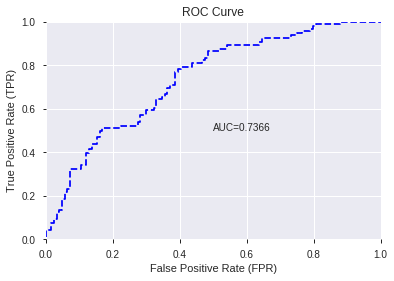

This function is available for GLM models only


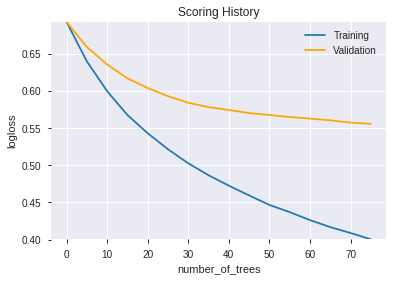

--2019-08-28 18:21:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_181953_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_181953_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_182208_model_5  0.736307  0.584546              0.365255  0.452348  0.204618
1  DeepLearning_grid_1_AutoML_20190828_182208_model_6  0.727319  0.601630              0.378528  0.457151  0.208987
2  DeepLearning_grid_1_AutoML_20190828_182208_model_8  0.718834  0.654102              0.332157  0.470873  0.221721
3  DeepLearning_grid_1_AutoML_20190828_182208_model_9  0.714886  0.632646              0.381384  0.469449  0.220383
4  DeepLearning_grid_1_AutoML_20190828_182208_model_7  0.710265  0.614611              0.388273  0.464471  0.215734
5  DeepLearning_grid_1_AutoML_20190828_182208_model_4  0.704217  0.888640              0.360215  0.524699  0.275309
6  DeepLearning_grid_1_AutoML_20190828_182208_model_3  0.702285  0.754848              0.395833  0.492786  0.242838
7               DeepLearning_1_AutoML_20190828_182208  0.696237  0.636486              0.417675  0.468919  0.219885
8  DeepLearning_grid_1_AutoML_20190828_182208_model_2  0.693800  0.854915              0.417171  0.515474  0.265713
9  DeepLearning_grid_1_AutoML_20190828_182208_model_1  0.659022  1.101037              0.388441  0.544577  0.296564

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.045460
1        CDLCLOSINGMARUBOZU             0.714238           0.714238    0.032469
2              STOCHF_fastk             0.619890           0.619890    0.028180
3                    ADX_24             0.608589           0.608589    0.027666
4                      hour             0.595672           0.595672    0.027079
5                       DIV             0.581022           0.581022    0.026413
6              aroondown_24             0.575738           0.575738    0.026173
7                    MFI_12             0.535969           0.535969    0.024365
8                 CORREL_12             0.534503           0.534503    0.024298
9             days_in_month             0.525061           0.525061    0.023869
10             HT_TRENDMODE             0.523656           0.523656    0.023805
11                      SUB             0.517436           0.517436    0.023523
12               aroonup_30             0.515943           0.515943    0.023455
13                    ADOSC             0.502192           0.502192    0.022830
14              CDLMARUBOZU             0.485073           0.485073    0.022051
15                   ROC_20             0.480287           0.480287    0.021834
16                   MFI_14             0.476336           0.476336    0.021654
17                   TRANGE             0.475665           0.475665    0.021624
18       CDLMORNINGDOJISTAR             0.449187           0.449187    0.020420
19           is_month_start             0.437550           0.437550    0.019891
20               ROCR100_14             0.432994           0.432994    0.019684
21              CDLPIERCING             0.387607           0.387607    0.017621
22  BBANDS_lowerband_14_6_3             0.383052           0.383052    0.017413
23                CORREL_24             0.380674           0.380674    0.017305
24                CDLTAKURI             0.380534           0.380534    0.017299
25                CDLHAMMER             0.374923           0.374923    0.017044
26           CDLMORNINGSTAR             0.374661           0.374661    0.017032
27  BBANDS_upperband_20_3_5             0.370387           0.370387    0.016838
28              CDLDOJISTAR             0.370170           0.370170    0.016828
29          CDLADVANCEBLOCK             0.369875           0.369875    0.016814
30            CDLHANGINGMAN             0.368981           0.368981    0.016774
31           CDLEVENINGSTAR             0.368111           0.368111    0.016734
32             CDLTASUKIGAP             0.367773           0.367773    0.016719
33   LINEARREG_INTERCEPT_30             0.365089           0.365089    0.016597
34  BBANDS_lowerband_14_5_5             0.364942           0.364942    0.016590
35      CDLRISEFALL3METHODS             0.362606           0.362606    0.016484
36      CDLGAPSIDESIDEWHITE             0.362285           0.362285    0.016469
37  BBANDS_upperband_30_5_3             0.361016           0.361016    0.016412
38                MAVP_14_4             0.357500           0.357500    0.016252
39             is_month_end             0.351917           0.351917    0.015998
40                  MA_12_6             0.348512           0.348512    0.015843
41                CORREL_20             0.348038           0.348038    0.015822
42  BBANDS_lowerband_14_7_4             0.344308           0.344308    0.015652
43         CDLDRAGONFLYDOJI             0.344288           0.344288    0.015651
44        CDLSTALLEDPATTERN             0.343963           0.343963    0.015637
45        CDLGRAVESTONEDOJI             0.342514           0.342514    0.015571
46  BBANDS_lowerband_12_4_5             0.340448           0.340448    0.015477
47           CDLHARAMICROSS             0.339449           0.339449    0.015431
48          CDLHOMINGPIGEON             0.322946           0.322946    0.014681
49               CD

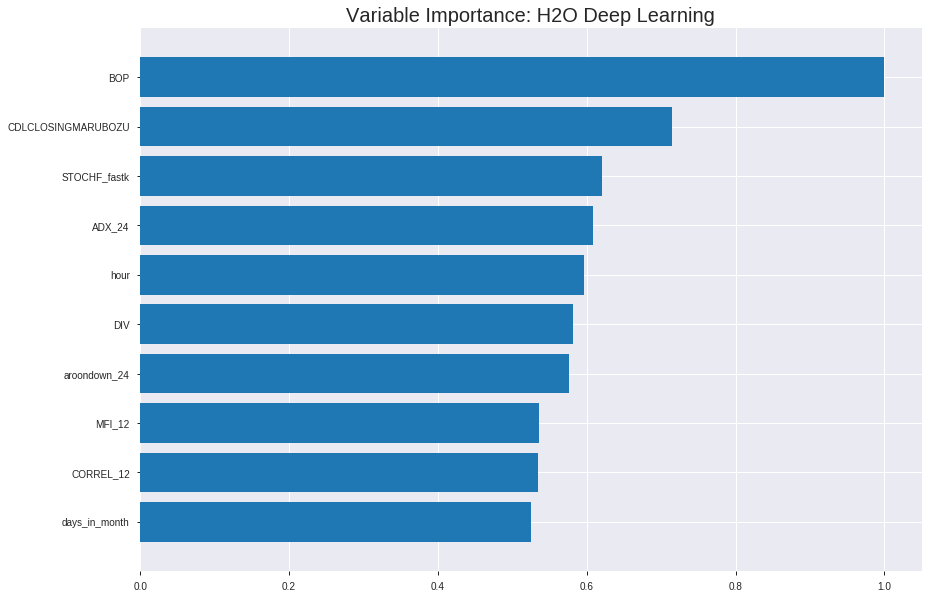

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_182208_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1688169565732955
RMSE: 0.41087340699209957
LogLoss: 0.5020134685616738
Mean Per-Class Error: 0.2516124893071001
AUC: 0.8300556030795552
pr_auc: 0.8122517878997624
Gini: 0.6601112061591103
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42416809907996217: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      534  301  0.3605   (301.0/835.0)
1      108  592  0.1543   (108.0/700.0)
Total  642  893  0.2664   (409.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424168     0.743252  232
max f2                       0.198833     0.837865  324
max f0point5                 0.5924       0.744421  152
max accuracy                 0.58117      0.749186  158
max precision                0.993834     1         0
max recall                   0.0444077    1         378
max specificity              0.993834     1         0
max absolute_mcc             0.472009     0.495647  212
max min_per_class_accuracy   0.510193     0.741317  195
max mean_per_class_accuracy  0.472009     0.748388  212

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 47.00 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.981945           2.19286    2.19286            1                0.986645   1                           0.986645            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.972108           2.19286    2.19286            1                0.976959   1                           0.981958            0.0214286       0.0442857                  119.286   119.286
    3        0.0306189                   0.953849           2.0558     2.1462             0.9375           0.965365   0.978723                    0.976309            0.0214286       0.0657143                  105.58    114.62
    4        0.0403909                   0.930371           2.19286    2.15749            1                0.942431   0.983871                    0.968113            0.0214286       0.0871429                  119.286   115.749
    5        0.0501629                   0.900771           2.19286    2.16438            1                0.915471   0.987013                    0.957858            0.0214286       0.108571                   119.286   116.438
    6        0.100326                    0.804242           2.10742    2.1359             0.961039         0.849151   0.974026                    0.903505            0.105714        0.214286                   110.742   113.59
    7        0.150489                    0.742241           1.79416    2.02199            0.818182         0.769794   0.922078                    0.858934            0.09            0.304286                   79.4156   102.199
    8        0.2                         0.697827           1.64464    1.92857            0.75             0.722856   0.879479                    0.825247            0.0814286       0.385714                   64.4643   92.8571
    9        0.300326                    0.624794           1.45241    1.76951            0.662338         0.66166    0.806941                    0.7706              0.145714        0.531429                   45.2412   76.9507
    10       0.4                         0.56349            1.26125    1.64286            0.575163         0.592839   0.749186                    0.726304            0.125714        0.657143                   26.1251   64.2857
    11       0.500326                    0.494579           1.08219    1.53043            0.493506         0.531883   0.697917                    0.687319            0.108571        0.765714                   8.21892   53.0432
    12       0.6                         0.406633           0.917274   1.42857            0.418301         0.45133    0.651466                    0.648116            0.0914286       0.857143                   -8.27264  42.8571
    13       0.699674                    0.315168           0.558964   1.30469            0.254902         0.362997   0.594972                    0.607498            0.0557143       0.912857                   -44.1036  30.4689
    14       0.8                         0.207289           0.498377   1.20357            0.227273         0.264695   0.54886                     0.564508            0.05            0.962857                   -50.1623  20.3571
    15       0.899674                    0.0853369          0.343978   1.10834            0.156863         0.147565   0.505431                    0.518315            0.0342857       0.997143                   -65.6022  10.8338
    16       1                           0.000938299        0.0284787  1                  0.012987         0.0363043  0.456026   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19814264509475074
RMSE: 0.4451321658729582
LogLoss: 0.5789859084558958
Mean Per-Class Error: 0.2933982526012886
AUC: 0.7733386158433597
pr_auc: 0.7454624045101603
Gini: 0.5466772316867194
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.328195022565508: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      111  110  0.4977   (110.0/221.0)
1      24   193  0.1106   (24.0/217.0)
Total  135  303  0.3059   (134.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.328195     0.742308  270
max f2                       0.126796     0.853852  355
max f0point5                 0.496885     0.714286  152
max accuracy                 0.374878     0.705479  233
max precision                0.991687     1         0
max recall                   0.0229268    1         392
max specificity              0.991687     1         0
max absolute_mcc             0.350407     0.427752  252
max min_per_class_accuracy   0.443284     0.682028  195
max mean_per_class_accuracy  0.36445      0.706602  242

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 43.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.948223           1.61475   1.61475            0.8              0.966549   0.8                         0.966549            0.0184332       0.0184332                  61.4747   61.4747
    2        0.0205479                   0.930058           1.51382   1.56989            0.75             0.939224   0.777778                    0.954404            0.0138249       0.0322581                  51.3825   56.9892
    3        0.0319635                   0.905416           2.01843   1.73009            1                0.917566   0.857143                    0.941248            0.0230415       0.0552995                  101.843   73.0086
    4        0.0410959                   0.881516           2.01843   1.79416            1                0.894243   0.888889                    0.930802            0.0184332       0.0737327                  101.843   79.4163
    5        0.0502283                   0.867611           2.01843   1.83494            1                0.875143   0.909091                    0.920683            0.0184332       0.0921659                  101.843   83.4939
    6        0.100457                    0.738546           1.74319   1.78907            0.863636         0.801447   0.886364                    0.861065            0.0875576       0.179724                   74.3192   78.9066
    7        0.150685                    0.680186           1.46795   1.68203            0.727273         0.706729   0.833333                    0.80962             0.0737327       0.253456                   46.7951   68.2028
    8        0.200913                    0.632161           1.46795   1.62851            0.727273         0.662651   0.806818                    0.772877            0.0737327       0.327189                   46.7951   62.8509
    9        0.30137                     0.542105           1.42208   1.5597             0.704545         0.581155   0.772727                    0.70897             0.142857        0.470046                   42.2078   55.9698
    10       0.399543                    0.489662           1.31433   1.49941            0.651163         0.514221   0.742857                    0.661117            0.129032        0.599078                   31.4329   49.9408
    11       0.5                         0.439852           0.825723  1.36406            0.409091         0.464463   0.675799                    0.621607            0.0829493       0.682028                   -17.4277  36.4055
    12       0.600457                    0.373506           1.23858   1.34306            0.613636         0.406826   0.665399                    0.585674            0.124424        0.806452                   23.8584   34.3064
    13       0.69863                     0.323909           0.844926  1.27306            0.418605         0.349325   0.630719                    0.552461            0.0829493       0.889401                   -15.5074  27.3064
    14       0.799087                    0.222909           0.504608  1.17646            0.25             0.280084   0.582857                    0.51822             0.0506912       0.940092                   -49.5392  17.6458
    15       0.899543                    0.12007            0.504608  1.10143            0.25             0.167691   0.545685                    0.479074            0.0506912       0.990783                   -49.5392  10.1429
    16       1                           0.00230111         0.091747  1                  0.0454545        0.0597968  0.495434                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:25:41  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:25:43  1 min 38.131 sec  1267 obs/sec      1.56352   1             2400       0.442433         0.572926            0.210908       0.794754        0.759967           2.0558           0.283388                         0.471371           0.631446              0.111165         0.761224          0.734087             2.01843            0.356164
    2019-08-28 18:25:48  1 min 43.732 sec  2073 obs/sec      9.42345   6             14465      0.418057         0.520888            0.295463       0.814772        0.789157           2.19286          0.255375                         0.458239           0.610068              0.159997         0.760452          0.73981              2.01843            0.335616
    2019-08-28 18:25:54  1 min 49.442 sec  2369 obs/sec      18.8332   12            28909      0.410873         0.502013            0.319468       0.830056        0.812252           2.19286          0.26645                          0.445132           0.578986              0.207363         0.773339          0.745462             1.61475            0.305936
    2019-08-28 18:26:00  1 min 55.752 sec  2478 obs/sec      28.2371   18            43344      0.399463         0.477694            0.356742       0.84693         0.823104           2.19286          0.243648                         0.456954           0.602492              0.164702         0.761203          0.741784             2.01843            0.353881
    2019-08-28 18:26:10  2 min  5.515 sec  2617 obs/sec      45.6378   29            70054      0.373666         0.423867            0.437142       0.887093        0.860001           2.19286          0.205863                         0.462199           0.638318              0.145418         0.748431          0.722885             2.01843            0.296804
    2019-08-28 18:26:16  2 min 11.236 sec  2718 obs/sec      56.6208   36            86913      0.362541         0.401259            0.470157       0.901733        0.85157            2.19286          0.221498                         0.468613           0.657773              0.121532         0.736962          0.708856             2.01843            0.321918
    2019-08-28 18:26:16  2 min 11.755 sec  2716 obs/sec      56.6208   36            86913      0.410873         0.502013            0.319468       0.830056        0.812252           2.19286          0.26645                          0.445132           0.578986              0.207363         0.773339          0.745462             1.61475            0.305936

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.04545986338976164
CDLCLOSINGMARUBOZU       0.7142379283905029     0.7142379283905029   0.032469158652418624
STOCHF_fastk             0.6198900938034058     0.6198900938034058   0.028180118980969355
ADX_24                   0.6085891127586365     0.6085891127586365   0.02766637792650386
hour                     0.5956715941429138     0.5956715941429138   0.027079149294898405
---                      ---                    ---                  ---
CDLGRAVESTONEDOJI        0.3425139784812927     0.3425139784812927   0.015570638670843327
BBANDS_lowerband_12_4_5  0.3404475450515747     0.3404475450515747   0.015476698889424307
CDLHARAMICROSS           0.3394489586353302     0.3394489586353302   0.015431303287358962
CDLHOMINGPIGEON          0.32294636964797974    0.32294636964797974  0.014681097846416625
CDL3INSIDE               0.3138573169708252     0.3138573169708252   0.014267910753370831


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6909090909090909)

('F1', 0.6762589928057554)

('auc', 0.7363071236559139)

('logloss', 0.5845458436392916)

('mean_per_class_error', 0.32543682795698925)

('rmse', 0.4523476784151048)

('mse', 0.20461842216753506)

deeplearning prediction progress: |███████████████████████████████████████| 100%


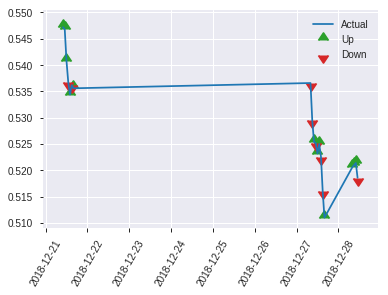


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20461842216753506
RMSE: 0.4523476784151048
LogLoss: 0.5845458436392916
Mean Per-Class Error: 0.32543682795698925
AUC: 0.7363071236559139
pr_auc: 0.6954034279049989
Gini: 0.4726142473118278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2318029148559051: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      36   88   0.7097   (88.0/124.0)
1      2    94   0.0208   (2.0/96.0)
Total  38   182  0.4091   (90.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.231803     0.676259  181
max f2                       0.231803     0.830389  181
max f0point5                 0.591529     0.651042  71
max accuracy                 0.591529     0.690909  71
max precision                0.98763      1         0
max recall                   0.0650694    1         203
max specificity              0.98763      1         0
max absolute_mcc             0.74619      0.364903  31
max min_per_class_accuracy   0.473618     0.66129   105
max mean_per_class_accuracy  0.425453     0.674563  123

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 46.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.975832           2.29167   2.29167            1                0.983532   1                           0.983532            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.963935           2.29167   2.29167            1                0.969173   1                           0.977788            0.0208333       0.0520833                  129.167   129.167
    3        0.0318182                   0.95671            2.29167   2.29167            1                0.962861   1                           0.973523            0.0208333       0.0729167                  129.167   129.167
    4        0.0409091                   0.935697           1.14583   2.03704            0.5              0.949676   0.888889                    0.968224            0.0104167       0.0833333                  14.5833   103.704
    5        0.05                        0.904576           2.29167   2.08333            1                0.919383   0.909091                    0.959344            0.0208333       0.104167                   129.167   108.333
    6        0.1                         0.793516           1.875     1.97917            0.818182         0.855524   0.863636                    0.907434            0.09375         0.197917                   87.5      97.9167
    7        0.15                        0.742208           1.875     1.94444            0.818182         0.769517   0.848485                    0.861462            0.09375         0.291667                   87.5      94.4444
    8        0.2                         0.694029           1.25      1.77083            0.545455         0.724557   0.772727                    0.827235            0.0625          0.354167                   25        77.0833
    9        0.3                         0.619033           1.25      1.59722            0.545455         0.660105   0.69697                     0.771525            0.125           0.479167                   25        59.7222
    10       0.4                         0.524001           0.9375    1.43229            0.409091         0.570686   0.625                       0.721315            0.09375         0.572917                   -6.25     43.2292
    11       0.5                         0.463719           0.9375    1.33333            0.409091         0.492488   0.581818                    0.67555             0.09375         0.666667                   -6.25     33.3333
    12       0.6                         0.402238           1.25      1.31944            0.545455         0.433187   0.575758                    0.635156            0.125           0.791667                   25        31.9444
    13       0.7                         0.314449           0.3125    1.1756             0.136364         0.360065   0.512987                    0.595857            0.03125         0.822917                   -68.75    17.5595
    14       0.8                         0.247717           0.9375    1.14583            0.409091         0.275059   0.5                         0.555757            0.09375         0.916667                   -6.25     14.5833
    15       0.9                         0.0929237          0.729167  1.09954            0.318182         0.185435   0.479798                    0.51461             0.0729167       0.989583                   -27.0833  9.9537
    16       1                           0.00112231         0.104167  1                  0.0454545        0.0403968  0.436364                    

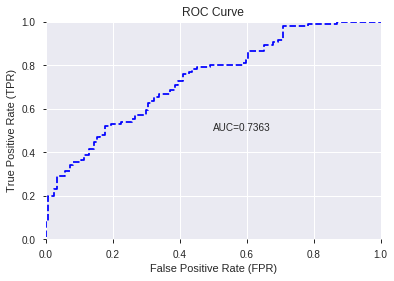

This function is available for GLM models only


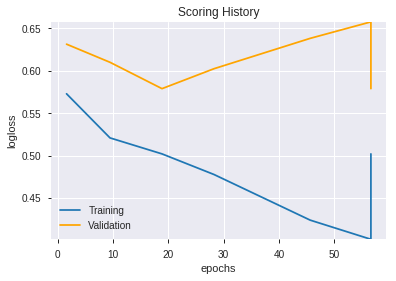

--2019-08-28 18:30:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_182208_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_182208_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'ADX_24',
 'hour',
 'DIV',
 'aroondown_24',
 'MFI_12',
 'CORREL_12',
 'days_in_month',
 'HT_TRENDMODE',
 'SUB',
 'aroonup_30',
 'ADOSC',
 'CDLMARUBOZU',
 'ROC_20',
 'MFI_14',
 'TRANGE',
 'CDLMORNINGDOJISTAR',
 'is_month_start',
 'ROCR100_14',
 'CDLPIERCING',
 'BBANDS_lowerband_14_6_3',
 'CORREL_24',
 'CDLTAKURI',
 'CDLHAMMER',
 'CDLMORNINGSTAR',
 'BBANDS_upperband_20_3_5',
 'CDLDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'CDLTASUKIGAP',
 'LINEARREG_INTERCEPT_30',
 'BBANDS_lowerband_14_5_5',
 'CDLRISEFALL3METHODS',
 'CDLGAPSIDESIDEWHITE',
 'BBANDS_upperband_30_5_3',
 'MAVP_14_4',
 'is_month_end',
 'MA_12_6',
 'CORREL_20',
 'BBANDS_lowerband_14_7_4',
 'CDLDRAGONFLYDOJI',
 'CDLSTALLEDPATTERN',
 'CDLGRAVESTONEDOJI',
 'BBANDS_lowerband_12_4_5',
 'CDLHARAMICROSS',
 'CDLHOMINGPIGEON',
 'CDL3INSIDE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_183102_model_1  0.734375  0.590214              0.317876  0.451603  0.203946

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.605985           1.000000    0.172929
1        CDLCLOSINGMARUBOZU             0.236791           0.390753    0.067572
2                       SUB             0.212186           0.350150    0.060551
3                       DIV             0.185406           0.305958    0.052909
4                      hour             0.154030           0.254181    0.043955
5              STOCHF_fastk             0.152948           0.252396    0.043646
6            is_month_start             0.130235           0.214914    0.037165
7                    MFI_12             0.128544           0.212123    0.036682
8              aroondown_24             0.112170           0.185104    0.032010
9                 CDLTAKURI             0.099217           0.163728    0.028313
10                CDLHAMMER             0.096922           0.159941    0.027658
11                CORREL_12             0.096393           0.159067    0.027507
12      CDLGAPSIDESIDEWHITE             0.093528           0.154340    0.026690
13            days_in_month             0.090509           0.149359    0.025828
14                    ADOSC             0.089088           0.147014    0.025423
15           CDLEVENINGSTAR             0.074141           0.122347    0.021157
16              CDLMARUBOZU             0.068529           0.113087    0.019556
17        CDLSTALLEDPATTERN             0.065771           0.108536    0.018769
18            CDLHANGINGMAN             0.062821           0.103667    0.017927
19              CDLPIERCING             0.052521           0.086670    0.014988
20                   ROC_20             0.051031           0.084212    0.014563
21       CDLMORNINGDOJISTAR             0.048990           0.080844    0.013980
22              CDLDOJISTAR             0.045590           0.075233    0.013010
23               aroonup_30             0.040839           0.067392    0.011654
24  BBANDS_upperband_20_3_5             0.040311           0.066522    0.011504
25                   TRANGE             0.038985           0.064333    0.011125
26                   MFI_14             0.037576           0.062008    0.010723
27           CDLHARAMICROSS             0.036306           0.059912    0.010360
28      CDLRISEFALL3METHODS             0.033991           0.056092    0.009700
29                CORREL_24             0.033862           0.055879    0.009663
30  BBANDS_upperband_30_5_3             0.027303           0.045055    0.007791
31             is_month_end             0.026383           0.043538    0.007529
32  BBANDS_lowerband_12_4_5             0.025111           0.041439    0.007166
33         CDLDRAGONFLYDOJI             0.024243           0.040006    0.006918
34           CDLMORNINGSTAR             0.022034           0.036361    0.006288
35        CDLGRAVESTONEDOJI             0.021790           0.035958    0.006218
36                CORREL_20             0.020166           0.033277    0.005755
37  BBANDS_lowerband_14_7_4             0.017390           0.028697    0.004963
38  BBANDS_lowerband_14_6_3             0.015965           0.026345    0.004556
39               ROCR100_14             0.013923           0.022976    0.003973
40  BBANDS_lowerband_14_5_5             0.011293           0.018636    0.003223
41                MAVP_14_4             0.010996           0.018146    0.003138
42          CDLHOMINGPIGEON             0.010446           0.017237    0.002981
43          CDLADVANCEBLOCK             0.009497           0.015672    0.002710
44   LINEARREG_INTERCEPT_30             0.008876           0.014647    0.002533
45               CDL3INSIDE             0.007933           0.013091    0.002264
46                   ADX_24             0.005643           0.009312    0.001610
47             HT_TRENDMODE             0.004944           0.008158    0.001411
48             CDLTASUKIGAP             0.002874           0.004743    0.000820
49                 

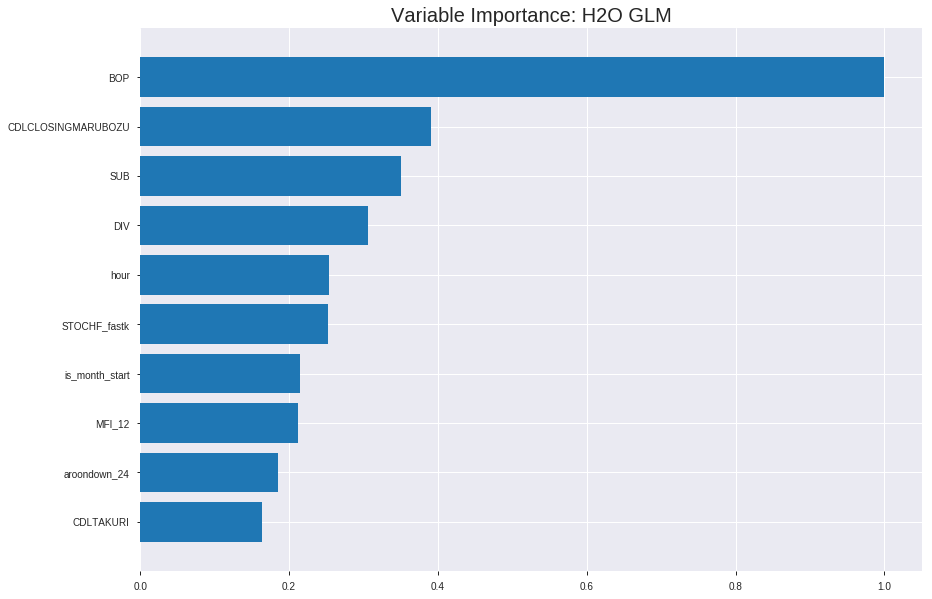

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_183102_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.185297763643473
RMSE: 0.4304622673864377
LogLoss: 0.5507093847706402
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2116.073526703686
Residual deviance: 1690.6778112458655
AIC: 1792.6778112458655
AUC: 0.7944867408041061
pr_auc: 0.7602656376665261
Gini: 0.5889734816082122
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40837446578223435: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      528  307  0.3677   (307.0/835.0)
1      131  569  0.1871   (131.0/700.0)
Total  659  876  0.2853   (438.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408374     0.722081  230
max f2                       0.200334     0.826628  328
max f0point5                 0.569708     0.703919  151
max accuracy                 0.435664     0.723127  216
max precision                0.944174     1         0
max recall                   0.0154651    1         398
max specificity              0.944174     1         0
max absolute_mcc             0.435664     0.454325  216
max min_per_class_accuracy   0.4699       0.721429  200
max mean_per_class_accuracy  0.435664     0.727609  216

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.906127           2.19286   2.19286            1                0.921723   1                           0.921723            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.882937           2.04667   2.12212            0.933333         0.893404   0.967742                    0.90802             0.02            0.0428571                  104.667   112.212
    3        0.0306189                   0.857159           2.0558    2.09954            0.9375           0.870395   0.957447                    0.895212            0.0214286       0.0642857                  105.58    109.954
    4        0.0403909                   0.836701           1.90048   2.05138            0.866667         0.843827   0.935484                    0.88278             0.0185714       0.0828571                  90.0476   105.138
    5        0.0501629                   0.820583           1.75429   1.99351            0.8              0.828813   0.909091                    0.872267            0.0171429       0.1                        75.4286   99.3506
    6        0.100326                    0.758581           1.87959   1.93655            0.857143         0.787665   0.883117                    0.829966            0.0942857       0.194286                   87.9592   93.6549
    7        0.150489                    0.707435           1.70872   1.86061            0.779221         0.728771   0.848485                    0.796234            0.0857143       0.28                       70.872    86.0606
    8        0.2                         0.659794           1.81776   1.85               0.828947         0.683144   0.843648                    0.768238            0.09            0.37                       81.7763   85
    9        0.300326                    0.593124           1.32426   1.67437            0.603896         0.626543   0.763557                    0.720904            0.132857        0.502857                   32.4258   67.4372
    10       0.4                         0.525979           1.26125   1.57143            0.575163         0.559475   0.716612                    0.680678            0.125714        0.628571                   26.1251   57.1429
    11       0.500326                    0.459173           1.09643   1.47618            0.5              0.490642   0.673177                    0.642572            0.11            0.738571                   9.64286   47.6181
    12       0.6                         0.387443           0.945938  1.3881             0.431373         0.42242    0.633008                    0.606               0.0942857       0.832857                   -5.40616  38.8095
    13       0.699674                    0.320128           0.573296  1.27202            0.261438         0.35496    0.580074                    0.570237            0.0571429       0.89                       -42.6704  27.202
    14       0.8                         0.249203           0.526855  1.17857            0.24026          0.284681   0.537459                    0.534426            0.0528571       0.942857                   -47.3145  17.8571
    15       0.899674                    0.143491           0.372642  1.08928            0.169935         0.197029   0.496741                    0.497046            0.0371429       0.98                       -62.7358  8.92831
    16       1                           0.0086863          0.199351  1                  0.0909091        0.0881775  0.456026                    0.456



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19817226079253544
RMSE: 0.4451654308148101
LogLoss: 0.5882128859437529
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 609.8925503857407
Residual deviance: 515.2744880867276
AIC: 617.2744880867276
AUC: 0.7729841316179077
pr_auc: 0.7704960227976118
Gini: 0.5459682632358154
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3115552685298979: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  115  0.5204   (115.0/221.0)
1      25   192  0.1152   (25.0/217.0)
Total  131  307  0.3196   (140.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311555     0.732824  280
max f2                       0.0984453    0.8405    375
max f0point5                 0.563938     0.717131  123
max accuracy                 0.453501     0.710046  205
max precision                0.939445     1         0
max recall                   0.00421642   1         399
max specificity              0.939445     1         0
max absolute_mcc             0.450179     0.42084   207
max min_per_class_accuracy   0.461277     0.692308  199
max mean_per_class_accuracy  0.450179     0.710251  207

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 44.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.899005           2.01843   2.01843            1                0.922085   1                           0.922085            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.829735           2.01843   2.01843            1                0.858103   1                           0.893648            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.803696           2.01843   2.01843            1                0.816202   1                           0.865989            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.785311           1.00922   1.79416            0.5              0.788769   0.888889                    0.848829            0.00921659      0.0737327                  0.921659  79.4163
    5        0.0502283                   0.770465           2.01843   1.83494            1                0.779575   0.909091                    0.836237            0.0184332       0.0921659                  101.843   83.4939
    6        0.100457                    0.71585            1.74319   1.78907            0.863636         0.742563   0.886364                    0.7894              0.0875576       0.179724                   74.3192   78.9066
    7        0.150685                    0.672086           1.74319   1.77377            0.863636         0.690408   0.878788                    0.756403            0.0875576       0.267281                   74.3192   77.3775
    8        0.200913                    0.63154            1.74319   1.76613            0.863636         0.647223   0.875                       0.729108            0.0875576       0.354839                   74.3192   76.6129
    9        0.30137                     0.565448           1.33033   1.62086            0.659091         0.601251   0.80303                     0.686489            0.133641        0.488479                   33.0331   62.0863
    10       0.399543                    0.508772           1.03269   1.47634            0.511628         0.537225   0.731429                    0.649813            0.101382        0.589862                   3.26867   47.634
    11       0.5                         0.461211           1.05509   1.39171            0.522727         0.485833   0.689498                    0.616867            0.105991        0.695853                   5.50901   39.1705
    12       0.600457                    0.382462           1.00922   1.32771            0.5              0.423396   0.657795                    0.584499            0.101382        0.797235                   0.921659  32.7715
    13       0.69863                     0.311673           0.844926  1.25987            0.418605         0.347844   0.624183                    0.551244            0.0829493       0.880184                   -15.5074  25.9872
    14       0.799087                    0.239884           0.504608  1.16492            0.25             0.276622   0.577143                    0.51672             0.0506912       0.930876                   -49.5392  16.4924
    15       0.899543                    0.135863           0.321114  1.07069            0.159091         0.194143   0.530457                    0.480696            0.0322581       0.963134                   -67.8886  7.06917
    16       1                           0.00421642         0.366988  1                  0.181818         0.0847852  0.495434                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 18:31:02  0.000 sec   2            20        51            1.3653            1.38046
    2019-08-28 18:31:02  0.013 sec   4            13        51            1.35784           1.37375
    2019-08-28 18:31:02  0.026 sec   6            7.9       51            1.34669           1.36379
    2019-08-28 18:31:02  0.037 sec   8            4.9       51            1.33068           1.34958
    2019-08-28 18:31:02  0.047 sec   10           3         51            1.30891           1.33047
    2019-08-28 18:31:03  0.056 sec   12           1.9       51            1.2814            1.30666
    2019-08-28 18:31:03  0.064 sec   14           1.2       51            1.24962           1.27968
    2019-08-28 18:31:03  0.077 sec   16           0.73      51            1.21631           1.2521
    2019-08-28 18:31:03  0.090 sec   18           0.45      51            1.18469           1.2268
    2019-08-28 18:31:03  0.099 sec   20           0.28      51            1.15738           1.20604
    2019-08-28 18:31:03  0.110 sec   22           0.17      51            1.13575           1.19093
    2019-08-28 18:31:03  0.118 sec   24           0.11      51            1.11983           1.18151
    2019-08-28 18:31:03  0.126 sec   26           0.067     51            1.1088            1.17704
    2019-08-28 18:31:03  0.134 sec   28           0.042     51            1.10142           1.17643
    2019-08-28 18:31:03  0.142 sec   30           0.026     51            1.09652           1.17855
    2019-08-28 18:31:03  0.153 sec   32           0.016     51            1.09321           1.18226
    2019-08-28 18:31:03  0.168 sec   34           0.01      51            1.09088           1.1865
    2019-08-28 18:31:03  0.179 sec   36           0.0062    51            1.08918           1.19034
    2019-08-28 18:31:03  0.187 sec   38           0.0039    51            1.0879            1.19309

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6863636363636364)

('F1', 0.6755555555555556)

('auc', 0.734375)

('logloss', 0.5902142260894145)

('mean_per_class_error', 0.3178763440860215)

('rmse', 0.451603427710026)

('mse', 0.20394565591944466)

glm prediction progress: |████████████████████████████████████████████████| 100%


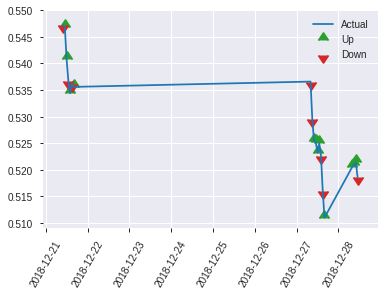


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20394565591944466
RMSE: 0.451603427710026
LogLoss: 0.5902142260894145
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 301.7551983180251
Residual deviance: 259.6942594793424
AIC: 361.6942594793424
AUC: 0.734375
pr_auc: 0.6803315637954087
Gini: 0.46875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4062548130077479: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   53   0.4274   (53.0/124.0)
1      20   76   0.2083   (20.0/96.0)
Total  91   129  0.3318   (73.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406255     0.675556  128
max f2                       0.186187     0.817391  190
max f0point5                 0.648402     0.643939  41
max accuracy                 0.519403     0.686364  84
max precision                0.905287     1         0
max recall                   0.0594433    1         212
max specificity              0.905287     1         0
max absolute_mcc             0.406255     0.366798  128
max min_per_class_accuracy   0.461467     0.645833  103
max mean_per_class_accuracy  0.406255     0.682124  128

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 45.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.884018           2.29167   2.29167            1                0.892932   1                           0.892932            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.864554           2.29167   2.29167            1                0.870025   1                           0.883769            0.0208333       0.0520833                  129.167   129.167
    3        0.0318182                   0.858767           2.29167   2.29167            1                0.863132   1                           0.877873            0.0208333       0.0729167                  129.167   129.167
    4        0.0409091                   0.832784           2.29167   2.29167            1                0.845185   1                           0.870609            0.0208333       0.09375                    129.167   129.167
    5        0.05                        0.810721           1.14583   2.08333            0.5              0.82507    0.909091                    0.862329            0.0104167       0.104167                   14.5833   108.333
    6        0.1                         0.735569           1.66667   1.875              0.727273         0.77587    0.818182                    0.8191              0.0833333       0.1875                     66.6667   87.5
    7        0.15                        0.685752           1.66667   1.80556            0.727273         0.708294   0.787879                    0.782164            0.0833333       0.270833                   66.6667   80.5556
    8        0.2                         0.640027           1.875     1.82292            0.818182         0.664483   0.795455                    0.752744            0.09375         0.364583                   87.5      82.2917
    9        0.3                         0.571613           0.9375    1.52778            0.409091         0.601343   0.666667                    0.702277            0.09375         0.458333                   -6.25     52.7778
    10       0.4                         0.506514           1.35417   1.48438            0.590909         0.543285   0.647727                    0.662529            0.135417        0.59375                    35.4167   48.4375
    11       0.5                         0.453831           0.625     1.3125             0.272727         0.476487   0.572727                    0.625321            0.0625          0.65625                    -37.5     31.25
    12       0.6                         0.399568           1.35417   1.31944            0.590909         0.424749   0.575758                    0.591892            0.135417        0.791667                   35.4167   31.9444
    13       0.7                         0.342934           0.520833  1.20536            0.227273         0.366783   0.525974                    0.559734            0.0520833       0.84375                    -47.9167  20.5357
    14       0.8                         0.274685           0.9375    1.17188            0.409091         0.310989   0.511364                    0.528641            0.09375         0.9375                     -6.25     17.1875
    15       0.9                         0.143693           0.416667  1.08796            0.181818         0.197426   0.474747                    0.491839            0.0416667       0.979167                   -58.3333  8.7963
    16       1                           0.00863098         0.208333  1                  0.0909091        0.0838509  0.436364                    0.451

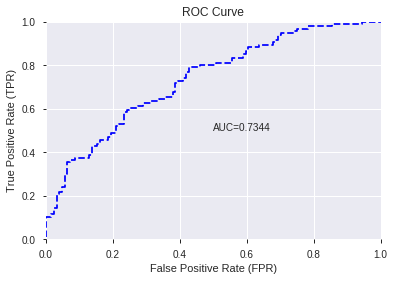

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


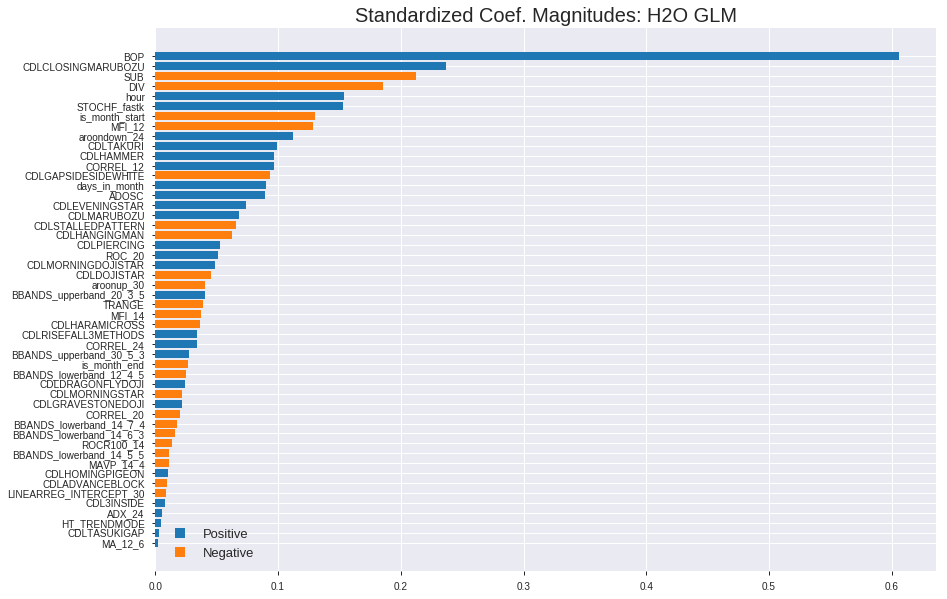

'log_likelihood'
--2019-08-28 18:31:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_183102_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_183102_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'DIV',
 'hour',
 'STOCHF_fastk',
 'is_month_start',
 'MFI_12',
 'aroondown_24',
 'CDLTAKURI',
 'CDLHAMMER',
 'CORREL_12',
 'CDLGAPSIDESIDEWHITE',
 'days_in_month',
 'ADOSC',
 'CDLEVENINGSTAR',
 'CDLMARUBOZU',
 'CDLSTALLEDPATTERN',
 'CDLHANGINGMAN',
 'CDLPIERCING',
 'ROC_20',
 'CDLMORNINGDOJISTAR',
 'CDLDOJISTAR',
 'aroonup_30',
 'BBANDS_upperband_20_3_5',
 'TRANGE',
 'MFI_14',
 'CDLHARAMICROSS',
 'CDLRISEFALL3METHODS',
 'CORREL_24',
 'BBANDS_upperband_30_5_3',
 'is_month_end',
 'BBANDS_lowerband_12_4_5',
 'CDLDRAGONFLYDOJI',
 'CDLMORNINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CORREL_20',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lowerband_14_6_3',
 'ROCR100_14',
 'BBANDS_lowerband_14_5_5',
 'MAVP_14_4',
 'CDLHOMINGPIGEON',
 'CDLADVANCEBLOCK',
 'LINEARREG_INTERCEPT_30',
 'CDL3INSIDE',
 'ADX_24',
 'HT_TRENDMODE',
 'CDLTASUKIGAP',
 'MA_12_6']

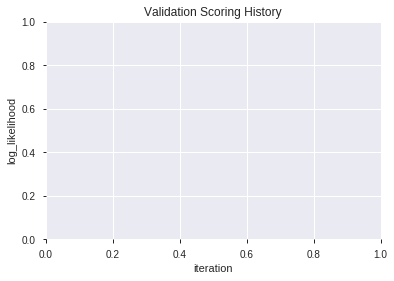

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_183211_model_6  0.733535  0.597135              0.331653  0.456235  0.208150
1               XGBoost_2_AutoML_20190828_183211  0.732779  0.596625              0.366431  0.455836  0.207787
2  XGBoost_grid_1_AutoML_20190828_183211_model_3  0.731015  0.596512              0.374496  0.455523  0.207501
3               XGBoost_3_AutoML_20190828_183211  0.730847  0.594229              0.341230  0.454667  0.206723
4  XGBoost_grid_1_AutoML_20190828_183211_model_2  0.730259  0.596654              0.291835  0.454490  0.206561
5  XGBoost_grid_1_AutoML_20190828_183211_model_4  0.729503  0.599834              0.321741  0.456327  0.208234
6  XGBoost_grid_1_AutoML_20190828_183211_model_1  0.722194  0.605234              0.363071  0.459590  0.211223
7  XGBoost_grid_1_AutoML_20190828_183211_model_7  0.717574  0.608572              0.338374  0.461871  0.213324
8  XGBoost_grid_1_AutoML_20190828_183211_model_5  0.714634  0.624993              0.382560  0.466423  0.217550
9               XGBoost_1_AutoML_20190828_183211  0.707241  0.617915              0.391129  0.466079  0.217230

variable  relative_importance  scaled_importance  percentage
0                       BOP          2235.073975           1.000000    0.235623
1              STOCHF_fastk           734.729004           0.328727    0.077456
2                       DIV           714.278076           0.319577    0.075300
3                    TRANGE           575.022278           0.257272    0.060619
4                    ROC_20           481.653534           0.215498    0.050776
5                    MFI_14           388.750702           0.173932    0.040982
6                       SUB           359.931396           0.161038    0.037944
7                    MFI_12           350.113831           0.156645    0.036909
8                      hour           339.298737           0.151806    0.035769
9                     ADOSC           309.401154           0.138430    0.032617
10               ROCR100_14           286.340881           0.128112    0.030186
11                CORREL_20           275.413025           0.123223    0.029034
12                CORREL_24           255.463562           0.114298    0.026931
13             aroondown_24           244.994965           0.109614    0.025828
14                   ADX_24           239.890274           0.107330    0.025289
15                CORREL_12           217.678879           0.097392    0.022948
16       CDLCLOSINGMARUBOZU           176.282501           0.078871    0.018584
17               aroonup_30           169.429291           0.075805    0.017861
18  BBANDS_upperband_20_3_5           169.349915           0.075769    0.017853
19  BBANDS_lowerband_14_5_5           130.235840           0.058269    0.013730
20  BBANDS_lowerband_12_4_5           129.385452           0.057889    0.013640
21   LINEARREG_INTERCEPT_30           125.199974           0.056016    0.013199
22                MAVP_14_4            90.971367           0.040702    0.009590
23            days_in_month            83.601921           0.037405    0.008813
24  BBANDS_upperband_30_5_3            82.172241           0.036765    0.008663
25                  MA_12_6            57.312523           0.025642    0.006042
26  BBANDS_lowerband_14_7_4            57.283947           0.025630    0.006039
27  BBANDS_lowerband_14_6_3            55.130165           0.024666    0.005812
28           is_month_start            46.113907           0.020632    0.004861
29                CDLHAMMER            34.496765           0.015434    0.003637
30                CDLTAKURI            29.923134           0.013388    0.003155
31         CDLDRAGONFLYDOJI            14.212467           0.006359    0.001498
32              CDLDOJISTAR             9.201274           0.004117    0.000970
33             HT_TRENDMODE             8.570591           0.003835    0.000904
34             is_month_end             5.453728           0.002440    0.000575
35        CDLGRAVESTONEDOJI             3.453319           0.001545    0.000364

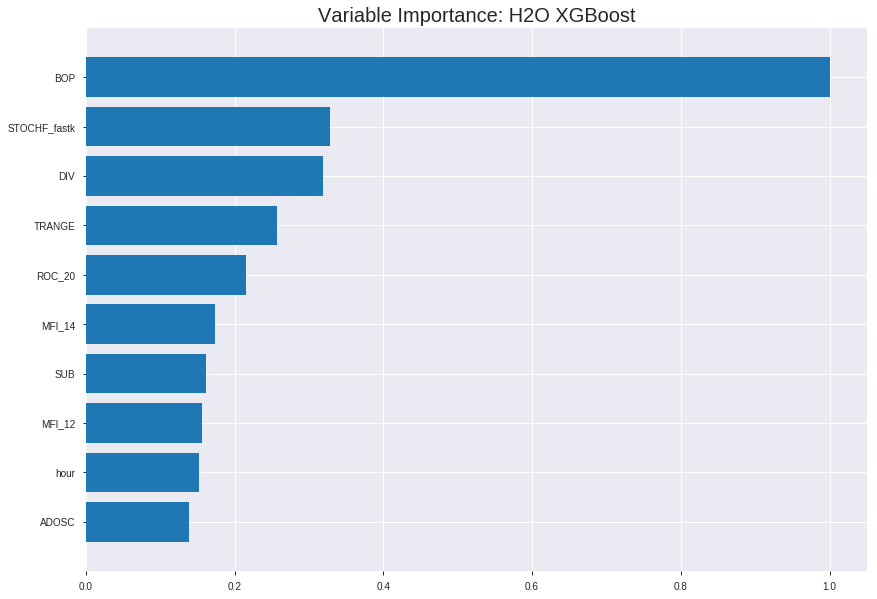

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_183211_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12823919823492855
RMSE: 0.3581050100667799
LogLoss: 0.4148473254804728
Mean Per-Class Error: 0.15376817792985453
AUC: 0.9226218990590248
pr_auc: 0.9161308051573122
Gini: 0.8452437981180496
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5005754033724467: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      713  122  0.1461   (122.0/835.0)
1      113  587  0.1614   (113.0/700.0)
Total  826  709  0.1531   (235.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500575     0.833215  191
max f2                       0.279048     0.879149  285
max f0point5                 0.591624     0.853147  148
max accuracy                 0.500575     0.846906  191
max precision                0.952864     1         0
max recall                   0.140535     1         350
max specificity              0.952864     1         0
max absolute_mcc             0.500575     0.691793  191
max min_per_class_accuracy   0.492565     0.843114  194
max mean_per_class_accuracy  0.500575     0.846232  191

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.921113           2.19286   2.19286            1                0.933649   1                           0.933649            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.904027           2.19286   2.19286            1                0.912258   1                           0.923299            0.0214286       0.0442857                  119.286   119.286
    3        0.0306189                   0.885647           2.19286   2.19286            1                0.895229   1                           0.913743            0.0228571       0.0671429                  119.286   119.286
    4        0.0403909                   0.866585           2.19286   2.19286            1                0.874125   1                           0.904158            0.0214286       0.0885714                  119.286   119.286
    5        0.0501629                   0.853639           2.19286   2.19286            1                0.860073   1                           0.89557             0.0214286       0.11                       119.286   119.286
    6        0.100326                    0.795044           2.19286   2.19286            1                0.82268    1                           0.859125            0.11            0.22                       119.286   119.286
    7        0.150489                    0.750585           2.16438   2.18336            0.987013         0.773035   0.995671                    0.830428            0.108571        0.328571                   116.438   118.336
    8        0.2                         0.71565            2.07744   2.15714            0.947368         0.731806   0.983713                    0.806014            0.102857        0.431429                   107.744   115.714
    9        0.300326                    0.626636           1.83687   2.05015            0.837662         0.675889   0.934924                    0.762545            0.184286        0.615714                   83.6874   105.015
    10       0.4                         0.547992           1.39024   1.88571            0.633987         0.590635   0.859935                    0.719707            0.138571        0.754286                   39.0243   88.5714
    11       0.500326                    0.461648           1.13915   1.73601            0.519481         0.506968   0.791667                    0.677048            0.114286        0.868571                   13.9147   73.6012
    12       0.6                         0.370662           0.616293  1.55               0.281046         0.416708   0.70684                     0.6338              0.0614286       0.93                       -38.3707  55
    13       0.699674                    0.268842           0.401307  1.38636            0.183007         0.320189   0.632216                    0.589123            0.04            0.97                       -59.8693  38.6359
    14       0.8                         0.182605           0.199351  1.2375             0.0909091        0.221759   0.564332                    0.543053            0.02            0.99                       -80.0649  23.75
    15       0.899674                    0.109795           0.100327  1.11151            0.0457516        0.144455   0.506879                    0.498893            0.01            1                          -89.9673  11.1513
    16       1                           0.0372105          0         1                  0                0.0785294  0.456026                    0.4567



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.186680613483585
RMSE: 0.4320655198966761
LogLoss: 0.5504486904228125
Mean Per-Class Error: 0.2824613716454323
AUC: 0.7963905165043685
pr_auc: 0.7838840409157041
Gini: 0.5927810330087371
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3056667149066925: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  107  0.4842   (107.0/221.0)
1      23   194  0.106    (23.0/217.0)
Total  137  301  0.2968   (130.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305667     0.749035  271
max f2                       0.159749     0.856798  340
max f0point5                 0.613649     0.730918  120
max accuracy                 0.4215       0.716895  217
max precision                0.916159     1         0
max recall                   0.0867873    1         383
max specificity              0.916159     1         0
max absolute_mcc             0.305667     0.441981  271
max min_per_class_accuracy   0.469342     0.710407  195
max mean_per_class_accuracy  0.416103     0.717539  221

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 45.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.899598           2.01843   2.01843            1                0.906958   1                           0.906958            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.881724           2.01843   2.01843            1                0.88988    1                           0.899367            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.85416            2.01843   2.01843            1                0.873631   1                           0.890176            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.813363           1.51382   1.9063             0.75             0.826241   0.944444                    0.875968            0.0138249       0.078341                   51.3825   90.6298
    5        0.0502283                   0.7793             2.01843   1.92669            1                0.789831   0.954545                    0.860307            0.0184332       0.0967742                  101.843   92.6686
    6        0.100457                    0.746756           1.65145   1.78907            0.818182         0.761143   0.886364                    0.810725            0.0829493       0.179724                   65.1445   78.9066
    7        0.150685                    0.705134           1.5597    1.71261            0.772727         0.722733   0.848485                    0.781394            0.078341        0.258065                   55.9698   71.261
    8        0.200913                    0.676711           1.65145   1.69732            0.818182         0.690582   0.840909                    0.758691            0.0829493       0.341014                   65.1445   69.7319
    9        0.30137                     0.616327           1.5597    1.65145            0.772727         0.643475   0.818182                    0.720286            0.156682        0.497696                   55.9698   65.1445
    10       0.399543                    0.562957           1.12657   1.52248            0.55814          0.592956   0.754286                    0.688999            0.110599        0.608295                   12.6567   52.2475
    11       0.5                         0.468801           1.05509   1.42857            0.522727         0.51026    0.707763                    0.653088            0.105991        0.714286                   5.50901   42.8571
    12       0.600457                    0.387339           0.91747   1.34306            0.454545         0.430308   0.665399                    0.615817            0.0921659       0.806452                   -8.25304  34.3064
    13       0.69863                     0.299676           0.938806  1.28626            0.465116         0.343811   0.637255                    0.577594            0.0921659       0.898618                   -6.11939  28.6256
    14       0.799087                    0.201536           0.550482  1.19376            0.272727         0.253747   0.591429                    0.536882            0.0552995       0.953917                   -44.9518  19.3759
    15       0.899543                    0.124551           0.366988  1.10143            0.181818         0.163888   0.545685                    0.495228            0.0368664       0.990783                   -63.3012  10.1429
    16       1                           0.0487069          0.091747  1                  0.0454545        0.0906613  0.495434                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:32:27  10.650 sec  0                  0.5              0.693147            0.5             0                  1                0.543974                         0.5                0.693147              0.5               0                    1                  0.504566
    2019-08-28 18:32:27  10.771 sec  5                  0.468553         0.631755            0.852019        0.82755            2.19286          0.244951                         0.475526           0.645029              0.787883          0.76236              2.01843            0.305936
    2019-08-28 18:32:27  10.841 sec  10                 0.446119         0.588834            0.866157        0.843867           2.19286          0.237785                         0.461229           0.616897              0.796422          0.771037             2.01843            0.287671
    2019-08-28 18:32:27  10.911 sec  15                 0.430621         0.558959            0.873435        0.856314           2.19286          0.22671                          0.45241            0.599026              0.796568          0.781623             2.01843            0.299087
    2019-08-28 18:32:27  10.989 sec  20                 0.417642         0.533327            0.877544        0.85855            2.19286          0.22671                          0.445714           0.584766              0.796568          0.784015             2.01843            0.30137
    2019-08-28 18:32:27  11.063 sec  25                 0.407533         0.512975            0.882375        0.865675           2.19286          0.218893                         0.441058           0.574456              0.797902          0.783477             2.01843            0.294521
    2019-08-28 18:32:27  11.136 sec  30                 0.398996         0.49534             0.886737        0.872526           2.19286          0.215635                         0.437935           0.567063              0.798465          0.78457              2.01843            0.299087
    2019-08-28 18:32:27  11.206 sec  35                 0.392452         0.48201             0.891866        0.876709           2.19286          0.194788                         0.434653           0.56003               0.801885          0.787966             2.01843            0.280822
    2019-08-28 18:32:27  11.283 sec  40                 0.385481         0.468251            0.898748        0.88578            2.19286          0.196743                         0.433362           0.55658               0.801228          0.785284             2.01843            0.276256
    2019-08-28 18:32:27  11.363 sec  45                 0.378865         0.455326            0.905035        0.895066           2.19286          0.181759                         0.432486           0.554569              0.800488          0.779942             2.01843            0.271689
    2019-08-28 18:32:27  11.440 sec  50                 0.373968         0.4454              0.908457        0.898992           2.19286          0.177199                         0.43171            0.552221              0.799122          0.779439             2.01843            0.276256
    2019-08-28 18:32:28  11.526 sec  55                 0.369501         0.436365            0.912226        0.902247           2.19286          0.177199                         0.431354           0.550889              0.799091          0.

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                2235.073974609375      1.0                    0.23562277679775237
STOCHF_fastk       734.72900390625        0.32872692906491335    0.07745555183447267
DIV                714.278076171875       0.3195769286771413     0.07529960333540531
TRANGE             575.0222778320312      0.2572721459622061     0.060619177424331656
ROC_20             481.6535339355469      0.21549780428172438    0.05077619103867847
---                ---                    ---                    ---
CDLDRAGONFLYDOJI   14.212467193603516     0.006358835257829636   0.0014982864206492706
CDLDOJISTAR        9.201273918151855      0.0041167648241978065  0.0009700035593007979
HT_TRENDMODE       8.57059097290039       0.0038345894007370727  0.0009035166024808983
is_month_end       5.453727722167969      0.0024400658699097956  0.0005749350958375693
CDLGRAVESTONEDOJI  3.4533193111419678     0.0015450581727369924  0.0003640508969743515


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6818181818181818)

('F1', 0.6695278969957081)

('auc', 0.7335349462365591)

('logloss', 0.5971348304886475)

('mean_per_class_error', 0.3237567204301075)

('rmse', 0.45623454990979867)

('mse', 0.20814996453139656)

xgboost prediction progress: |████████████████████████████████████████████| 100%


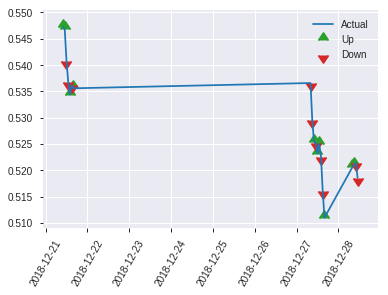


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20814996453139656
RMSE: 0.45623454990979867
LogLoss: 0.5971348304886475
Mean Per-Class Error: 0.3237567204301075
AUC: 0.7335349462365591
pr_auc: 0.6742875848386177
Gini: 0.46706989247311825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3088470995426178: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   59   0.4758   (59.0/124.0)
1      18   78   0.1875   (18.0/96.0)
Total  83   137  0.35     (77.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308847     0.669528  136
max f2                       0.141842     0.834783  190
max f0point5                 0.603205     0.639535  61
max accuracy                 0.603205     0.681818  61
max precision                0.907757     1         0
max recall                   0.141842     1         190
max specificity              0.907757     1         0
max absolute_mcc             0.383165     0.350796  118
max min_per_class_accuracy   0.426328     0.65625   104
max mean_per_class_accuracy  0.383165     0.676243  118

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 42.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.873151           2.29167   2.29167            1                0.893246   1                           0.893246            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.851725           2.29167   2.29167            1                0.857976   1                           0.879138            0.0208333       0.0520833                  129.167   129.167
    3        0.0318182                   0.843326           2.29167   2.29167            1                0.848161   1                           0.870287            0.0208333       0.0729167                  129.167   129.167
    4        0.0409091                   0.833789           2.29167   2.29167            1                0.839528   1                           0.863452            0.0208333       0.09375                    129.167   129.167
    5        0.05                        0.805756           1.14583   2.08333            0.5              0.819522   0.909091                    0.855465            0.0104167       0.104167                   14.5833   108.333
    6        0.1                         0.728027           1.45833   1.77083            0.636364         0.766664   0.772727                    0.811065            0.0729167       0.177083                   45.8333   77.0833
    7        0.15                        0.691652           1.66667   1.73611            0.727273         0.708015   0.757576                    0.776715            0.0833333       0.260417                   66.6667   73.6111
    8        0.2                         0.641934           1.66667   1.71875            0.727273         0.674302   0.75                        0.751111            0.0833333       0.34375                    66.6667   71.875
    9        0.3                         0.589202           1.14583   1.52778            0.5              0.618249   0.666667                    0.706824            0.114583        0.458333                   14.5833   52.7778
    10       0.4                         0.491516           0.833333  1.35417            0.363636         0.544743   0.590909                    0.666304            0.0833333       0.541667                   -16.6667  35.4167
    11       0.5                         0.409701           1.45833   1.375              0.636364         0.452573   0.6                         0.623558            0.145833        0.6875                     45.8333   37.5
    12       0.6                         0.315577           0.9375    1.30208            0.409091         0.369864   0.568182                    0.581275            0.09375         0.78125                    -6.25     30.2083
    13       0.7                         0.242196           0.833333  1.23512            0.363636         0.286343   0.538961                    0.539142            0.0833333       0.864583                   -16.6667  23.5119
    14       0.8                         0.194059           0.625     1.15885            0.272727         0.21307    0.505682                    0.498383            0.0625          0.927083                   -37.5     15.8854
    15       0.9                         0.129723           0.729167  1.11111            0.318182         0.156562   0.484848                    0.460403            0.0729167       1                          -27.0833  11.1111
    16       1                           0.0477669          0         1                  0                0.0905838  0.436364                    0.4

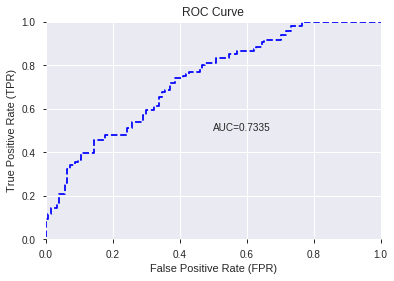

This function is available for GLM models only


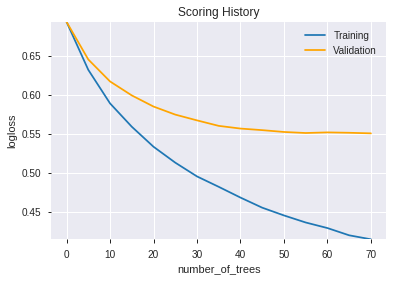

--2019-08-28 18:32:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_183211_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_183211_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'TRANGE',
 'ROC_20',
 'MFI_14',
 'SUB',
 'MFI_12',
 'hour',
 'ADOSC',
 'ROCR100_14',
 'CORREL_20',
 'CORREL_24',
 'aroondown_24',
 'ADX_24',
 'CORREL_12',
 'CDLCLOSINGMARUBOZU',
 'aroonup_30',
 'BBANDS_upperband_20_3_5',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_12_4_5',
 'LINEARREG_INTERCEPT_30',
 'MAVP_14_4',
 'days_in_month',
 'BBANDS_upperband_30_5_3',
 'MA_12_6',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lowerband_14_6_3',
 'is_month_start',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLDOJISTAR',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLGRAVESTONEDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 898 915 934] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


27

['hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI',
 'CDLENGULFING',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_183338_model_5  0.753696  0.584897              0.300403  0.444258  0.197365
1  DeepLearning_grid_1_AutoML_20190828_183338_model_8  0.751932  0.581727              0.306788  0.447044  0.199848
2  DeepLearning_grid_1_AutoML_20190828_183338_model_7  0.743028  0.628402              0.317708  0.460466  0.212029
3  DeepLearning_grid_1_AutoML_20190828_183338_model_9  0.738575  0.586399              0.303427  0.451065  0.203459
4  DeepLearning_grid_1_AutoML_20190828_183338_model_6  0.736391  0.584448              0.368112  0.451883  0.204198
5  DeepLearning_grid_1_AutoML_20190828_183338_model_3  0.734375  0.647377              0.329805  0.468082  0.219101
6  DeepLearning_grid_1_AutoML_20190828_183338_model_2  0.730343  0.658931              0.332661  0.469572  0.220497
7  DeepLearning_grid_1_AutoML_20190828_183338_model_4  0.723622  0.705837              0.344590  0.482453  0.232761
8  DeepLearning_grid_1_AutoML_20190828_183338_model_1  0.709761  0.790455              0.360719  0.497652  0.247657
9               DeepLearning_1_AutoML_20190828_183338  0.705729  0.661805              0.357527  0.476026  0.226601

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.057629
1   CDLCLOSINGMARUBOZU             0.854802           0.854802    0.049261
2                 hour             0.854794           0.854794    0.049261
3       STOCHRSI_fastk             0.761926           0.761926    0.043909
4         STOCHF_fastk             0.737431           0.737431    0.042497
5                  SUB             0.737092           0.737092    0.042478
6         CDLSHORTLINE             0.718262           0.718262    0.041392
7                  DIV             0.688015           0.688015    0.039649
8          CDLLONGLINE             0.674618           0.674618    0.038877
9       STOCHRSI_fastd             0.667314           0.667314    0.038456
10            WILLR_20             0.628147           0.628147    0.036199
11              ULTOSC             0.626741           0.626741    0.036118
12         CDLMARUBOZU             0.623915           0.623915    0.035955
13              TRANGE             0.622428           0.622428    0.035870
14               CCI_8             0.621491           0.621491    0.035816
15               RSI_8             0.599499           0.599499    0.034548
16               CMO_8             0.598671           0.598671    0.034501
17               ADOSC             0.569092           0.569092    0.032796
18           CDLTAKURI             0.566814           0.566814    0.032665
19            WILLR_14             0.551489           0.551489    0.031782
20         CDLBELTHOLD             0.541071           0.541071    0.031181
21             WILLR_8             0.536391           0.536391    0.030911
22              CCI_12             0.531512           0.531512    0.030630
23            WILLR_12             0.516576           0.516576    0.029770
24             CDLDOJI             0.512813           0.512813    0.029553
25   CDLLONGLEGGEDDOJI             0.505881           0.505881    0.029153
26        CDLENGULFING             0.505713           0.505713    0.029144

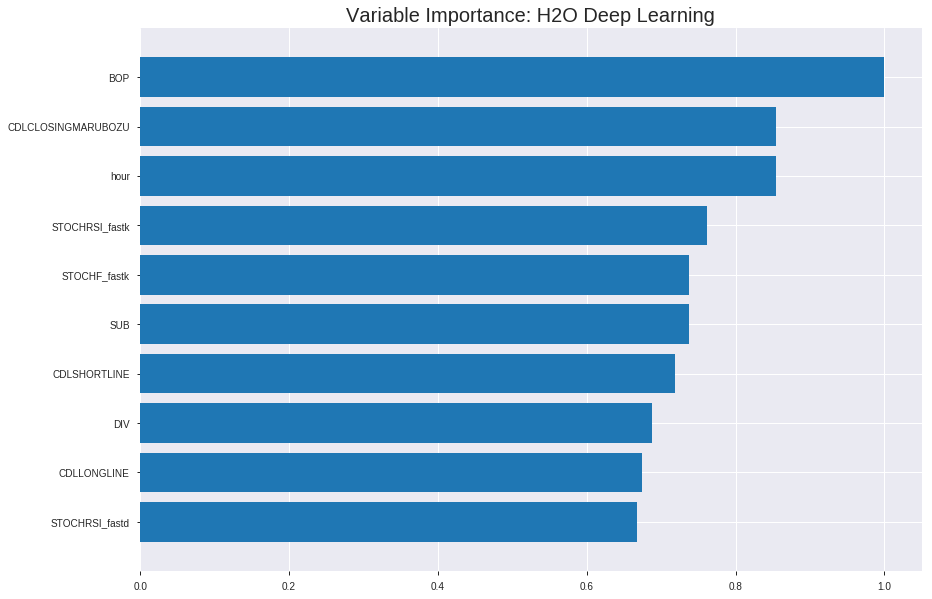

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_183338_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17780354373314844
RMSE: 0.4216675749131636
LogLoss: 0.5196421349097574
Mean Per-Class Error: 0.27245508982035926
AUC: 0.8083344739093241
pr_auc: 0.7753504632358389
Gini: 0.6166689478186482
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4425784040934831: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      476  359  0.4299   (359.0/835.0)
1      95   605  0.1357   (95.0/700.0)
Total  571  964  0.2958   (454.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442578     0.727163  229
max f2                       0.311467     0.846134  284
max f0point5                 0.543671     0.699333  169
max accuracy                 0.51363      0.725081  188
max precision                0.99649      1         0
max recall                   0.0421595    1         376
max specificity              0.99649      1         0
max absolute_mcc             0.490493     0.455841  202
max min_per_class_accuracy   0.525674     0.72      181
max mean_per_class_accuracy  0.490493     0.727545  202

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 47.27 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.991218           2.19286    2.19286            1                0.994115   1                           0.994115            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.98563            2.19286    2.19286            1                0.989111   1                           0.991694            0.0214286       0.0442857                  119.286   119.286
    3        0.0306189                   0.957832           2.0558     2.1462             0.9375           0.9732     0.978723                    0.985398            0.0214286       0.0657143                  105.58    114.62
    4        0.0403909                   0.93724            2.19286    2.15749            1                0.947293   0.983871                    0.976179            0.0214286       0.0871429                  119.286   115.749
    5        0.0501629                   0.915013           2.19286    2.16438            1                0.926979   0.987013                    0.966595            0.0214286       0.108571                   119.286   116.438
    6        0.100326                    0.795674           1.93655    2.05046            0.883117         0.862312   0.935065                    0.914453            0.0971429       0.205714                   93.6549   105.046
    7        0.150489                    0.681116           1.56633    1.88908            0.714286         0.734069   0.861472                    0.854325            0.0785714       0.284286                   56.6327   88.9085
    8        0.2                         0.632978           1.52923    1.8                0.697368         0.653477   0.820847                    0.804604            0.0757143       0.36                       52.9229   80
    9        0.300326                    0.584368           1.42393    1.67437            0.649351         0.607501   0.763557                    0.73876             0.142857        0.502857                   42.3933   67.4372
    10       0.4                         0.548426           1.24692    1.56786            0.568627         0.563903   0.714984                    0.695188            0.124286        0.627143                   24.6919   56.7857
    11       0.500326                    0.515273           1.18186    1.49046            0.538961         0.534429   0.679688                    0.662953            0.118571        0.745714                   18.1865   49.0458
    12       0.6                         0.463238           0.859944   1.38571            0.392157         0.490576   0.631922                    0.634317            0.0857143       0.831429                   -14.0056  38.5714
    13       0.699674                    0.386811           0.802614   1.30265            0.366013         0.425619   0.594041                    0.604586            0.08            0.911429                   -19.7386  30.2647
    14       0.8                         0.243433           0.598052   1.21429            0.272727         0.323867   0.553746                    0.569382            0.06            0.971429                   -40.1948  21.4286
    15       0.899674                    0.0701482          0.257983   1.10834            0.117647         0.141698   0.505431                    0.521999            0.0257143       0.997143                   -74.2017  10.8338
    16       1                           0.00191379         0.0284787  1                  0.012987         0.0305284  0.456026       



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19331083954961378
RMSE: 0.43967128579157155
LogLoss: 0.5674361623940224
Mean Per-Class Error: 0.2755072252225952
AUC: 0.7810747127635174
pr_auc: 0.7692590187402484
Gini: 0.5621494255270347
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4323366311280079: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  92   0.4163   (92.0/221.0)
1      33   184  0.1521   (33.0/217.0)
Total  162  276  0.2854   (125.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432337     0.74645   243
max f2                       0.136307     0.852181  332
max f0point5                 0.459081     0.709651  223
max accuracy                 0.459081     0.723744  223
max precision                0.994755     1         0
max recall                   0.0278989    1         377
max specificity              0.994755     1         0
max absolute_mcc             0.459081     0.454813  223
max min_per_class_accuracy   0.496258     0.696833  192
max mean_per_class_accuracy  0.459081     0.724493  223

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.982683           2.01843   2.01843            1                0.986691   1                           0.986691            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.940043           2.01843   2.01843            1                0.959575   1                           0.97464             0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.932542           1.61475   1.87426            0.8              0.935218   0.928571                    0.960561            0.0184332       0.0599078                  61.4747   87.4259
    4        0.0410959                   0.879068           2.01843   1.9063             1                0.900867   0.944444                    0.947295            0.0184332       0.078341                   101.843   90.6298
    5        0.0502283                   0.859618           2.01843   1.92669            1                0.869967   0.954545                    0.933236            0.0184332       0.0967742                  101.843   92.6686
    6        0.100457                    0.762382           1.74319   1.83494            0.863636         0.806115   0.909091                    0.869676            0.0875576       0.184332                   74.3192   83.4939
    7        0.150685                    0.65622            1.65145   1.77377            0.818182         0.703534   0.878788                    0.814295            0.0829493       0.267281                   65.1445   77.3775
    8        0.200913                    0.613269           1.3762    1.67438            0.681818         0.632514   0.829545                    0.76885             0.0691244       0.336406                   37.6204   67.4382
    9        0.30137                     0.56537            1.33033   1.5597             0.659091         0.590194   0.772727                    0.709298            0.133641        0.470046                   33.0331   55.9698
    10       0.399543                    0.534165           1.12657   1.45327            0.55814          0.547742   0.72                        0.669601            0.110599        0.580645                   12.6567   45.3272
    11       0.5                         0.495915           1.19271   1.40092            0.590909         0.517906   0.694064                    0.639124            0.119816        0.700461                   19.2711   40.0922
    12       0.600457                    0.447489           1.19271   1.36609            0.590909         0.473505   0.676806                    0.611416            0.119816        0.820276                   19.2711   36.6088
    13       0.69863                     0.365107           0.563284  1.25328            0.27907          0.413202   0.620915                    0.583562            0.0552995       0.875576                   -43.6716  25.3276
    14       0.799087                    0.213199           0.642229  1.17646            0.318182         0.300878   0.582857                    0.548025            0.0645161       0.940092                   -35.7771  17.6458
    15       0.899543                    0.0668349          0.412861  1.09118            0.204545         0.133485   0.540609                    0.501731            0.0414747       0.981567                   -58.7139  9.11834
    16       1                           0.00345754         0.183494  1                  0.0909091        0.0302864  0.495434                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:36:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:36:45  1 min 27.439 sec  1268 obs/sec      1.19674   1             1837       0.477255         0.647775            0.0818098      0.776511        0.739147           2.19286          0.295765                         0.512955           0.731721              -0.0525801       0.759295          0.737458             2.01843            0.312785
    2019-08-28 18:36:50  1 min 32.712 sec  2354 obs/sec      9.60651   8             14746      0.427891         0.535382            0.261929       0.795364        0.765186           2.19286          0.293811                         0.445348           0.579281              0.206595         0.776498          0.765242             2.01843            0.296804
    2019-08-28 18:36:55  1 min 38.217 sec  2771 obs/sec      20.4137   17            31335      0.421668         0.519642            0.283242       0.808334        0.77535            2.19286          0.295765                         0.439671           0.567436              0.226692         0.781075          0.769259             2.01843            0.285388
    2019-08-28 18:37:01  1 min 43.461 sec  2983 obs/sec      31.2606   26            47985      0.413372         0.500906            0.311168       0.819045        0.770941           2.19286          0.27557                          0.445668           0.580733              0.205452         0.775205          0.756163             2.01843            0.269406
    2019-08-28 18:37:06  1 min 48.530 sec  3124 obs/sec      42.0879   35            64605      0.40936          0.491324            0.324473       0.836139        0.806293           2.19286          0.281433                         0.456457           0.614334              0.16652          0.766311          0.73853              1.61475            0.324201
    2019-08-28 18:37:11  1 min 53.954 sec  3236 obs/sec      54.0599   45            82982      0.394705         0.46132             0.371975       0.851453        0.812296           2.19286          0.244951                         0.452111           0.616811              0.182314         0.769783          0.746109             1.61475            0.353881
    2019-08-28 18:37:16  1 min 59.227 sec  3329 obs/sec      66.0482   55            101384     0.386961         0.446663            0.396376       0.864335        0.80812            2.19286          0.236482                         0.448684           0.608309              0.194665         0.768438          0.755193             2.01843            0.321918
    2019-08-28 18:37:17  1 min 59.700 sec  3327 obs/sec      66.0482   55            101384     0.421668         0.519642            0.283242       0.808334        0.77535            2.19286          0.295765                         0.439671           0.567436              0.226692         0.781075          0.769259             2.01843            0.285388

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.057628593801754766
CDLCLOSINGMARUBOZU  0.854802131652832      0.854802131652832    0.049261044825895155
hour                0.8547941446304321     0.8547941446304321   0.04926058454502558
STOCHRSI_fastk      0.7619262337684631     0.7619262337684631   0.04390873743274361
STOCHF_fastk        0.7374314069747925     0.7374314069747925   0.04249713500920682
---                 ---                    ---                  ---
CCI_12              0.5315118432044983     0.5315118432044983   0.030630280112854
WILLR_12            0.5165756940841675     0.5165756940841675   0.02976953084223602
CDLDOJI             0.5128127336502075     0.5128127336502075   0.029552676723895267
CDLLONGLEGGEDDOJI   0.5058807134628296     0.5058807134628296   0.0291531941482913
CDLENGULFING        0.5057127475738525     0.5057127475738525   0.02914351451030289


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6909090909090909)

('F1', 0.702928870292887)

('auc', 0.7536962365591398)

('logloss', 0.584896500012381)

('mean_per_class_error', 0.29872311827957)

('rmse', 0.44425819406279166)

('mse', 0.19736534299193303)

deeplearning prediction progress: |███████████████████████████████████████| 100%


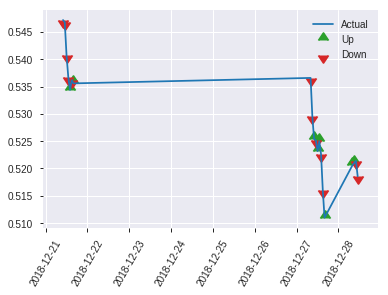


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19736534299193303
RMSE: 0.44425819406279166
LogLoss: 0.584896500012381
Mean Per-Class Error: 0.29872311827957
AUC: 0.7536962365591398
pr_auc: 0.6742613473462192
Gini: 0.5073924731182795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3617976334222416: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   59   0.4758   (59.0/124.0)
1      12   84   0.125    (12.0/96.0)
Total  77   143  0.3227   (71.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361798     0.702929  142
max f2                       0.139501     0.825933  178
max f0point5                 0.535042     0.65      75
max accuracy                 0.535042     0.690909  75
max precision                0.993425     1         0
max recall                   0.0257326    1         203
max specificity              0.993425     1         0
max absolute_mcc             0.361798     0.415065  142
max min_per_class_accuracy   0.488336     0.666667  104
max mean_per_class_accuracy  0.38894      0.701277  137

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 43.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.99071            1.52778   1.52778            0.666667         0.991975   0.666667                    0.991975            0.0208333       0.0208333                  52.7778   52.7778
    2        0.0227273                   0.989353           2.29167   1.83333            1                0.990374   0.8                         0.991335            0.0208333       0.0416667                  129.167   83.3333
    3        0.0318182                   0.984306           2.29167   1.96429            1                0.987235   0.857143                    0.990163            0.0208333       0.0625                     129.167   96.4286
    4        0.0409091                   0.952534           2.29167   2.03704            1                0.972807   0.888889                    0.986306            0.0208333       0.0833333                  129.167   103.704
    5        0.05                        0.895031           2.29167   2.08333            1                0.931076   0.909091                    0.976264            0.0208333       0.104167                   129.167   108.333
    6        0.1                         0.739695           1.875     1.97917            0.818182         0.849843   0.863636                    0.913054            0.09375         0.197917                   87.5      97.9167
    7        0.15                        0.639438           1.25      1.73611            0.545455         0.674447   0.757576                    0.833518            0.0625          0.260417                   25        73.6111
    8        0.2                         0.600716           1.45833   1.66667            0.636364         0.617396   0.727273                    0.779488            0.0729167       0.333333                   45.8333   66.6667
    9        0.3                         0.551467           1.35417   1.5625             0.590909         0.577213   0.681818                    0.712063            0.135417        0.46875                    35.4167   56.25
    10       0.4                         0.515987           1.14583   1.45833            0.5              0.533442   0.636364                    0.667408            0.114583        0.583333                   14.5833   45.8333
    11       0.5                         0.483503           1.04167   1.375              0.454545         0.498984   0.6                         0.633723            0.104167        0.6875                     4.16667   37.5
    12       0.6                         0.408168           1.25      1.35417            0.545455         0.455429   0.590909                    0.604007            0.125           0.8125                     25        35.4167
    13       0.7                         0.308982           0.833333  1.27976            0.363636         0.358745   0.558442                    0.56897             0.0833333       0.895833                   -16.6667  27.9762
    14       0.8                         0.150429           0.416667  1.17188            0.181818         0.223591   0.511364                    0.525797            0.0416667       0.9375                     -58.3333  17.1875
    15       0.9                         0.0394009          0.416667  1.08796            0.181818         0.092684   0.474747                    0.477674            0.0416667       0.979167                   -58.3333  8.7963
    16       1                           0.00198952         0.208333  1                  0.0909091        0.0191344  0.436364                    0.431

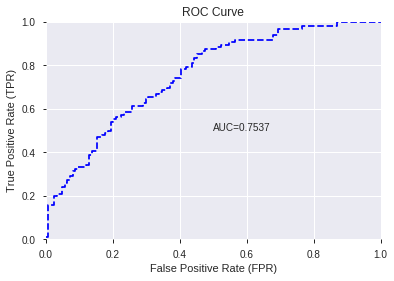

This function is available for GLM models only


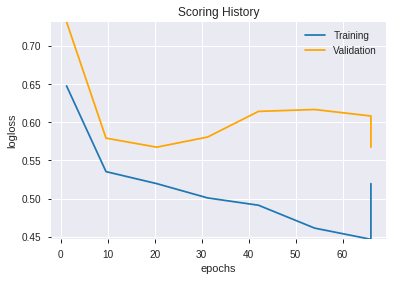

--2019-08-28 18:41:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_183338_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_183338_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'SUB',
 'CDLSHORTLINE',
 'DIV',
 'CDLLONGLINE',
 'STOCHRSI_fastd',
 'WILLR_20',
 'ULTOSC',
 'CDLMARUBOZU',
 'TRANGE',
 'CCI_8',
 'RSI_8',
 'CMO_8',
 'ADOSC',
 'CDLTAKURI',
 'WILLR_14',
 'CDLBELTHOLD',
 'WILLR_8',
 'CCI_12',
 'WILLR_12',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLENGULFING']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_184222_model_1  0.752772  0.574861              0.300571  0.445656  0.19861

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.538490           1.000000    0.181076
1                  SUB             0.225512           0.418786    0.075832
2   CDLCLOSINGMARUBOZU             0.197985           0.367668    0.066576
3         STOCHF_fastk             0.195915           0.363824    0.065880
4       STOCHRSI_fastk             0.176302           0.327401    0.059284
5                  DIV             0.154731           0.287343    0.052031
6                CCI_8             0.146542           0.272135    0.049277
7          CDLLONGLINE             0.140797           0.261466    0.047345
8                 hour             0.140046           0.260072    0.047093
9            CDLTAKURI             0.123458           0.229266    0.041515
10         CDLBELTHOLD             0.098122           0.182216    0.032995
11               ADOSC             0.097729           0.181487    0.032863
12               CMO_8             0.091546           0.170006    0.030784
13               RSI_8             0.090668           0.168374    0.030488
14         CDLMARUBOZU             0.085750           0.159241    0.028835
15              CCI_12             0.058064           0.107828    0.019525
16            WILLR_14             0.054656           0.101499    0.018379
17              ULTOSC             0.050888           0.094501    0.017112
18        CDLSHORTLINE             0.049549           0.092014    0.016662
19             CDLDOJI             0.048624           0.090297    0.016351
20        CDLENGULFING             0.046637           0.086607    0.015682
21              TRANGE             0.031457           0.058417    0.010578
22      STOCHRSI_fastd             0.027911           0.051833    0.009386
23   CDLLONGLEGGEDDOJI             0.027804           0.051633    0.009350
24            WILLR_20             0.027485           0.051041    0.009242
25             WILLR_8             0.024405           0.045322    0.008207
26            WILLR_12             0.022762           0.042270    0.007654

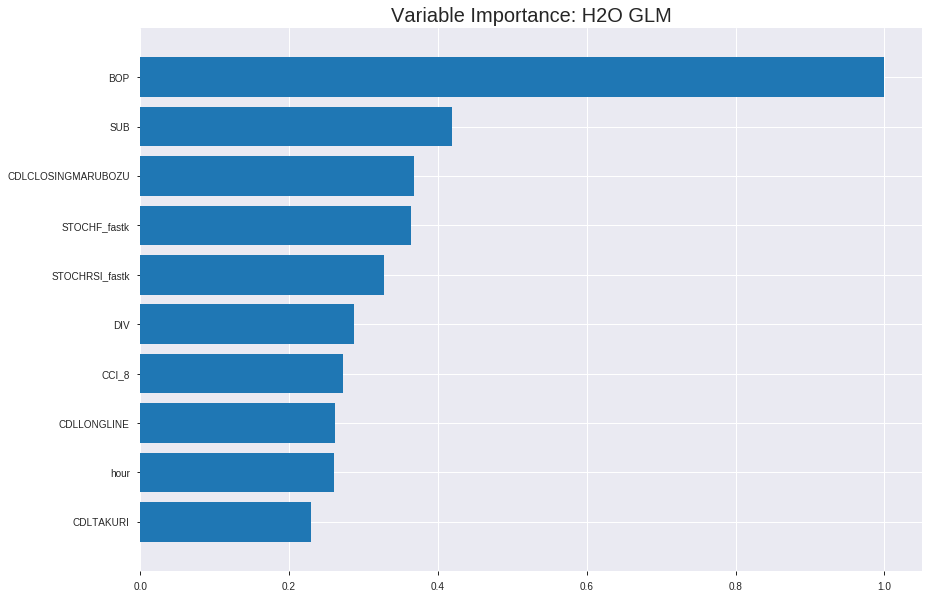

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_184222_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18902057643216025
RMSE: 0.4347649668868919
LogLoss: 0.5578311149263216
Null degrees of freedom: 1534
Residual degrees of freedom: 1507
Null deviance: 2116.073526703686
Residual deviance: 1712.5415228238076
AIC: 1768.5415228238076
AUC: 0.7831582549187339
pr_auc: 0.7474556145872344
Gini: 0.5663165098374678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38211573728408144: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      479  356  0.4263   (356.0/835.0)
1      116  584  0.1657   (116.0/700.0)
Total  595  940  0.3075   (472.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382116     0.712195  240
max f2                       0.198915     0.830496  333
max f0point5                 0.477335     0.686111  192
max accuracy                 0.477335     0.715309  192
max precision                0.934803     1         0
max recall                   0.031315     1         396
max specificity              0.934803     1         0
max absolute_mcc             0.450839     0.429618  204
max min_per_class_accuracy   0.470053     0.71      195
max mean_per_class_accuracy  0.450839     0.715624  204

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.890439           2.19286   2.19286            1                0.905601   1                           0.905601            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.879239           2.04667   2.12212            0.933333         0.884938   0.967742                    0.895603            0.02            0.0428571                  104.667   112.212
    3        0.0306189                   0.849451           2.19286   2.1462             1                0.866457   0.978723                    0.885681            0.0228571       0.0657143                  119.286   114.62
    4        0.0403909                   0.828865           1.75429   2.05138            0.8              0.837514   0.935484                    0.874028            0.0171429       0.0828571                  75.4286   105.138
    5        0.0501629                   0.806853           1.90048   2.02199            0.866667         0.818045   0.922078                    0.863122            0.0185714       0.101429                   90.0476   102.199
    6        0.100326                    0.746004           1.85111   1.93655            0.844156         0.772475   0.883117                    0.817798            0.0928571       0.194286                   85.1113   93.6549
    7        0.150489                    0.706294           1.53785   1.80365            0.701299         0.726682   0.822511                    0.787426            0.0771429       0.271429                   53.7848   80.3649
    8        0.2                         0.672497           1.6735    1.77143            0.763158         0.69003    0.807818                    0.763315            0.0828571       0.354286                   67.3496   77.1429
    9        0.300326                    0.588637           1.36698   1.63632            0.623377         0.631636   0.746204                    0.719327            0.137143        0.491429                   36.6976   63.6319
    10       0.4                         0.522231           1.18959   1.525              0.542484         0.556088   0.69544                     0.67865             0.118571        0.61                       18.9589   52.5
    11       0.500326                    0.454072           1.22458   1.46476            0.558442         0.48985    0.667969                    0.640792            0.122857        0.732857                   22.4583   46.476
    12       0.6                         0.389711           0.874276  1.36667            0.398693         0.421991   0.623236                    0.604444            0.0871429       0.82                       -12.5724  36.6667
    13       0.699674                    0.323021           0.71662   1.27406            0.326797         0.354196   0.581006                    0.568794            0.0714286       0.891429                   -28.338   27.4062
    14       0.8                         0.241395           0.598052  1.18929            0.272727         0.283159   0.542345                    0.532973            0.06            0.951429                   -40.1948  18.9286
    15       0.899674                    0.146217           0.30098   1.09087            0.137255         0.200257   0.497466                    0.496112            0.03            0.981429                   -69.902   9.0871
    16       1                           0.0188538          0.185111  1                  0.0844156        0.0965574  0.456026                    0.456



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19831394934319305
RMSE: 0.445324543836507
LogLoss: 0.5849570025333088
Null degrees of freedom: 437
Residual degrees of freedom: 410
Null deviance: 609.8925503857407
Residual deviance: 512.4223342191787
AIC: 568.4223342191787
AUC: 0.7762266196801301
pr_auc: 0.7730419573663145
Gini: 0.5524532393602601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34414163205836756: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  100  0.4525   (100.0/221.0)
1      35   182  0.1613   (35.0/217.0)
Total  156  282  0.3082   (135.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344142     0.729459  253
max f2                       0.191129     0.844103  332
max f0point5                 0.520519     0.7259    144
max accuracy                 0.520519     0.707763  144
max precision                0.932524     1         0
max recall                   0.00809979   1         399
max specificity              0.932524     1         0
max absolute_mcc             0.520519     0.428422  144
max min_per_class_accuracy   0.45073      0.682028  193
max mean_per_class_accuracy  0.520519     0.70657   144

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 43.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.865087           2.01843   2.01843            1                0.900479   1                           0.900479            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.820356           2.01843   2.01843            1                0.841577   1                           0.8743              0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.775592           2.01843   2.01843            1                0.792712   1                           0.845161            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.769196           1.51382   1.9063             0.75             0.772895   0.944444                    0.829102            0.0138249       0.078341                   51.3825   90.6298
    5        0.0502283                   0.763627           2.01843   1.92669            1                0.765822   0.954545                    0.817597            0.0184332       0.0967742                  101.843   92.6686
    6        0.100457                    0.695739           1.65145   1.78907            0.818182         0.732356   0.886364                    0.774976            0.0829493       0.179724                   65.1445   78.9066
    7        0.150685                    0.654091           1.65145   1.74319            0.818182         0.676687   0.863636                    0.742213            0.0829493       0.262673                   65.1445   74.3192
    8        0.200913                    0.617809           1.74319   1.74319            0.863636         0.633606   0.863636                    0.715061            0.0875576       0.35023                    74.3192   74.3192
    9        0.30137                     0.562365           1.3762    1.62086            0.681818         0.587189   0.80303                     0.672437            0.138249        0.488479                   37.6204   62.0863
    10       0.399543                    0.50794            1.07963   1.48787            0.534884         0.533639   0.737143                    0.638333            0.105991        0.59447                    7.9627    48.7874
    11       0.5                         0.440231           0.91747   1.37327            0.454545         0.478189   0.680365                    0.606158            0.0921659       0.686636                   -8.25304  37.3272
    12       0.600457                    0.367778           1.10096   1.32771            0.545455         0.403794   0.657795                    0.572302            0.110599        0.797235                   10.0964   32.7715
    13       0.69863                     0.304977           0.797985  1.25328            0.395349         0.336474   0.620915                    0.539163            0.078341        0.875576                   -20.2015  25.3276
    14       0.799087                    0.225893           0.642229  1.17646            0.318182         0.268741   0.582857                    0.505167            0.0645161       0.940092                   -35.7771  17.6458
    15       0.899543                    0.147539           0.229367  1.07069            0.113636         0.1868     0.530457                    0.469613            0.0230415       0.963134                   -77.0633  7.06917
    16       1                           0.00809979         0.366988  1                  0.181818         0.0869169  0.495434                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 18:42:23  0.000 sec   2            20        28            1.35806           1.37251
    2019-08-28 18:42:23  0.009 sec   4            13        28            1.34755           1.36235
    2019-08-28 18:42:23  0.017 sec   6            7.9       28            1.33299           1.34835
    2019-08-28 18:42:23  0.023 sec   8            4.9       28            1.31397           1.33023
    2019-08-28 18:42:23  0.030 sec   10           3         28            1.29069           1.30836
    2019-08-28 18:42:23  0.036 sec   12           1.9       28            1.26424           1.28399
    2019-08-28 18:42:23  0.042 sec   14           1.2       28            1.23635           1.25899
    2019-08-28 18:42:23  0.047 sec   16           0.73      28            1.20912           1.23541
    2019-08-28 18:42:23  0.053 sec   18           0.45      28            1.1845            1.215
    2019-08-28 18:42:23  0.059 sec   20           0.28      28            1.16368           1.19862
    2019-08-28 18:42:23  0.068 sec   22           0.17      28            1.14688           1.18628
    2019-08-28 18:42:23  0.074 sec   24           0.11      28            1.1337            1.17762
    2019-08-28 18:42:23  0.080 sec   26           0.067     28            1.12349           1.17226
    2019-08-28 18:42:23  0.086 sec   28           0.042     28            1.11566           1.16991
    2019-08-28 18:42:23  0.092 sec   30           0.026     28            1.10971           1.17033
    2019-08-28 18:42:23  0.099 sec   32           0.016     28            1.10528           1.17272
    2019-08-28 18:42:23  0.107 sec   34           0.01      28            1.10206           1.17591
    2019-08-28 18:42:23  0.113 sec   36           0.0062    28            1.09979           1.17876
    2019-08-28 18:42:23  0.119 sec   38           0.0039    28            1.09825           1.18047

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6909090909090909)

('F1', 0.6905829596412557)

('auc', 0.7527721774193549)

('logloss', 0.5748607720356851)

('mean_per_class_error', 0.30006720430107525)

('rmse', 0.44565646529459446)

('mse', 0.19860968505887205)

glm prediction progress: |████████████████████████████████████████████████| 100%


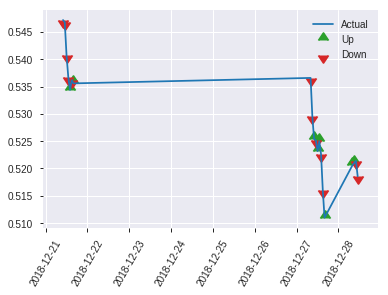


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19860968505887205
RMSE: 0.44565646529459446
LogLoss: 0.5748607720356851
Null degrees of freedom: 219
Residual degrees of freedom: 192
Null deviance: 301.7551983180251
Residual deviance: 252.93873969570149
AIC: 308.9387396957015
AUC: 0.7527721774193549
pr_auc: 0.692903046076611
Gini: 0.5055443548387097
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3430148453907292: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   50   0.4032   (50.0/124.0)
1      19   77   0.1979   (19.0/96.0)
Total  93   127  0.3136   (69.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343015     0.690583  126
max f2                       0.158875     0.826087  190
max f0point5                 0.363261     0.642361  119
max accuracy                 0.363261     0.690909  119
max precision                0.89685      1         0
max recall                   0.101901     1         205
max specificity              0.89685      1         0
max absolute_mcc             0.343015     0.400425  126
max min_per_class_accuracy   0.415943     0.669355  105
max mean_per_class_accuracy  0.363261     0.699933  119

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 41.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.8497             2.29167   2.29167            1                0.867808  1                           0.867808            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.839613           2.29167   2.29167            1                0.843835  1                           0.858219            0.0208333       0.0520833                  129.167   129.167
    3        0.0318182                   0.823062           1.14583   1.96429            0.5              0.828345  0.857143                    0.849683            0.0104167       0.0625                     14.5833   96.4286
    4        0.0409091                   0.816559           2.29167   2.03704            1                0.821998  0.888889                    0.843531            0.0208333       0.0833333                  129.167   103.704
    5        0.05                        0.785485           2.29167   2.08333            1                0.805727  0.909091                    0.836658            0.0208333       0.104167                   129.167   108.333
    6        0.1                         0.706382           1.875     1.97917            0.818182         0.739418  0.863636                    0.788038            0.09375         0.197917                   87.5      97.9167
    7        0.15                        0.645208           1.25      1.73611            0.545455         0.687269  0.757576                    0.754448            0.0625          0.260417                   25        73.6111
    8        0.2                         0.594719           1.66667   1.71875            0.727273         0.620214  0.75                        0.72089             0.0833333       0.34375                    66.6667   71.875
    9        0.3                         0.517675           1.35417   1.59722            0.590909         0.554057  0.69697                     0.665279            0.135417        0.479167                   35.4167   59.7222
    10       0.4                         0.471984           0.833333  1.40625            0.363636         0.498244  0.613636                    0.62352             0.0833333       0.5625                     -16.6667  40.625
    11       0.5                         0.39341            1.35417   1.39583            0.590909         0.427997  0.609091                    0.584415            0.135417        0.697917                   35.4167   39.5833
    12       0.6                         0.334955           1.04167   1.33681            0.454545         0.363984  0.583333                    0.547677            0.104167        0.802083                   4.16667   33.6806
    13       0.7                         0.288804           0.833333  1.26488            0.363636         0.315581  0.551948                    0.51452             0.0833333       0.885417                   -16.6667  26.4881
    14       0.8                         0.219789           0.625     1.1849             0.272727         0.257203  0.517045                    0.482356            0.0625          0.947917                   -37.5     18.4896
    15       0.9                         0.125123           0.416667  1.09954            0.181818         0.17603   0.479798                    0.448319            0.0416667       0.989583                   -58.3333  9.9537
    16       1                           0.0335695          0.104167  1                  0.0454545        0.080557  0.436364                    0.411543            

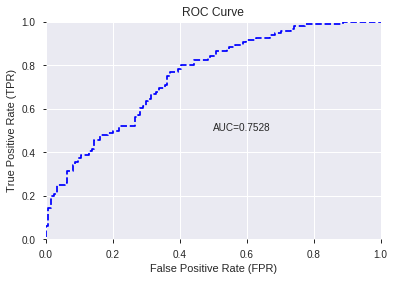

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


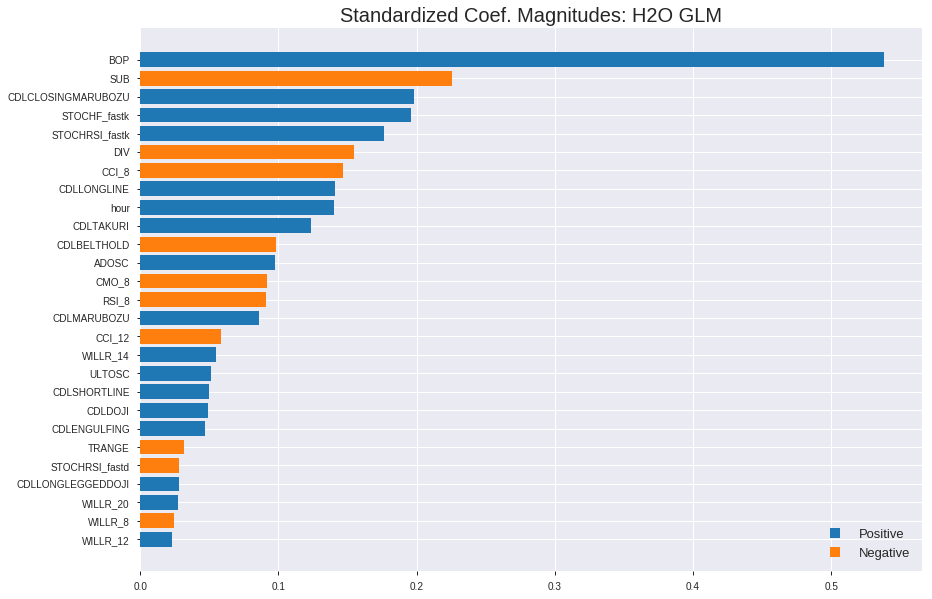

'log_likelihood'
--2019-08-28 18:42:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_184222_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_184222_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'DIV',
 'CCI_8',
 'CDLLONGLINE',
 'hour',
 'CDLTAKURI',
 'CDLBELTHOLD',
 'ADOSC',
 'CMO_8',
 'RSI_8',
 'CDLMARUBOZU',
 'CCI_12',
 'WILLR_14',
 'ULTOSC',
 'CDLSHORTLINE',
 'CDLDOJI',
 'CDLENGULFING',
 'TRANGE',
 'STOCHRSI_fastd',
 'CDLLONGLEGGEDDOJI',
 'WILLR_20',
 'WILLR_8',
 'WILLR_12']

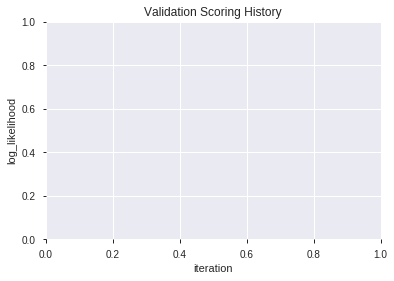

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_184330_model_3  0.750000  0.585086              0.286626  0.451209  0.203589
1  XGBoost_grid_1_AutoML_20190828_184330_model_6  0.749916  0.580291              0.303259  0.449019  0.201618
2  XGBoost_grid_1_AutoML_20190828_184330_model_2  0.745548  0.588281              0.294691  0.451694  0.204028
3               XGBoost_3_AutoML_20190828_184330  0.738995  0.594165              0.285954  0.455533  0.207511
4  XGBoost_grid_1_AutoML_20190828_184330_model_4  0.738743  0.602714              0.307460  0.457120  0.208959
5               XGBoost_2_AutoML_20190828_184330  0.734627  0.605106              0.289651  0.458716  0.210420
6  XGBoost_grid_1_AutoML_20190828_184330_model_5  0.734123  0.624727              0.307292  0.466665  0.217776
7               XGBoost_1_AutoML_20190828_184330  0.734039  0.599248              0.305612  0.457375  0.209192
8  XGBoost_grid_1_AutoML_20190828_184330_model_1  0.731855  0.592006              0.300403  0.455413  0.207401
9  XGBoost_grid_1_AutoML_20190828_184330_model_7  0.718834  0.618376              0.318716  0.466656  0.217768

variable  relative_importance  scaled_importance  percentage
0                  BOP          1561.368408           1.000000    0.234847
1                  DIV           543.701355           0.348221    0.081779
2       STOCHRSI_fastk           484.214478           0.310122    0.072831
3         STOCHF_fastk           404.673523           0.259179    0.060867
4                  SUB           385.998901           0.247218    0.058059
5               TRANGE           384.970703           0.246560    0.057904
6                CCI_8           340.374359           0.217997    0.051196
7               ULTOSC           271.705750           0.174018    0.040868
8               CCI_12           266.800659           0.170876    0.040130
9                CMO_8           257.205078           0.164731    0.038687
10               ADOSC           213.534576           0.136761    0.032118
11             WILLR_8           209.888092           0.134426    0.031570
12      STOCHRSI_fastd           196.547623           0.125882    0.029563
13            WILLR_20           196.162003           0.125635    0.029505
14                hour           181.883057           0.116490    0.027357
15  CDLCLOSINGMARUBOZU           150.105682           0.096137    0.022578
16            WILLR_14           149.523804           0.095765    0.022490
17               RSI_8           129.050827           0.082652    0.019411
18            WILLR_12           106.818024           0.068413    0.016067
19        CDLSHORTLINE            66.348953           0.042494    0.009980
20         CDLLONGLINE            42.776051           0.027397    0.006434
21         CDLBELTHOLD            41.903923           0.026838    0.006303
22           CDLTAKURI            40.150528           0.025715    0.006039
23             CDLDOJI            11.327021           0.007255    0.001704
24   CDLLONGLEGGEDDOJI             6.048592           0.003874    0.000910
25        CDLENGULFING             5.300148           0.003395    0.000797
26         CDLMARUBOZU             0.059632           0.000038    0.000009

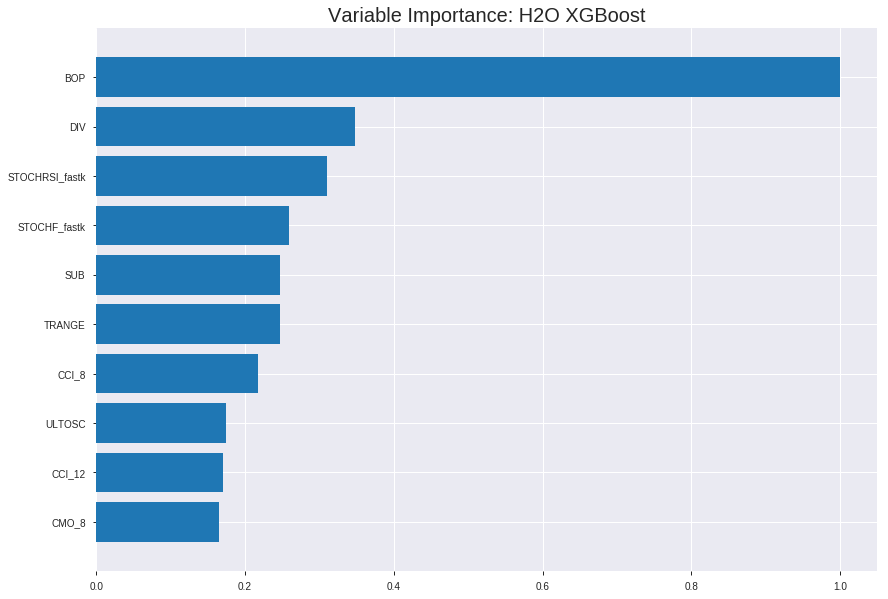

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_184330_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13798234064087253
RMSE: 0.3714597429612966
LogLoss: 0.43669637863041333
Mean Per-Class Error: 0.18834901625320788
AUC: 0.9035594525235244
pr_auc: 0.8883947409840603
Gini: 0.8071189050470489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4587889164686203: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      646  189  0.2263   (189.0/835.0)
1      110  590  0.1571   (110.0/700.0)
Total  756  779  0.1948   (299.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458789     0.797836  209
max f2                       0.313154     0.881586  276
max f0point5                 0.594037     0.826672  146
max accuracy                 0.55026      0.815635  165
max precision                0.950901     1         0
max recall                   0.137338     1         355
max specificity              0.950901     1         0
max absolute_mcc             0.55026      0.630316  165
max min_per_class_accuracy   0.488745     0.808571  195
max mean_per_class_accuracy  0.504946     0.811651  187

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.91461            2.19286    2.19286            1                0.928273   1                           0.928273            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.904              2.19286    2.19286            1                0.909833   1                           0.91935             0.0214286       0.0442857                  119.286   119.286
    3        0.0306189                   0.891535           2.19286    2.19286            1                0.897314   1                           0.911849            0.0228571       0.0671429                  119.286   119.286
    4        0.0403909                   0.878042           2.19286    2.19286            1                0.885843   1                           0.905557            0.0214286       0.0885714                  119.286   119.286
    5        0.0501629                   0.854134           2.04667    2.16438            0.933333         0.867492   0.987013                    0.898142            0.02            0.108571                   104.667   116.438
    6        0.100326                    0.791844           2.1359     2.15014            0.974026         0.822502   0.980519                    0.860322            0.107143        0.215714                   113.59    115.014
    7        0.150489                    0.747987           2.10742    2.1359             0.961039         0.772442   0.974026                    0.831028            0.105714        0.321429                   110.742   113.59
    8        0.2                         0.704302           1.99088    2.1                0.907895         0.727477   0.957655                    0.805393            0.0985714       0.42                       99.0883   110
    9        0.300326                    0.623323           1.7372     1.9788             0.792208         0.663395   0.902386                    0.757958            0.174286        0.594286                   73.7199   97.8804
    10       0.4                         0.541714           1.33291    1.81786            0.607843         0.578004   0.82899                     0.713116            0.132857        0.727143                   33.2913   81.7857
    11       0.500326                    0.462734           1.06795    1.66749            0.487013         0.503109   0.760417                    0.671005            0.107143        0.834286                   6.79499   66.7485
    12       0.6                         0.374416           0.845612   1.53095            0.385621         0.422777   0.698154                    0.629769            0.0842857       0.918571                   -15.4388  53.0952
    13       0.699674                    0.288724           0.544631   1.39044            0.248366         0.3329     0.634078                    0.587477            0.0542857       0.972857                   -45.5369  39.0443
    14       0.8                         0.193334           0.185111   1.23929            0.0844156        0.241984   0.565147                    0.54415             0.0185714       0.991429                   -81.4889  23.9286
    15       0.899674                    0.115972           0.0859944  1.11151            0.0392157        0.154403   0.506879                    0.50097             0.00857143      1                          -91.4006  11.1513
    16       1                           0.0342294          0          1                  0                0.0799741  0.456026      



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1883499362729332
RMSE: 0.43399301408309926
LogLoss: 0.5542818865851301
Mean Per-Class Error: 0.2738286381550139
AUC: 0.7910941051358509
pr_auc: 0.783862487069605
Gini: 0.5821882102717018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25860726833343506: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  115  0.5204   (115.0/221.0)
1      19   198  0.0876   (19.0/217.0)
Total  125  313  0.3059   (134.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.258607     0.74717   285
max f2                       0.143086     0.85004   345
max f0point5                 0.531215     0.72572   159
max accuracy                 0.475232     0.726027  190
max precision                0.936683     1         0
max recall                   0.0655588    1         386
max specificity              0.936683     1         0
max absolute_mcc             0.450674     0.452494  198
max min_per_class_accuracy   0.475232     0.718894  190
max mean_per_class_accuracy  0.450674     0.726171  198

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 44.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.895247           2.01843   2.01843            1                0.917289   1                           0.917289            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.883333           2.01843   2.01843            1                0.890983   1                           0.905597            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.859725           2.01843   2.01843            1                0.869539   1                           0.89272             0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.841888           2.01843   2.01843            1                0.853301   1                           0.88396             0.0184332       0.0829493                  101.843   101.843
    5        0.0502283                   0.82363            2.01843   2.01843            1                0.829565   1                           0.87407             0.0184332       0.101382                   101.843   101.843
    6        0.100457                    0.757875           1.74319   1.88081            0.863636         0.784758   0.931818                    0.829414            0.0875576       0.18894                    74.3192   88.0813
    7        0.150685                    0.709229           1.65145   1.80436            0.818182         0.732586   0.893939                    0.797138            0.0829493       0.271889                   65.1445   80.4357
    8        0.200913                    0.661014           1.28446   1.67438            0.636364         0.685183   0.829545                    0.769149            0.0645161       0.336406                   28.4457   67.4382
    9        0.30137                     0.594161           1.33033   1.5597             0.659091         0.622395   0.772727                    0.720231            0.133641        0.470046                   33.0331   55.9698
    10       0.399543                    0.54287            1.36127   1.51094            0.674419         0.569514   0.748571                    0.683198            0.133641        0.603687                   36.1269   51.0941
    11       0.5                         0.46004            1.14684   1.43779            0.568182         0.500051   0.712329                    0.646401            0.115207        0.718894                   14.6837   43.7788
    12       0.600457                    0.376731           0.871596  1.34306            0.431818         0.421804   0.665399                    0.608826            0.0875576       0.806452                   -12.8404  34.3064
    13       0.69863                     0.272663           0.938806  1.28626            0.465116         0.32622    0.637255                    0.569114            0.0921659       0.898618                   -6.11939  28.6256
    14       0.799087                    0.197402           0.550482  1.19376            0.272727         0.23772    0.591429                    0.527453            0.0552995       0.953917                   -44.9518  19.3759
    15       0.899543                    0.108817           0.321114  1.09631            0.159091         0.152933   0.543147                    0.485628            0.0322581       0.986175                   -67.8886  9.63063
    16       1                           0.0355049          0.13762   1                  0.0681818        0.0758367  0.495434                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:43:37  2.222 sec   0                  0.5              0.693147            0.5             0                  1                0.543974                         0.5                0.693147              0.5               0                    1                  0.504566
    2019-08-28 18:43:37  2.320 sec   5                  0.469866         0.634228            0.837592        0.803603           2.19286          0.254072                         0.474858           0.643724              0.793294          0.793171             2.01843            0.269406
    2019-08-28 18:43:37  2.387 sec   10                 0.449074         0.594353            0.857622        0.835877           2.19286          0.22215                          0.461283           0.616939              0.793242          0.784593             2.01843            0.276256
    2019-08-28 18:43:37  2.458 sec   15                 0.43252          0.562152            0.861066        0.841762           2.19286          0.228013                         0.451859           0.597649              0.79172           0.782859             2.01843            0.30137
    2019-08-28 18:43:37  2.530 sec   20                 0.421237         0.5396              0.86479         0.843295           2.19286          0.219544                         0.445862           0.584575              0.793002          0.780346             2.01843            0.271689
    2019-08-28 18:43:38  2.604 sec   25                 0.411991         0.520742            0.869293        0.849602           2.19286          0.228013                         0.441149           0.574096              0.796787          0.787374             2.01843            0.269406
    2019-08-28 18:43:38  2.686 sec   30                 0.404176         0.5046              0.87467         0.855468           2.19286          0.224104                         0.438349           0.567372              0.795629          0.787183             2.01843            0.308219
    2019-08-28 18:43:38  2.757 sec   35                 0.397381         0.490599            0.880972        0.863144           2.19286          0.213029                         0.435102           0.560184              0.798622          0.788266             2.01843            0.305936
    2019-08-28 18:43:38  2.834 sec   40                 0.391118         0.47753             0.886004        0.869882           2.19286          0.200651                         0.434426           0.558215              0.796568          0.78593              2.01843            0.308219
    2019-08-28 18:43:38  2.920 sec   45                 0.3869           0.468344            0.889143        0.87316            2.19286          0.199349                         0.434574           0.557547              0.793398          0.782916             2.01843            0.303653
    2019-08-28 18:43:38  3.002 sec   50                 0.382497         0.459164            0.892892        0.878672           2.19286          0.194788                         0.433481           0.555001              0.795358          0.785619             2.01843            0.299087
    2019-08-28 18:43:38  3.154 sec   55                 0.378822         0.451312            0.895842        0.880678           2.19286          0.196743                         0.434178           0.555764              0.791918          0.

Variable Importances: 


variable           relative_importance    scaled_importance       percentage
-----------------  ---------------------  ----------------------  ---------------------
BOP                1561.368408203125      1.0                     0.23484727207355474
DIV                543.7013549804688      0.34822105540496906     0.08177876494043115
STOCHRSI_fastk     484.2144775390625      0.31012186169202227     0.07283127322874366
STOCHF_fastk       404.67352294921875     0.25917875680277824     0.06086742401454774
SUB                385.9989013671875      0.24721833703002097     0.05805855205806108
---                ---                    ---                     ---
CDLTAKURI          40.15052795410156      0.025714961147643645    0.006039088477001557
CDLDOJI            11.327020645141602     0.00725454709191735     0.0017037105946659291
CDLLONGLEGGEDDOJI  6.048591613769531      0.0038739041868603276   0.0009097758305584702
CDLENGULFING       5.3001484870910645     0.0033945534309808745   0.0007972016131737841
CDLMARUBOZU        0.0596318244934082     3.8192027057877074e-05  8.969293369501821e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6954545454545454)

('F1', 0.7099567099567099)

('auc', 0.75)

('logloss', 0.5850859511786881)

('mean_per_class_error', 0.2866263440860215)

('rmse', 0.4512087226137942)

('mse', 0.20358931136277186)

xgboost prediction progress: |████████████████████████████████████████████| 100%


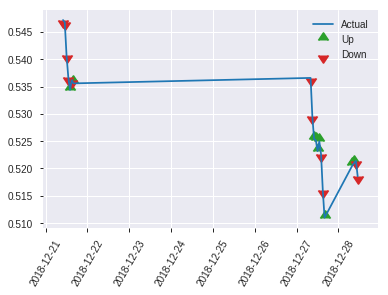


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20358931136277186
RMSE: 0.4512087226137942
LogLoss: 0.5850859511786881
Mean Per-Class Error: 0.2866263440860215
AUC: 0.75
pr_auc: 0.6738212310926377
Gini: 0.5
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.286012202501297: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   53   0.4274   (53.0/124.0)
1      14   82   0.1458   (14.0/96.0)
Total  85   135  0.3045   (67.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286012     0.709957  134
max f2                       0.200691     0.834862  160
max f0point5                 0.299075     0.645161  130
max accuracy                 0.299075     0.695455  130
max precision                0.928708     1         0
max recall                   0.0826077    1         207
max specificity              0.928708     1         0
max absolute_mcc             0.286012     0.434651  134
max min_per_class_accuracy   0.399206     0.677419  105
max mean_per_class_accuracy  0.286012     0.713374  134

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 40.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.911163           2.29167   2.29167            1                0.923021   1                           0.923021            0.03125         0.03125                    129.167   129.167
    2        0.0227273                   0.882071           2.29167   2.29167            1                0.889062   1                           0.909437            0.0208333       0.0520833                  129.167   129.167
    3        0.0318182                   0.855178           1.14583   1.96429            0.5              0.872057   0.857143                    0.898757            0.0104167       0.0625                     14.5833   96.4286
    4        0.0409091                   0.846512           2.29167   2.03704            1                0.847823   0.888889                    0.887438            0.0208333       0.0833333                  129.167   103.704
    5        0.05                        0.840598           2.29167   2.08333            1                0.846193   0.909091                    0.879939            0.0208333       0.104167                   129.167   108.333
    6        0.1                         0.747382           1.875     1.97917            0.818182         0.806589   0.863636                    0.843264            0.09375         0.197917                   87.5      97.9167
    7        0.15                        0.681312           1.25      1.73611            0.545455         0.728567   0.757576                    0.805032            0.0625          0.260417                   25        73.6111
    8        0.2                         0.623439           1.04167   1.5625             0.454545         0.644607   0.681818                    0.764925            0.0520833       0.3125                     4.16667   56.25
    9        0.3                         0.524647           1.14583   1.42361            0.5              0.568334   0.621212                    0.699395            0.114583        0.427083                   14.5833   42.3611
    10       0.4                         0.463548           1.5625    1.45833            0.681818         0.493387   0.636364                    0.647893            0.15625         0.583333                   56.25     45.8333
    11       0.5                         0.392721           1.25      1.41667            0.545455         0.42526    0.618182                    0.603366            0.125           0.708333                   25        41.6667
    12       0.6                         0.295323           1.25      1.38889            0.545455         0.343392   0.606061                    0.560037            0.125           0.833333                   25        38.8889
    13       0.7                         0.233943           0.729167  1.29464            0.318182         0.261845   0.564935                    0.517438            0.0729167       0.90625                    -27.0833  29.4643
    14       0.8                         0.147795           0.520833  1.19792            0.227273         0.182599   0.522727                    0.475583            0.0520833       0.958333                   -47.9167  19.7917
    15       0.9                         0.0990673          0.3125    1.09954            0.136364         0.124334   0.479798                    0.436556            0.03125         0.989583                   -68.75    9.9537
    16       1                           0.0446336          0.104167  1                  0.0454545        0.0774492  0.436364                    0.

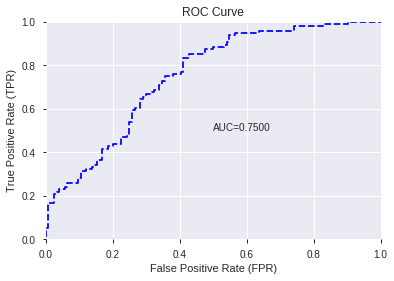

This function is available for GLM models only


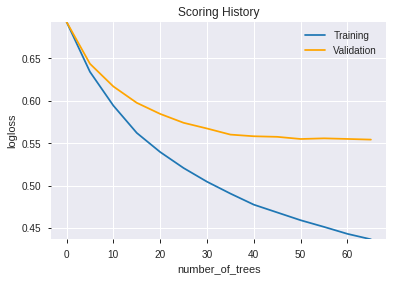

--2019-08-28 18:43:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_184330_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_184330_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'CCI_8',
 'ULTOSC',
 'CCI_12',
 'CMO_8',
 'ADOSC',
 'WILLR_8',
 'STOCHRSI_fastd',
 'WILLR_20',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'WILLR_14',
 'RSI_8',
 'WILLR_12',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLTAKURI',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLENGULFING',
 'CDLMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

514

['MA_14_0',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_middleband_14_0_2',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_14_0_5',
 'BBANDS_lowerband_14_0_5',
 'MA_14_1',
 'MAVP_14_1',
 'BBANDS_upperband_14_1_2',
 'BBANDS_middleband_14_1_2',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_upperband_14_1_3',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_upperband_14_1_4',
 'BBANDS_middleband_14_1_4',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_upperband_14_1_5',
 'BBANDS_middleband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'MA_14_2',
 'MAVP_14_2',
 'BBANDS_upperband_14_2_2',
 'BBANDS_middleband_14_2_2',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_2_4',
 'BBANDS_lowerb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_184616_model_2  0.758401  0.613515              0.321069  0.458228  0.209973
1  DeepLearning_grid_1_AutoML_20190828_184616_model_5  0.734039  0.589278              0.334341  0.451986  0.204292
2  DeepLearning_grid_1_AutoML_20190828_184616_model_6  0.730931  0.579216              0.316196  0.449493  0.202044
3  DeepLearning_grid_1_AutoML_20190828_184616_model_8  0.725302  0.598004              0.323589  0.457013  0.208861
4  DeepLearning_grid_1_AutoML_20190828_184616_model_7  0.717742  0.707943              0.321909  0.490500  0.240590
5  DeepLearning_grid_1_AutoML_20190828_184616_model_4  0.713962  0.793047              0.371136  0.498791  0.248792
6  DeepLearning_grid_1_AutoML_20190828_184616_model_9  0.709425  0.608399              0.361895  0.462542  0.213945
7  DeepLearning_grid_1_AutoML_20190828_184616_model_3  0.702621  0.726722              0.369960  0.493756  0.243795
8               DeepLearning_1_AutoML_20190828_184616  0.685652  0.717146              0.407426  0.509783  0.259878
9  DeepLearning_grid_1_AutoML_20190828_184616_model_1  0.638525  1.708699              0.377520  0.607964  0.369620

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.008970
1                     TRANGE             0.750858           0.750858    0.006735
2             CDLEVENINGSTAR             0.614357           0.614357    0.005511
3         CDLEVENINGDOJISTAR             0.614227           0.614227    0.005509
4         CDLMORNINGDOJISTAR             0.500462           0.500462    0.004489
..                       ...                  ...                ...         ...
506  BBANDS_upperband_14_3_5             0.170136           0.170136    0.001526
507  BBANDS_upperband_14_7_4             0.169429           0.169429    0.001520
508  BBANDS_upperband_14_2_4             0.168921           0.168921    0.001515
509             LINEARREG_30             0.164926           0.164926    0.001479
510            CDLHIKKAKEMOD             0.159312           0.159312    0.001429

[511 rows x 4 columns]

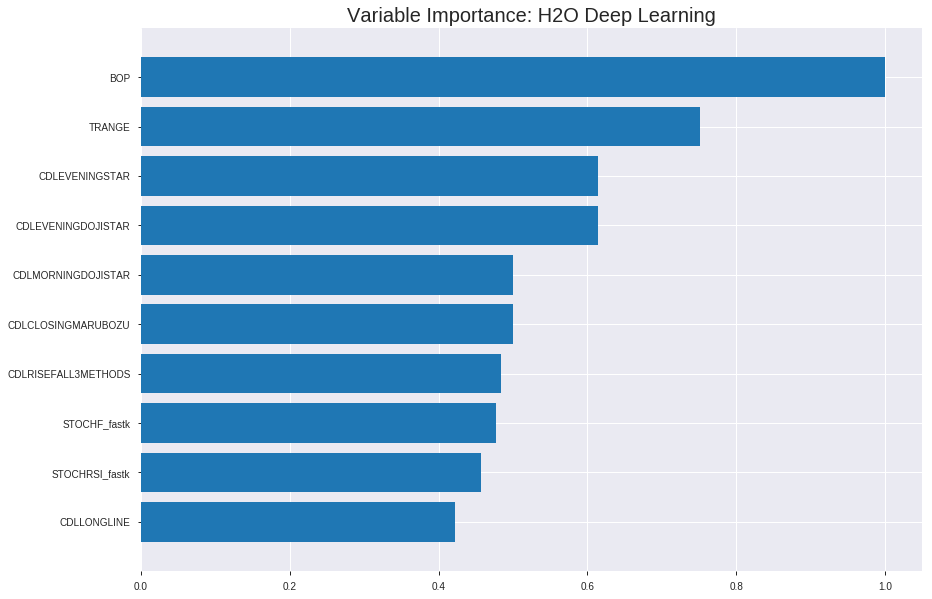

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_184616_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18296359816576802
RMSE: 0.4277424437272598
LogLoss: 0.5485822241167324
Mean Per-Class Error: 0.2750727117194183
AUC: 0.7974687767322498
pr_auc: 0.7632105084658278
Gini: 0.5949375534644996
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3404409322671472: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      467  368  0.4407   (368.0/835.0)
1      103  597  0.1471   (103.0/700.0)
Total  570  965  0.3068   (471.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340441     0.717117  259
max f2                       0.137118     0.827612  340
max f0point5                 0.613857     0.720247  145
max accuracy                 0.563322     0.732899  166
max precision                0.999117     1         0
max recall                   0.00772383   1         394
max specificity              0.999117     1         0
max absolute_mcc             0.563322     0.459456  166
max min_per_class_accuracy   0.487574     0.721429  197
max mean_per_class_accuracy  0.563322     0.724927  166

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.961285           2.0558    2.0558             0.9375           0.977206  0.9375                      0.977206            0.0214286       0.0214286                  105.58    105.58
    2        0.0201954                   0.943613           2.04667   2.05138            0.933333         0.951281  0.935484                    0.964661            0.02            0.0414286                  104.667   105.138
    3        0.0306189                   0.927426           1.91875   2.00623            0.875            0.936032  0.914894                    0.954915            0.02            0.0614286                  91.875    100.623
    4        0.0403909                   0.914131           1.90048   1.98065            0.866667         0.920504  0.903226                    0.94659             0.0185714       0.08                       90.0476   98.0645
    5        0.0501629                   0.896906           2.04667   1.99351            0.933333         0.906581  0.909091                    0.938796            0.02            0.1                        104.667   99.3506
    6        0.100326                    0.835329           1.99351   1.99351            0.909091         0.864418  0.909091                    0.901607            0.1             0.2                        99.3506   99.3506
    7        0.150489                    0.77431            1.7372    1.90807            0.792208         0.803451  0.87013                     0.868888            0.0871429       0.287143                   73.7199   90.8071
    8        0.2                         0.72678            1.35611   1.77143            0.618421         0.745559  0.807818                    0.838357            0.0671429       0.354286                   35.6109   77.1429
    9        0.300326                    0.642289           1.58057   1.70767            0.720779         0.684906  0.778742                    0.787096            0.158571        0.512857                   58.0566   70.767
    10       0.4                         0.555863           1.26125   1.59643            0.575163         0.598783  0.728013                    0.740171            0.125714        0.638571                   26.1251   59.6429
    11       0.500326                    0.464773           0.954035  1.46762            0.435065         0.510357  0.669271                    0.694088            0.0957143       0.734286                   -4.59647  46.7615
    12       0.6                         0.365046           0.931606  1.37857            0.424837         0.414489  0.628664                    0.64764             0.0928571       0.827143                   -6.8394   37.8571
    13       0.699674                    0.26034            0.702288  1.28223            0.320261         0.316189  0.58473                     0.600422            0.07            0.897143                   -29.7712  28.2229
    14       0.8                         0.167198           0.469898  1.18036            0.214286         0.212458  0.538274                    0.551769            0.0471429       0.944286                   -53.0102  18.0357
    15       0.899674                    0.0623549          0.401307  1.09405            0.183007         0.11672   0.498914                    0.50357             0.04            0.984286                   -59.8693  9.40468
    16       1                           3.18085e-06        0.156633  1                  0.0714286        0.027155  0.456026                    0.455773           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20577781215614654
RMSE: 0.45362739352484716
LogLoss: 0.6136906075879996
Mean Per-Class Error: 0.3000187668119356
AUC: 0.7710344683779219
pr_auc: 0.7624081230141072
Gini: 0.5420689367558438
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23642361376055504: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  99   0.448    (99.0/221.0)
1      33   184  0.1521   (33.0/217.0)
Total  155  283  0.3014   (132.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.236424     0.736     261
max f2                       0.0841828    0.853859  324
max f0point5                 0.536372     0.707182  155
max accuracy                 0.371713     0.69863   216
max precision                0.993211     1         0
max recall                   0.00340193   1         391
max specificity              0.993211     1         0
max absolute_mcc             0.236424     0.418202  261
max min_per_class_accuracy   0.421299     0.686636  198
max mean_per_class_accuracy  0.236424     0.699981  261

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 42.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.985969           2.01843   2.01843            1                0.990213   1                           0.990213            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.962204           2.01843   2.01843            1                0.972077   1                           0.982153            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.935433           2.01843   2.01843            1                0.943949   1                           0.968509            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.913681           2.01843   2.01843            1                0.927798   1                           0.959462            0.0184332       0.0829493                  101.843   101.843
    5        0.0502283                   0.895519           2.01843   2.01843            1                0.905888   1                           0.949721            0.0184332       0.101382                   101.843   101.843
    6        0.100457                    0.838099           1.5597    1.78907            0.772727         0.866304   0.886364                    0.908013            0.078341        0.179724                   55.9698   78.9066
    7        0.150685                    0.791962           1.46795   1.68203            0.727273         0.810214   0.833333                    0.875413            0.0737327       0.253456                   46.7951   68.2028
    8        0.200913                    0.751661           1.65145   1.67438            0.818182         0.772858   0.829545                    0.849774            0.0829493       0.336406                   65.1445   67.4382
    9        0.30137                     0.634366           1.28446   1.54441            0.636364         0.694493   0.765152                    0.798014            0.129032        0.465438                   28.4457   54.4407
    10       0.399543                    0.521331           1.26739   1.47634            0.627907         0.583145   0.731429                    0.745218            0.124424        0.589862                   26.7388   47.634
    11       0.5                         0.418181           0.963343  1.37327            0.477273         0.467997   0.680365                    0.68952             0.0967742       0.686636                   -3.66569  37.3272
    12       0.600457                    0.294051           1.10096   1.32771            0.545455         0.359478   0.657795                    0.634304            0.110599        0.797235                   10.0964   32.7715
    13       0.69863                     0.182386           0.751045  1.24668            0.372093         0.234841   0.617647                    0.578171            0.0737327       0.870968                   -24.8955  24.6679
    14       0.799087                    0.0805927          0.871596  1.19953            0.431818         0.13726    0.594286                    0.522742            0.0875576       0.958525                   -12.8404  19.9526
    15       0.899543                    0.0275944          0.275241  1.09631            0.136364         0.0550301  0.543147                    0.47051             0.0276498       0.986175                   -72.4759  9.63063
    16       1                           9.39544e-05        0.13762   1                  0.0681818        0.0104732  0.495434                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:47:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:47:40  1 min 22.145 sec  819 obs/sec       1.2215    1             1875       0.595202         3.53414             -0.428108      0.650313        0.564193           1.64464          0.543974                         0.62768            4.28743               -0.576059        0.623194          0.606563             0.807373           0.454338
    2019-08-28 18:47:45  1 min 27.146 sec  813 obs/sec       3.62541   3             5565       0.450161         0.601372            0.183102       0.767788        0.727811           2.19286          0.32899                          0.526831           0.852055              -0.110296        0.708395          0.674888             2.01843            0.353881
    2019-08-28 18:47:52  1 min 34.075 sec  836 obs/sec       7.2645    6             11151      0.483301         0.690156            0.058397       0.737446        0.685866           1.7817           0.347231                         0.574911           1.07031               -0.322203        0.678869          0.653851             2.01843            0.415525
    2019-08-28 18:47:59  1 min 40.476 sec  871 obs/sec       10.9459   9             16802      0.490004         0.730975            0.0320965      0.737818        0.664785           2.0558           0.363518                         0.515476           0.865443              -0.0629511       0.682361          0.636335             2.01843            0.388128
    2019-08-28 18:48:05  1 min 46.508 sec  898 obs/sec       14.5564   12            22344      0.475339         0.67251             0.0891678      0.721342        0.672046           1.7817           0.37329                          0.484608           0.698017              0.0605405        0.737025          0.715478             2.01843            0.349315
    2019-08-28 18:48:11  1 min 52.378 sec  921 obs/sec       18.1648   15            27883      0.466208         0.66256             0.123825       0.736794        0.703555           2.0558           0.362866                         0.565254           1.08493               -0.278156        0.715756          0.687368             1.61475            0.333333
    2019-08-28 18:48:16  1 min 58.189 sec  939 obs/sec       21.8156   18            33487      0.427742         0.548582            0.262441       0.797469        0.763211           2.0558           0.30684                          0.453627           0.613691              0.17682          0.771034          0.762408             2.01843            0.30137
    2019-08-28 18:48:22  2 min  3.784 sec  959 obs/sec       25.4723   21            39100      0.450473         0.628259            0.18197        0.773874        0.705641           2.0558           0.320521                         0.493996           0.77463               0.023789         0.755708          0.751728             2.01843            0.356164
    2019-08-28 18:48:27 

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.008969591545590952
TRANGE                   0.7508583664894104     0.7508583664894104   0.006734892855999648
CDLEVENINGSTAR           0.6143568158149719     0.6143568158149719   0.005510529701110149
CDLEVENINGDOJISTAR       0.6142266392707825     0.6142266392707825   0.0055093620706799535
CDLMORNINGDOJISTAR       0.5004618167877197     0.5004618167877197   0.004488938080750219
---                      ---                    ---                  ---
BBANDS_upperband_14_3_5  0.17013606429100037    0.17013606429100037  0.0015260510038646756
BBANDS_upperband_14_7_4  0.16942943632602692    0.16942943632602692  0.0015197128396441716
BBANDS_upperband_14_2_4  0.16892105340957642    0.16892105340957642  0.0015151528525348542
LINEARREG_30             0.16492560505867004    0.16492560505867004  0.0014793153127857191
CDLHIKKAKEMOD            0.15931165218353271    0.15931165218353271  0.0014289604485395414


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7045454545454546)

('F1', 0.6932270916334662)

('auc', 0.7584005376344086)

('logloss', 0.6135148684808956)

('mean_per_class_error', 0.31619623655913975)

('rmse', 0.4582279669465953)

('mse', 0.20997286969201004)

deeplearning prediction progress: |███████████████████████████████████████| 100%


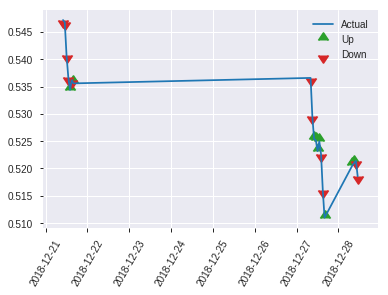


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20997286969201004
RMSE: 0.4582279669465953
LogLoss: 0.6135148684808956
Mean Per-Class Error: 0.31619623655913975
AUC: 0.7584005376344086
pr_auc: 0.6790153761451728
Gini: 0.5168010752688172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14261612609426436: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   68   0.5484   (68.0/124.0)
1      9    87   0.0938   (9.0/96.0)
Total  65   155  0.35     (77.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.142616     0.693227  154
max f2                       0.0431836    0.836237  189
max f0point5                 0.556012     0.672043  68
max accuracy                 0.556012     0.704545  68
max precision                0.994912     1         0
max recall                   0.0431836    1         189
max specificity              0.994912     1         0
max absolute_mcc             0.556012     0.392932  68
max min_per_class_accuracy   0.368865     0.669355  105
max mean_per_class_accuracy  0.556012     0.683804  68

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 39.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.97183            1.52778   1.52778            0.666667         0.981672    0.666667                    0.981672            0.0208333       0.0208333                  52.7778   52.7778
    2        0.0227273                   0.960745           2.29167   1.83333            1                0.966109    0.8                         0.975447            0.0208333       0.0416667                  129.167   83.3333
    3        0.0318182                   0.955158           2.29167   1.96429            1                0.957721    0.857143                    0.970382            0.0208333       0.0625                     129.167   96.4286
    4        0.0409091                   0.950549           2.29167   2.03704            1                0.954222    0.888889                    0.966791            0.0208333       0.0833333                  129.167   103.704
    5        0.05                        0.939729           2.29167   2.08333            1                0.945708    0.909091                    0.962958            0.0208333       0.104167                   129.167   108.333
    6        0.1                         0.836491           1.45833   1.77083            0.636364         0.904301    0.772727                    0.93363             0.0729167       0.177083                   45.8333   77.0833
    7        0.15                        0.752908           1.66667   1.73611            0.727273         0.796811    0.757576                    0.888023            0.0833333       0.260417                   66.6667   73.6111
    8        0.2                         0.710819           1.45833   1.66667            0.636364         0.732504    0.727273                    0.849144            0.0729167       0.333333                   45.8333   66.6667
    9        0.3                         0.571812           1.5625    1.63194            0.681818         0.650831    0.712121                    0.783039            0.15625         0.489583                   56.25     63.1944
    10       0.4                         0.462405           0.9375    1.45833            0.409091         0.518915    0.636364                    0.717008            0.09375         0.583333                   -6.25     45.8333
    11       0.5                         0.35529            1.14583   1.39583            0.5              0.399888    0.609091                    0.653584            0.114583        0.697917                   14.5833   39.5833
    12       0.6                         0.233907           0.9375    1.31944            0.409091         0.299146    0.575758                    0.594511            0.09375         0.791667                   -6.25     31.9444
    13       0.7                         0.147404           1.04167   1.27976            0.454545         0.182765    0.558442                    0.53569             0.104167        0.895833                   4.16667   27.9762
    14       0.8                         0.0802043          0.625     1.19792            0.272727         0.117601    0.522727                    0.483429            0.0625          0.958333                   -37.5     19.7917
    15       0.9                         0.0167146          0.416667  1.11111            0.181818         0.0490193   0.484848                    0.435161            0.0416667       1                          -58.3333  11.1111
    16       1                           3.3134e-05         0         1                  0                0.00824473  0.436364 

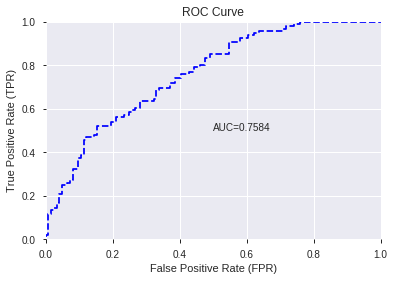

This function is available for GLM models only


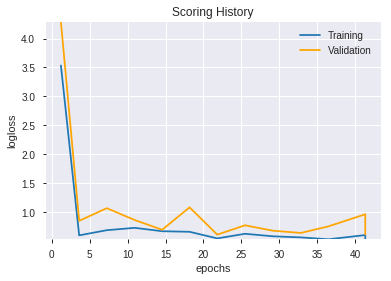

--2019-08-28 19:05:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_184616_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_184616_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'CDLEVENINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLRISEFALL3METHODS',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'aroonup_20',
 'CORREL_8',
 'STOCH_slowd',
 'CORREL_12',
 'CORREL_14',
 'BETA_8',
 'MFI_8',
 'aroondown_14',
 'aroondown_24',
 'CDLGAPSIDESIDEWHITE',
 'AROONOSC_24',
 'NATR_8',
 'HT_PHASOR_quadrature',
 'BETA_12',
 'aroondown_8',
 'CDLSHORTLINE',
 'AROONOSC_20',
 'PLUS_DI_8',
 'aroondown_30',
 'DX_8',
 'CCI_8',
 'CORREL_30',
 'ADX_24',
 'STOCHF_fastd',
 'ULTOSC',
 'CDLSTALLEDPATTERN',
 'aroondown_12',
 'CORREL_24',
 'CDLLONGLEGGEDDOJI',
 'aroonup_8',
 'DX_12',
 'aroonup_12',
 'CDLBELTHOLD',
 'aroonup_30',
 'VAR_8',
 'BETA_30',
 'CDLHAMMER',
 'WILLR_14',
 'PLUS_DM_8',
 'HT_PHASOR_inphase',
 'CDLMARUBOZU',
 'aroonup_24',
 'CDLTASUKIGAP',
 'HT_DCPERIOD',
 'CDLHOMINGPIGEON',
 'CDLRICKSHAWMAN',
 'CORREL_20',
 'aroonup_14',
 'CDLDRAGONFLYDOJI',
 'aroondown_20',
 'DX_20',
 'DX_14',
 'ADXR_14',
 'ATR_8',
 'CDLTAK

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_190651_model_1  0.734123  0.590614              0.337366  0.452583  0.204831

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.368550           1.000000    0.046124
1                      TRANGE             0.268410           0.728286    0.033591
2          CDLCLOSINGMARUBOZU             0.163571           0.443824    0.020471
3                 CDLLONGLINE             0.150663           0.408799    0.018855
4                STOCHF_fastk             0.147924           0.401367    0.018513
..                        ...                  ...                ...         ...
506                     MOM_8             0.000052           0.000141    0.000006
507   BBANDS_upperband_14_5_4             0.000041           0.000112    0.000005
508   BBANDS_upperband_14_4_2             0.000026           0.000071    0.000003
509  BBANDS_middleband_14_0_4             0.000012           0.000033    0.000002
510   BBANDS_upperband_14_2_3             0.000009           0.000024    0.000001

[511 rows x 4 columns]

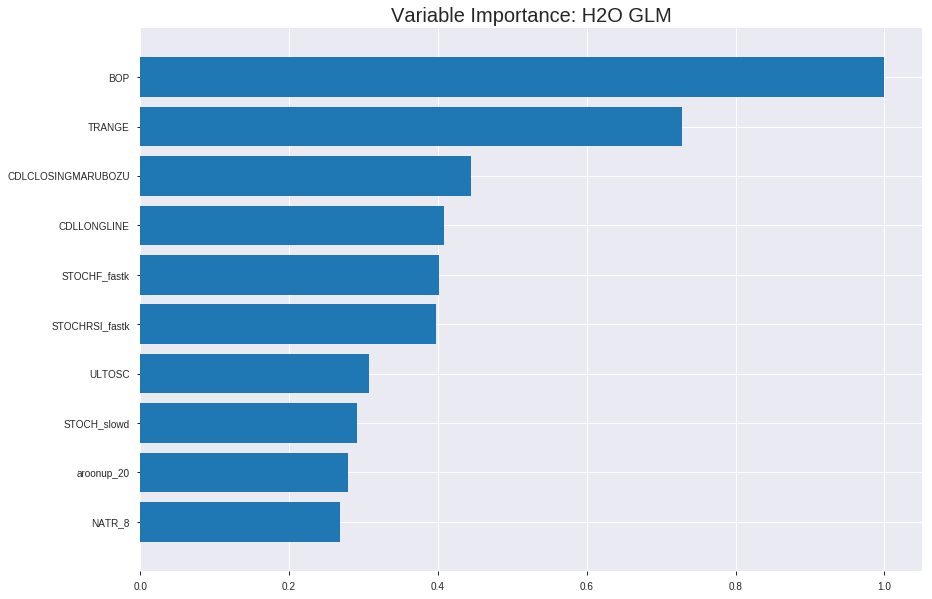

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_190651_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18201168041157667
RMSE: 0.42662826958791267
LogLoss: 0.5423940083670303
Null degrees of freedom: 1534
Residual degrees of freedom: 1023
Null deviance: 2116.073526703686
Residual deviance: 1665.1496056867832
AIC: 2689.149605686783
AUC: 0.8026039349871685
pr_auc: 0.7741816026153792
Gini: 0.6052078699743371
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3921712205201538: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      514  321  0.3844   (321.0/835.0)
1      123  577  0.1757   (123.0/700.0)
Total  637  898  0.2893   (444.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392171     0.722153  230
max f2                       0.221306     0.829244  320
max f0point5                 0.553667     0.722683  149
max accuracy                 0.545953     0.73355   153
max precision                0.944922     1         0
max recall                   0.0538619    1         391
max specificity              0.944922     1         0
max absolute_mcc             0.545953     0.461612  153
max min_per_class_accuracy   0.470695     0.72      192
max mean_per_class_accuracy  0.486362     0.727087  185

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.888464           2.19286   2.19286            1                0.909198  1                           0.909198            0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.8734             2.04667   2.12212            0.933333         0.882532  0.967742                    0.896295            0.02            0.0428571                  104.667   112.212
    3        0.0306189                   0.85163            2.19286   2.1462             1                0.862491  0.978723                    0.884787            0.0228571       0.0657143                  119.286   114.62
    4        0.0403909                   0.836241           2.19286   2.15749            1                0.84445   0.983871                    0.875028            0.0214286       0.0871429                  119.286   115.749
    5        0.0501629                   0.822709           2.19286   2.16438            1                0.827958  0.987013                    0.865859            0.0214286       0.108571                   119.286   116.438
    6        0.100326                    0.760771           1.76568   1.96503            0.805195         0.785213  0.896104                    0.825536            0.0885714       0.197143                   76.5677   96.5028
    7        0.150489                    0.709635           1.62328   1.85111            0.74026          0.733592  0.844156                    0.794888            0.0814286       0.278571                   62.3284   85.1113
    8        0.2                         0.668521           1.70235   1.81429            0.776316         0.688468  0.827362                    0.768543            0.0842857       0.362857                   70.235    81.4286
    9        0.300326                    0.597986           1.53785   1.72194            0.701299         0.630402  0.785249                    0.722396            0.154286        0.517143                   53.7848   72.194
    10       0.4                         0.526492           1.20392   1.59286            0.54902          0.561413  0.726384                    0.682281            0.12            0.637143                   20.3922   59.2857
    11       0.500326                    0.455721           1.08219   1.49046            0.493506         0.492609  0.679688                    0.644248            0.108571        0.745714                   8.21892   49.0458
    12       0.6                         0.379446           0.874276  1.3881             0.398693         0.415542  0.633008                    0.606255            0.0871429       0.832857                   -12.5724  38.8095
    13       0.699674                    0.306789           0.71662   1.29244            0.326797         0.343893  0.589385                    0.568879            0.0714286       0.904286                   -28.338   29.2438
    14       0.8                         0.241912           0.484137  1.19107            0.220779         0.276266  0.54316                     0.532183            0.0485714       0.952857                   -51.5863  19.1071
    15       0.899674                    0.157244           0.286648  1.09087            0.130719         0.202067  0.497466                    0.49561             0.0285714       0.981429                   -71.3352  9.0871
    16       1                           0.0158069          0.185111  1                  0.0844156        0.101057  0.456026                    0.456026            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19442873131420027
RMSE: 0.4409407344691577
LogLoss: 0.5716699822935793
Null degrees of freedom: 437
Residual degrees of freedom: -74
Null deviance: 609.8925503857407
Residual deviance: 500.78290448917545
AIC: 1524.7829044891755
AUC: 0.7780720228538065
pr_auc: 0.7658124481882611
Gini: 0.556144045707613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32072105168418735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      111  110  0.4977   (110.0/221.0)
1      25   192  0.1152   (25.0/217.0)
Total  136  302  0.3082   (135.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320721     0.739884  272
max f2                       0.218002     0.847596  324
max f0point5                 0.488742     0.721393  178
max accuracy                 0.488742     0.716895  178
max precision                0.934087     1         0
max recall                   0.0384374    1         394
max specificity              0.934087     1         0
max absolute_mcc             0.488742     0.435092  178
max min_per_class_accuracy   0.465578     0.700461  195
max mean_per_class_accuracy  0.488742     0.716454  178

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 44.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.886981           2.01843   2.01843            1                0.911826   1                           0.911826            0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.852906           2.01843   2.01843            1                0.869835   1                           0.893163            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.80586            2.01843   2.01843            1                0.833538   1                           0.871869            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.793671           1.51382   1.9063             0.75             0.79995    0.944444                    0.855887            0.0138249       0.078341                   51.3825   90.6298
    5        0.0502283                   0.780303           2.01843   1.92669            1                0.785508   0.954545                    0.843091            0.0184332       0.0967742                  101.843   92.6686
    6        0.100457                    0.730901           1.74319   1.83494            0.863636         0.755827   0.909091                    0.799459            0.0875576       0.184332                   74.3192   83.4939
    7        0.150685                    0.69164            1.3762    1.68203            0.681818         0.710807   0.833333                    0.769908            0.0691244       0.253456                   37.6204   68.2028
    8        0.200913                    0.650002           1.74319   1.69732            0.863636         0.66954    0.840909                    0.744816            0.0875576       0.341014                   74.3192   69.7319
    9        0.30137                     0.588748           1.33033   1.57499            0.659091         0.615245   0.780303                    0.701626            0.133641        0.474654                   33.0331   57.499
    10       0.399543                    0.521182           1.12657   1.46481            0.55814          0.557713   0.725714                    0.666264            0.110599        0.585253                   12.6567   46.4806
    11       0.5                         0.462062           1.14684   1.40092            0.568182         0.490788   0.694064                    0.631009            0.115207        0.700461                   14.6837   40.0922
    12       0.600457                    0.394538           1.05509   1.34306            0.522727         0.43162    0.665399                    0.597651            0.105991        0.806452                   5.50901   34.3064
    13       0.69863                     0.307164           0.844926  1.27306            0.418605         0.353033   0.630719                    0.563276            0.0829493       0.889401                   -15.5074  27.3064
    14       0.799087                    0.232183           0.504608  1.17646            0.25             0.272459   0.582857                    0.526717            0.0506912       0.940092                   -49.5392  17.6458
    15       0.899543                    0.15745            0.321114  1.08094            0.159091         0.194059   0.535533                    0.489567            0.0322581       0.97235                    -67.8886  8.09376
    16       1                           0.0213933          0.275241  1                  0.136364         0.0905467  0.495434                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:06:53  0.000 sec   2            .2E2      512           1.3532303346666268  1.3663344495580971
     2019-08-28 19:06:53  0.537 sec   4            .15E2     512           1.3454227662642555  1.3591497051311834
     2019-08-28 19:06:54  1.066 sec   6            .11E2     512           1.3357140441722546  1.3503395690364637
     2019-08-28 19:06:54  1.601 sec   8            .79E1     512           1.3239014824640167  1.3397296062230257
     2019-08-28 19:06:55  2.129 sec   10           .57E1     512           1.3098938376767264  1.3271829783268148
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:07:03  10.271 sec  40           .49E-1    512           1.0759764146902062  1.143492794800985
     2019-08-28 19:07:03  10.836 sec  42           .36E-1    512           1.0680697255117158  1.145867312307655
     2019-08-28 19:07:04  11.372 sec  44           .26E-1    512           1.06088391513653    1.1501465556993058
     2019-08-28 19:07:05  11.929 sec  46           .19E-1    512           1.054325141765842   1.1560163460044852
     2019-08-28 19:07:05  12.497 sec  48           .14E-1    512           1.0483567251107766  1.162950128573722


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6818181818181818)

('F1', 0.6694560669456067)

('auc', 0.7341229838709677)

('logloss', 0.5906140580067825)

('mean_per_class_error', 0.316364247311828)

('rmse', 0.45258311490693226)

('mse', 0.20483147589886144)

glm prediction progress: |████████████████████████████████████████████████| 100%


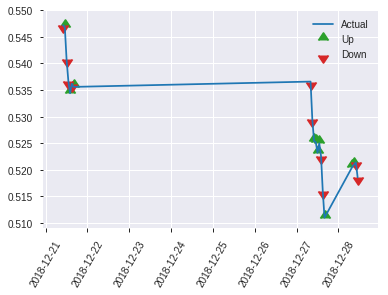


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20483147589886144
RMSE: 0.45258311490693226
LogLoss: 0.5906140580067825
Null degrees of freedom: 219
Residual degrees of freedom: -292
Null deviance: 301.7551983180251
Residual deviance: 259.8701855229843
AIC: 1283.8701855229842
AUC: 0.7341229838709677
pr_auc: 0.6682548029830286
Gini: 0.4682459677419355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32335707904574146: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   63   0.5081   (63.0/124.0)
1      16   80   0.1667   (16.0/96.0)
Total  77   143  0.3591   (79.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323357     0.669456  142
max f2                       0.137669     0.821799  193
max f0point5                 0.407485     0.63447   107
max accuracy                 0.407485     0.681818  107
max precision                0.93067      1         0
max recall                   0.105552     1         201
max specificity              0.93067      1         0
max absolute_mcc             0.407485     0.364345  107
max min_per_class_accuracy   0.411943     0.669355  105
max mean_per_class_accuracy  0.407485     0.683636  107

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 41.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.8713             1.52778   1.52778            0.666667         0.901116   0.666667                    0.901116            0.0208333       0.0208333                  52.7778   52.7778
    2        0.0227273                   0.850288           2.29167   1.83333            1                0.858071   0.8                         0.883898            0.0208333       0.0416667                  129.167   83.3333
    3        0.0318182                   0.839811           2.29167   1.96429            1                0.844358   0.857143                    0.872601            0.0208333       0.0625                     129.167   96.4286
    4        0.0409091                   0.816467           2.29167   2.03704            1                0.83372    0.888889                    0.863961            0.0208333       0.0833333                  129.167   103.704
    5        0.05                        0.806842           2.29167   2.08333            1                0.811233   0.909091                    0.854374            0.0208333       0.104167                   129.167   108.333
    6        0.1                         0.721067           1.45833   1.77083            0.636364         0.775585   0.772727                    0.81498             0.0729167       0.177083                   45.8333   77.0833
    7        0.15                        0.653293           2.08333   1.875              0.909091         0.683524   0.818182                    0.771161            0.104167        0.28125                    108.333   87.5
    8        0.2                         0.607968           1.45833   1.77083            0.636364         0.629634   0.772727                    0.735779            0.0729167       0.354167                   45.8333   77.0833
    9        0.3                         0.5425             0.9375    1.49306            0.409091         0.569224   0.651515                    0.680261            0.09375         0.447917                   -6.25     49.3056
    10       0.4                         0.464126           1.25      1.43229            0.545455         0.502355   0.625                       0.635785            0.125           0.572917                   25        43.2292
    11       0.5                         0.404705           1.25      1.39583            0.545455         0.429558   0.609091                    0.594539            0.125           0.697917                   25        39.5833
    12       0.6                         0.353917           0.729167  1.28472            0.318182         0.384481   0.560606                    0.559529            0.0729167       0.770833                   -27.0833  28.4722
    13       0.7                         0.283301           0.729167  1.20536            0.318182         0.320693   0.525974                    0.52541             0.0729167       0.84375                    -27.0833  20.5357
    14       0.8                         0.229893           0.9375    1.17188            0.409091         0.261353   0.511364                    0.492403            0.09375         0.9375                     -6.25     17.1875
    15       0.9                         0.11379            0.520833  1.09954            0.227273         0.18052    0.479798                    0.457749            0.0520833       0.989583                   -47.9167  9.9537
    16       1                           0.0202727          0.104167  1                  0.0454545        0.0777152  0.436364                    0.4

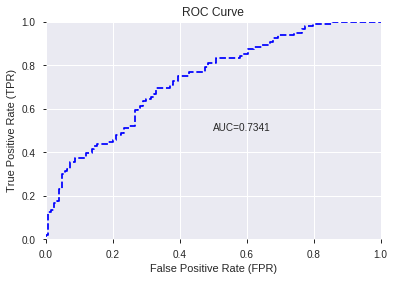

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


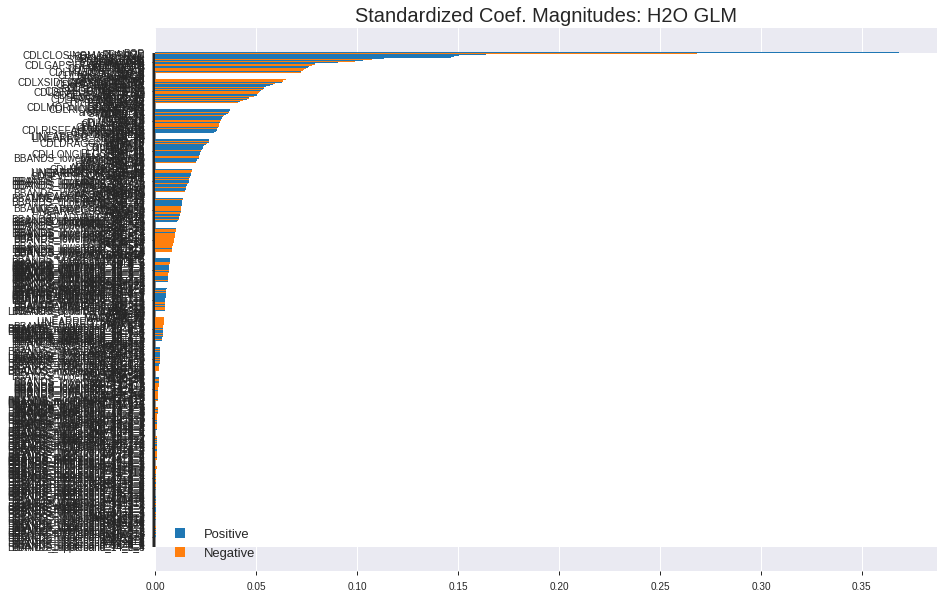

'log_likelihood'
--2019-08-28 19:07:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.204
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.204|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_190651_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_190651_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'STOCH_slowd',
 'aroonup_20',
 'NATR_8',
 'CDLHAMMER',
 'STDDEV_30',
 'CDLGAPSIDESIDEWHITE',
 'PLUS_DI_8',
 'CDLTAKURI',
 'CDLMARUBOZU',
 'MFI_8',
 'CDLBELTHOLD',
 'CCI_8',
 'CDLMATCHINGLOW',
 'PLUS_DM_8',
 'ATR_8',
 'CDLHIKKAKEMOD',
 'VAR_8',
 'aroondown_24',
 'STOCH_slowk',
 'STOCHF_fastd',
 'BETA_8',
 'MFI_12',
 'AROONOSC_24',
 'CDLXSIDEGAP3METHODS',
 'CDLSHORTLINE',
 'CDLHANGINGMAN',
 'WILLR_30',
 'WILLR_14',
 'CDLENGULFING',
 'CDL3LINESTRIKE',
 'BETA_12',
 'CORREL_30',
 'CDLSHOOTINGSTAR',
 'CDLSTALLEDPATTERN',
 'NATR_12',
 'BETA_30',
 'CDLEVENINGSTAR',
 'STOCHRSI_fastd',
 'aroonup_30',
 'AROONOSC_20',
 'CDLHARAMICROSS',
 'WILLR_12',
 'PLUS_DI_12',
 'MOM_24',
 'ADXR_8',
 'aroonup_24',
 'OBV',
 'STDDEV_20',
 'CDLMORNINGDOJISTAR',
 'ADX_8',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'CORREL_12',
 'aroondown_14',
 'STDDEV_24',
 'NATR_14',
 'CDLDOJI',
 'WILLR_20',
 'MFI_24',
 'WILLR_24',
 '

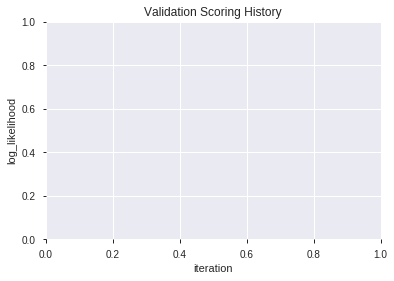

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_190823_model_6  0.738827  0.590759              0.310652  0.453472  0.205637
1  XGBoost_grid_1_AutoML_20190828_190823_model_4  0.736391  0.598114              0.313676  0.455437  0.207423
2               XGBoost_2_AutoML_20190828_190823  0.731771  0.603505              0.303931  0.458077  0.209835
3  XGBoost_grid_1_AutoML_20190828_190823_model_2  0.726562  0.602298              0.306788  0.457780  0.209562
4  XGBoost_grid_1_AutoML_20190828_190823_model_7  0.726478  0.610843              0.316532  0.462086  0.213523
5               XGBoost_3_AutoML_20190828_190823  0.723538  0.600967              0.314684  0.458228  0.209973
6               XGBoost_1_AutoML_20190828_190823  0.717238  0.612079              0.327957  0.462858  0.214237
7  XGBoost_grid_1_AutoML_20190828_190823_model_5  0.710349  0.627082              0.344254  0.468578  0.219565
8  XGBoost_grid_1_AutoML_20190828_190823_model_1  0.705393  0.615167              0.330309  0.465031  0.216254
9  XGBoost_grid_1_AutoML_20190828_190823_model_3  0.702873  0.624772              0.329301  0.468444  0.219440

variable  relative_importance  scaled_importance  percentage
0                        BOP          1860.036499           1.000000    0.168552
1                     TRANGE           999.807922           0.537521    0.090600
2               STOCHF_fastk           306.115387           0.164575    0.027739
3             STOCHRSI_fastk           253.850128           0.136476    0.023003
4       HT_PHASOR_quadrature           186.295044           0.100157    0.016882
..                       ...                  ...                ...         ...
266  BBANDS_lowerband_20_1_4             2.670448           0.001436    0.000242
267  BBANDS_lowerband_14_3_4             2.400758           0.001291    0.000218
268                MAVP_14_1             2.126090           0.001143    0.000193
269  BBANDS_upperband_14_1_2             1.714067           0.000922    0.000155
270              aroondown_8             1.452467           0.000781    0.000132

[271 rows x 4 columns]

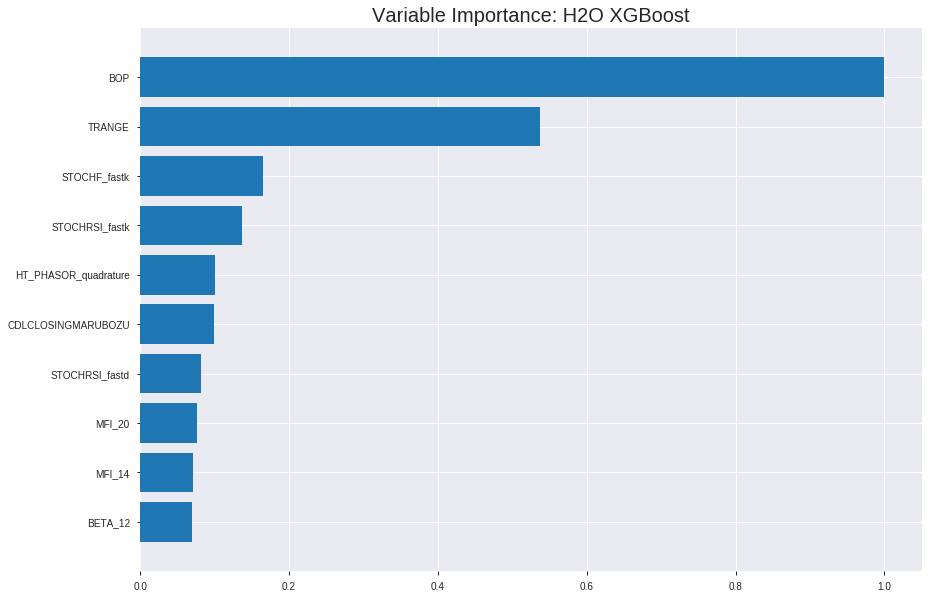

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_190823_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10945711485505065
RMSE: 0.33084303658238096
LogLoss: 0.3740168118057895
Mean Per-Class Error: 0.10991017964071859
AUC: 0.9593413173652694
pr_auc: 0.9536107455723412
Gini: 0.9186826347305388
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5147080818812052: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      760  75   0.0898   (75.0/835.0)
1      91   609  0.13     (91.0/700.0)
Total  851  684  0.1081   (166.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514708     0.880058  187
max f2                       0.366707     0.913863  252
max f0point5                 0.593581     0.905114  152
max accuracy                 0.530054     0.892508  180
max precision                0.95686      1         0
max recall                   0.187079     1         328
max specificity              0.95686      1         0
max absolute_mcc             0.530054     0.783522  180
max min_per_class_accuracy   0.489125     0.886228  199
max mean_per_class_accuracy  0.514708     0.89009   187

Gains/Lift Table: Avg response rate: 45.60 %, avg score: 46.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.919881           2.19286    2.19286            1                0.93572    1                           0.93572             0.0228571       0.0228571                  119.286   119.286
    2        0.0201954                   0.901818           2.19286    2.19286            1                0.912046   1                           0.924265            0.0214286       0.0442857                  119.286   119.286
    3        0.0306189                   0.883553           2.19286    2.19286            1                0.894725   1                           0.914209            0.0228571       0.0671429                  119.286   119.286
    4        0.0403909                   0.867828           2.19286    2.19286            1                0.876949   1                           0.905194            0.0214286       0.0885714                  119.286   119.286
    5        0.0501629                   0.854685           2.19286    2.19286            1                0.862065   1                           0.896792            0.0214286       0.11                       119.286   119.286
    6        0.100326                    0.802814           2.19286    2.19286            1                0.827469   1                           0.86213             0.11            0.22                       119.286   119.286
    7        0.150489                    0.766894           2.16438    2.18336            0.987013         0.78448    0.995671                    0.836247            0.108571        0.328571                   116.438   118.336
    8        0.2                         0.727334           2.164      2.17857            0.986842         0.747745   0.993485                    0.814338            0.107143        0.435714                   116.4     117.857
    9        0.300326                    0.647346           2.05046    2.13578            0.935065         0.686412   0.97397                     0.771603            0.205714        0.641429                   105.046   113.578
    10       0.4                         0.558191           1.70556    2.02857            0.777778         0.606548   0.925081                    0.730474            0.17            0.811429                   70.5556   102.857
    11       0.500326                    0.456165           1.06795    1.83595            0.487013         0.506855   0.83724                     0.685634            0.107143        0.918571                   6.79499   83.5947
    12       0.6                         0.359853           0.515966   1.61667            0.235294         0.406225   0.737242                    0.639217            0.0514286       0.97                       -48.4034  61.6667
    13       0.699674                    0.269972           0.229318   1.41903            0.104575         0.316275   0.647114                    0.593212            0.0228571       0.992857                   -77.0682  41.9028
    14       0.8                         0.176924           0.0711967  1.25               0.0324675        0.217678   0.570033                    0.546117            0.00714286      1                          -92.8803  25
    15       0.899674                    0.112535           0          1.11151            0                0.145182   0.506879                    0.501698            0               1                          -100      11.1513
    16       1                           0.0454427          0          1                  0                0.0868968  0.456026      



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18867198529351809
RMSE: 0.43436388580718593
LogLoss: 0.5546068141281281
Mean Per-Class Error: 0.2837229184477761
AUC: 0.7880809892195091
pr_auc: 0.7793168887024592
Gini: 0.5761619784390182
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3216591477394104: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  103  0.4661   (103.0/221.0)
1      22   195  0.1014   (22.0/217.0)
Total  140  298  0.2854   (125.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321659     0.757282  269
max f2                       0.139204     0.855107  358
max f0point5                 0.592587     0.713407  134
max accuracy                 0.321659     0.714612  269
max precision                0.921268     1         0
max recall                   0.124852     1         367
max specificity              0.921268     1         0
max absolute_mcc             0.321659     0.463761  269
max min_per_class_accuracy   0.486021     0.705069  192
max mean_per_class_accuracy  0.321659     0.716277  269

Gains/Lift Table: Avg response rate: 49.54 %, avg score: 46.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.897687           2.01843   2.01843            1                0.91191   1                           0.91191             0.0230415       0.0230415                  101.843   101.843
    2        0.0205479                   0.876129           2.01843   2.01843            1                0.890074  1                           0.902205            0.0184332       0.0414747                  101.843   101.843
    3        0.0319635                   0.854367           2.01843   2.01843            1                0.8646    1                           0.888775            0.0230415       0.0645161                  101.843   101.843
    4        0.0410959                   0.844187           2.01843   2.01843            1                0.847543  1                           0.879612            0.0184332       0.0829493                  101.843   101.843
    5        0.0502283                   0.832203           1.51382   1.92669            0.75             0.841686  0.954545                    0.872716            0.0138249       0.0967742                  51.3825   92.6686
    6        0.100457                    0.75266            1.83494   1.88081            0.909091         0.79423   0.931818                    0.833473            0.0921659       0.18894                    83.4939   88.0813
    7        0.150685                    0.722791           1.46795   1.74319            0.727273         0.736422  0.863636                    0.801123            0.0737327       0.262673                   46.7951   74.3192
    8        0.200913                    0.678562           1.46795   1.67438            0.727273         0.700836  0.829545                    0.776051            0.0737327       0.336406                   46.7951   67.4382
    9        0.30137                     0.617081           1.46795   1.60557            0.727273         0.646347  0.795455                    0.732816            0.147465        0.483871                   46.7951   60.5572
    10       0.399543                    0.555811           1.07963   1.47634            0.534884         0.58611   0.731429                    0.696769            0.105991        0.589862                   7.9627    47.634
    11       0.5                         0.483761           1.14684   1.41014            0.568182         0.515863  0.69863                     0.660422            0.115207        0.705069                   14.6837   41.0138
    12       0.600457                    0.40927            0.91747   1.32771            0.454545         0.443875  0.657795                    0.624194            0.0921659       0.797235                   -8.25304  32.7715
    13       0.69863                     0.294676           1.07963   1.29285            0.534884         0.353072  0.640523                    0.586095            0.105991        0.903226                   7.9627    29.2853
    14       0.799087                    0.2127             0.458735  1.18799            0.227273         0.255527  0.588571                    0.544538            0.0460829       0.949309                   -54.1265  18.7992
    15       0.899543                    0.140894           0.412861  1.10143            0.204545         0.171962  0.545685                    0.50293             0.0414747       0.990783                   -58.7139  10.1429
    16       1                           0.0378805          0.091747  1                  0.0454545        0.104458  0.495434                    0.462901          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:08:55  20.854 sec  0                  0.5              0.693147            0.5             0                  1                0.543974                         0.5                0.693147              0.5               0                    1                  0.504566
    2019-08-28 19:08:55  21.419 sec  5                  0.467615         0.629977            0.862897        0.820102           2.19286          0.241694                         0.478759           0.651263              0.767646          0.739081             2.01843            0.294521
    2019-08-28 19:08:56  21.558 sec  10                 0.443171         0.583508            0.885909        0.869108           2.19286          0.202606                         0.466792           0.627587              0.765008          0.748836             2.01843            0.303653
    2019-08-28 19:08:56  21.696 sec  15                 0.422077         0.543813            0.903534        0.894307           2.19286          0.181107                         0.455367           0.604707              0.779344          0.760377             2.01843            0.287671
    2019-08-28 19:08:56  21.824 sec  20                 0.406881         0.515008            0.911794        0.903633           2.19286          0.173941                         0.448886           0.591208              0.783546          0.767815             2.01843            0.283105
    2019-08-28 19:08:56  21.955 sec  25                 0.395638         0.493293            0.91757         0.908423           2.19286          0.161564                         0.443939           0.580577              0.789603          0.778762             2.01843            0.303653
    2019-08-28 19:08:56  22.097 sec  30                 0.386033         0.47466             0.921364        0.912717           2.19286          0.155049                         0.440129           0.571904              0.793033          0.783898             2.01843            0.294521
    2019-08-28 19:08:56  22.230 sec  35                 0.376687         0.456497            0.926984        0.91851            2.19286          0.154397                         0.437505           0.56567               0.793909          0.784602             2.01843            0.287671
    2019-08-28 19:08:56  22.371 sec  40                 0.367784         0.439582            0.931491        0.923258           2.19286          0.149837                         0.435276           0.560411              0.793909          0.781783             2.01843            0.303653
    2019-08-28 19:08:57  22.503 sec  45                 0.359986         0.425011            0.93683         0.92913            2.19286          0.141368                         0.434698           0.558518              0.7927            0.780269             2.01843            0.296804
    2019-08-28 19:08:57  22.640 sec  50                 0.351965         0.410873            0.943939        0.937078           2.19286          0.130945                         0.434867           0.558148              0.789301          0.77965              2.01843            0.296804
    2019-08-28 19:08:57  22.774 sec  55                 0.34562          0.399844            0.94925         0.942806           2.19286          0.120521                         0.434022           0.555771              0.790594          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1860.0364990234375     1.0                    0.16855163670317613
TRANGE                   999.8079223632812      0.5375205932185759     0.09059997574865312
STOCHF_fastk             306.1153869628906      0.16457493555831207    0.02773937474867324
STOCHRSI_fastk           253.85012817382812     0.136475885450154      0.023003233863138635
HT_PHASOR_quadrature     186.2950439453125      0.10015666038979436    0.01688156903542401
---                      ---                    ---                    ---
BBANDS_lowerband_20_1_4  2.670447587966919      0.0014356963368025123  0.00024198896737681784
BBANDS_lowerband_14_3_4  2.4007582664489746     0.0012907049231073845  0.00021755042729059676
MAVP_14_1                2.1260902881622314     0.0011430368647488791  0.00019266073436549053
BBANDS_upperband_14_1_2  1.7140671014785767     0.0009215233692341531  0.00015532427214464182
aroondown_8              1.4524673223495483     0.0007808810865335855  0.00013161878520579035


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6863636363636364)

('F1', 0.7035573122529645)

('auc', 0.7388272849462365)

('logloss', 0.5907585118451858)

('mean_per_class_error', 0.3106518817204301)

('rmse', 0.4534721593739536)

('mse', 0.20563699932727633)

xgboost prediction progress: |████████████████████████████████████████████| 100%


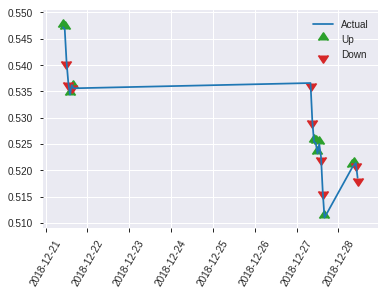


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20563699932727633
RMSE: 0.4534721593739536
LogLoss: 0.5907585118451858
Mean Per-Class Error: 0.3106518817204301
AUC: 0.7388272849462365
pr_auc: 0.6561189224827929
Gini: 0.477654569892473
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2809086740016937: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   68   0.5484   (68.0/124.0)
1      7    89   0.0729   (7.0/96.0)
Total  63   157  0.3409   (75.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280909     0.703557  156
max f2                       0.186045     0.833333  185
max f0point5                 0.44211      0.640496  96
max accuracy                 0.44211      0.686364  96
max precision                0.898142     1         0
max recall                   0.161251     1         195
max specificity              0.898142     1         0
max absolute_mcc             0.280909     0.415449  156
max min_per_class_accuracy   0.427754     0.669355  105
max mean_per_class_accuracy  0.280909     0.689348  156

Gains/Lift Table: Avg response rate: 43.64 %, avg score: 42.74 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0136364                   0.873686           2.29167  2.29167            1                0.88639   1                           0.88639             0.03125         0.03125                    129.167  129.167
    2        0.0227273                   0.854496           2.29167  2.29167            1                0.861292  1                           0.876351            0.0208333       0.0520833                  129.167  129.167
    3        0.0318182                   0.83389            2.29167  2.29167            1                0.844362  1                           0.867211            0.0208333       0.0729167                  129.167  129.167
    4        0.0409091                   0.820123           1.14583  2.03704            0.5              0.828872  0.888889                    0.858691            0.0104167       0.0833333                  14.5833  103.704
    5        0.05                        0.816623           1.14583  1.875              0.5              0.818209  0.818182                    0.851331            0.0104167       0.09375                    14.5833  87.5
    6        0.1                         0.717708           1.45833  1.66667            0.636364         0.7685    0.727273                    0.809916            0.0729167       0.166667                   45.8333  66.6667
    7        0.15                        0.687671           1.25     1.52778            0.545455         0.703048  0.666667                    0.774293            0.0625          0.229167                   25       52.7778
    8        0.2                         0.643585           1.875    1.61458            0.818182         0.666605  0.704545                    0.747371            0.09375         0.322917                   87.5     61.4583
    9        0.3                         0.545064           1.14583  1.45833            0.5              0.590969  0.636364                    0.695237            0.114583        0.4375                     14.5833  45.8333
    10       0.4                         0.469713           1.25     1.40625            0.545455         0.509903  0.613636                    0.648903            0.125           0.5625                     25       40.625
    11       0.5                         0.411894           1.25     1.375              0.545455         0.438625  0.6                         0.606848            0.125           0.6875                     25       37.5
    12       0.6                         0.353619           0.9375   1.30208            0.409091         0.386124  0.568182                    0.57006             0.09375         0.78125                    -6.25    30.2083
    13       0.7                         0.284209           1.25     1.29464            0.545455         0.31503   0.564935                    0.533627            0.125           0.90625                    25       29.4643
    14       0.8                         0.210484           0.625    1.21094            0.272727         0.247444  0.528409                    0.497855            0.0625          0.96875                    -37.5    21.0938
    15       0.9                         0.153763           0.3125   1.11111            0.136364         0.182508  0.484848                    0.462816            0.03125         1                          -68.75   11.1111
    16       1                           0.0444327          0        1                  0                0.108831  0.436364                    0.427417            0               1                      

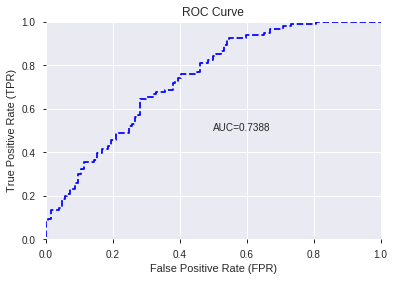

This function is available for GLM models only


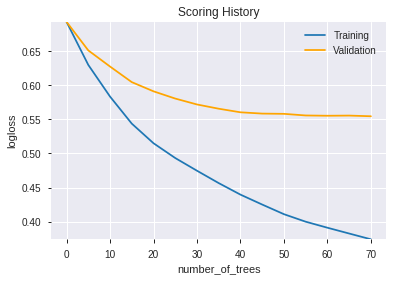

--2019-08-28 19:09:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_190823_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_190823_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9dea',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'MFI_20',
 'MFI_14',
 'BETA_12',
 'BETA_30',
 'HT_DCPERIOD',
 'HT_PHASOR_inphase',
 'WILLR_8',
 'BETA_8',
 'ADXR_8',
 'CCI_12',
 'STOCH_slowd',
 'BETA_20',
 'ADX_8',
 'CCI_8',
 'MFI_8',
 'STDDEV_20',
 'STOCH_slowk',
 'MACDEXT_hist',
 'BETA_14',
 'VAR_8',
 'ULTOSC',
 'ADX_14',
 'STDDEV_12',
 'MOM_20',
 'DX_8',
 'WILLR_20',
 'CDLBELTHOLD',
 'MFI_24',
 'PLUS_DM_8',
 'MFI_12',
 'CORREL_12',
 'WILLR_30',
 'MINUS_DI_20',
 'ADX_24',
 'CORREL_20',
 'NATR_8',
 'ATR_8',
 'CCI_30',
 'STDDEV_24',
 'CORREL_8',
 'LINEARREG_ANGLE_12',
 'CORREL_14',
 'MINUS_DM_12',
 'ATR_30',
 'AROONOSC_14',
 'DX_20',
 'ATR_12',
 'WILLR_12',
 'ADXR_12',
 'ADX_20',
 'DX_12',
 'DX_24',
 'LINEARREG_ANGLE_20',
 'PLUS_DM_12',
 'CORREL_30',
 'ADX_12',
 'CCI_20',
 'aroonup_12',
 'aroonup_20',
 'CMO_30',
 'CCI_24',
 'PLUS_DI_8',
 'aroondown_20',
 'MINUS_DI_14',
 'ROC_20',
 'STDDEV_14',
 'MOM_8',
 'ROC_12'

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.705
GLM             0.691
XGBoost         0.695
dtype: float64

DeepLearning    GLM  XGBoost
All          0.673  0.677    0.691
DLF          0.677  0.686    0.682
Fwe          0.691  0.691    0.695
RFE          0.705  0.682    0.686
XGBF         0.691  0.686    0.682





F1


DeepLearning    0.703
GLM             0.691
XGBoost         0.710
dtype: float64

DeepLearning    GLM  XGBoost
All          0.664  0.674    0.695
DLF          0.675  0.676    0.670
Fwe          0.703  0.691    0.710
RFE          0.693  0.669    0.704
XGBF         0.676  0.676    0.670





auc


DeepLearning    0.758
GLM             0.753
XGBoost         0.750
dtype: float64

DeepLearning    GLM  XGBoost
All          0.711  0.725    0.737
DLF          0.736  0.734    0.734
Fwe          0.754  0.753    0.750
RFE          0.758  0.734    0.739
XGBF         0.736  0.734    0.734





logloss


DeepLearning    2.181
GLM             0.597
XGBoost         0.597
dtype: float64

DeepLearning    GLM  XGBoost
All          2.181  0.597    0.597
DLF          0.668  0.590    0.597
Fwe          0.585  0.575    0.585
RFE          0.614  0.591    0.591
XGBF         0.585  0.590    0.597





mean_per_class_error


DeepLearning    0.325
GLM             0.324
XGBoost         0.324
dtype: float64

DeepLearning    GLM  XGBoost
All          0.323  0.324    0.306
DLF          0.316  0.318    0.324
Fwe          0.299  0.300    0.287
RFE          0.316  0.316    0.311
XGBF         0.325  0.318    0.324





rmse


DeepLearning    0.555
GLM             0.456
XGBoost         0.456
dtype: float64

DeepLearning    GLM  XGBoost
All          0.555  0.456    0.454
DLF          0.482  0.452    0.456
Fwe          0.444  0.446    0.451
RFE          0.458  0.453    0.453
XGBF         0.452  0.452    0.456





mse


DeepLearning    0.308
GLM             0.208
XGBoost         0.208
dtype: float64

DeepLearning    GLM  XGBoost
All          0.308  0.208    0.206
DLF          0.233  0.204    0.208
Fwe          0.197  0.199    0.204
RFE          0.210  0.205    0.206
XGBF         0.205  0.204    0.208

{'F1':       DeepLearning    GLM  XGBoost
 All          0.664    NaN      NaN
 DLF          0.675    NaN      NaN
 DLF            NaN  0.676      NaN
 DLF            NaN    NaN    0.670
 All            NaN  0.674      NaN
 All            NaN    NaN    0.695
 XGBF         0.676    NaN      NaN
 XGBF           NaN  0.676      NaN
 XGBF           NaN    NaN    0.670
 Fwe          0.703    NaN      NaN
 Fwe            NaN  0.691      NaN
 Fwe            NaN    NaN    0.710
 RFE          0.693    NaN      NaN
 RFE            NaN  0.669      NaN
 RFE            NaN    NaN    0.704,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.673    NaN      NaN
 DLF          0.677    NaN      NaN
 DLF            NaN  0.686      NaN
 DLF            NaN    NaN    0.682
 All            NaN  0.677      NaN
 All            NaN    NaN    0.691
 XGBF         0.691    NaN      NaN
 XGBF           NaN  0.686      NaN
 XGBF           NaN    NaN    0.682
 Fwe          0.691    NaN      NaN
 Fwe     